# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# global variable
prev_clip_data = [0,0,0,0]
print ('prev_clip_data =', prev_clip_data[0])

prev_clip_data = 0


## Read in an Image

In [2]:
#reading in an image
#image = mpimg.imread('test_images/Challenge6.jpg')

#printing out some stats and plotting
#print('This image is:', type(image), 'with dimensions:', image.shape)
#plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [32]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
         
    """
    NOTE: this section iterates through the line co-ordinates returned by Hough transform and
    calculates the average slope (m) and intercept (b) for left lane and right lane seperately.  Any 
    outliers are filtered.
    
    The left and right lanes are extrapolated by determining top and bottom x values using y = mx + b 
    for y = 330 and 539
    
    """

    global prev_clip_data
    
    prev_left_slope = prev_clip_data [0]
    prev_left_intercept = prev_clip_data [1]
    prev_right_slope = prev_clip_data [2]
    prev_right_intercept = prev_clip_data [3]
    slope_tolerance = .05
    intercept_tolerance = 75
 
    top_y = int(img.shape [0] * .62)
    bottom_y = int(img.shape [0] * 1)


    """                
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, intercept = np.polyfit([x1,x2],[y1,y2], 1)         # calculate slope & intercept
            print ('slope, intercept =', slope, ' ', intercept)
            print ('line =', line)
            if(((slope*slope) > 0.1) & ((slope*slope) < 100)):       # filter outliers
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    """    
    
    if (prev_left_slope == 0):
        left_lane_slope_accumulator = 0
        left_lane_intercept_accumulator =0
        left_lane_line_counter = 0
        right_lane_slope_accumulator = 0
        right_lane_intercept_accumulator = 0
        right_lane_line_counter = 0
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope, intercept = np.polyfit([x1,x2],[y1,y2], 1)         # calculate slope & intercept
                if(((slope*slope) > 0.1) & ((slope*slope) < 100)):       # filter outliers
                    if(slope<0):
                        left_lane_slope_accumulator += slope
                        left_lane_intercept_accumulator += intercept
                        left_lane_line_counter += 1
                    else:
                        right_lane_slope_accumulator += slope
                        right_lane_intercept_accumulator += intercept
                        right_lane_line_counter += 1
                else:
                    print ('ignoring line ', line, ' as outlier ', slope, intercept)

        if(left_lane_line_counter !=0):                                    # handle division by zero scenario
            left_lane_slope_average = left_lane_slope_accumulator/left_lane_line_counter
            left_lane_intercept_average = left_lane_intercept_accumulator/left_lane_line_counter
            left_lane_top_x = (top_y-left_lane_intercept_average)/left_lane_slope_average
            left_lane_bottom_x = (bottom_y-left_lane_intercept_average)/left_lane_slope_average
            cv2.line(img, (int(left_lane_bottom_x), bottom_y), (int(left_lane_top_x), top_y), color, thickness)

        if(right_lane_line_counter !=0):                                    # handle division by zero scenario
            right_lane_slope_average = right_lane_slope_accumulator/right_lane_line_counter
            right_lane_intercept_average = right_lane_intercept_accumulator/right_lane_line_counter
            right_lane_top_x = (top_y-right_lane_intercept_average)/right_lane_slope_average
            right_lane_bottom_x = (bottom_y-right_lane_intercept_average)/right_lane_slope_average
            cv2.line(img, (int(right_lane_bottom_x), bottom_y), (int(right_lane_top_x), top_y), color, thickness)
        
        prev_clip_data = [left_lane_slope_average,left_lane_intercept_average, \
                             right_lane_slope_average,right_lane_intercept_average]
        print ('current clip data =', prev_clip_data)

    else:
        left_lane_slope_accumulator = prev_left_slope
        left_lane_intercept_accumulator = prev_left_intercept
        left_lane_line_counter = 1
        right_lane_slope_accumulator = prev_right_slope
        right_lane_intercept_accumulator = prev_right_intercept
        right_lane_line_counter = 1
        
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope, intercept = np.polyfit([x1,x2],[y1,y2], 1)         # calculate slope & intercept
                if(((slope*slope) > 0.1) & ((slope*slope) < 100)):       # filter outliers
                    if (slope<0):
                        if ((prev_left_slope-slope_tolerance) < slope < (prev_left_slope+slope_tolerance)) & \
                          ((prev_left_intercept-intercept_tolerance) < intercept < \
                             (prev_left_intercept+intercept_tolerance)):
                            left_lane_slope_accumulator += slope
                            left_lane_intercept_accumulator += intercept
                            left_lane_line_counter += 1
                        else:
                            print ('ignoring line ', line, ' as outlier ', slope, intercept)
                    else:
                        if ((prev_right_slope-slope_tolerance) < slope < (prev_right_slope+slope_tolerance)) & \
                          ((prev_right_intercept-intercept_tolerance) < intercept < (prev_right_intercept+intercept_tolerance)):
                            right_lane_slope_accumulator += slope
                            right_lane_intercept_accumulator += intercept
                            right_lane_line_counter += 1
                        else:
                            print ('ignoring line ', line, ' as outlier ', slope, intercept)
                else:
                    print ('ignoring line ', line, ' as outlier ', slope, intercept)
 


        left_lane_slope_average = left_lane_slope_accumulator/left_lane_line_counter
        left_lane_intercept_average = left_lane_intercept_accumulator/left_lane_line_counter
        left_lane_top_x = (top_y-left_lane_intercept_average)/left_lane_slope_average
        left_lane_bottom_x = (bottom_y-left_lane_intercept_average)/left_lane_slope_average
        cv2.line(img, (int(left_lane_bottom_x), bottom_y), (int(left_lane_top_x), top_y), color, thickness)

        right_lane_slope_average = right_lane_slope_accumulator/right_lane_line_counter
        right_lane_intercept_average = right_lane_intercept_accumulator/right_lane_line_counter
        right_lane_top_x = (top_y-right_lane_intercept_average)/right_lane_slope_average
        right_lane_bottom_x = (bottom_y-right_lane_intercept_average)/right_lane_slope_average
        cv2.line(img, (int(right_lane_bottom_x), bottom_y), (int(right_lane_top_x), top_y), color, thickness)
        
        prev_clip_data = [left_lane_slope_average,left_lane_intercept_average, \
                             right_lane_slope_average,right_lane_intercept_average]

        print ('current clip data =', prev_clip_data)
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
#    print ('line =', lines[0])
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['Challenge5.jpg',
 'Challenge6.jpg',
 'Challenge7.jpg',
 'Output2_Challenge5.jpg',
 'Output2_Challenge5_old.jpg',
 'Output2_Challenge5_old_full.jpg',
 'Output2_Challenge6.jpg',
 'Output2_Challenge6_old.jpg',
 'Output2_Challenge7.jpg',
 'Output2_Challenge7_old.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [33]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def pipeline(input_image):
#    print ("inside pipeline")
#    print ("input image")
#    plt.imshow(inImg)
    
    gaussian_kernel_size = 5  # kernel size used for gaussian blur
    canny_low_threshold = 30 # pixel with gradient below the low threshold are rejected
    canny_high_threshold = 150 # gradient used to detect strong edges
    
#    print('image dimensions =', input_image.shape)
    center_x = input_image.shape [1]/2
#    print ('center x value =', center_x)
    mask_bottom_right_x = input_image.shape [1]*.975
#    print ('mask_bottom_right_x value =', mask_bottom_right_x)
    mask_bottom_left_x = input_image.shape [1]*.125
#    print ('mask_bottom_left_x value =', mask_bottom_left_x)
    mask_top_right_x = input_image.shape [1]*.575
#    print ('mask_top_right_x value =', mask_top_right_x)
    mask_top_left_x = input_image.shape [1]*.425
#    print ('mask_top_left_x value =', mask_top_left_x)
    mask_top_y = input_image.shape [0]*.62
#    print ('mask_top_y', mask_top_y)
    mask_bottom_y = input_image.shape [0] * 1.0
#    print ('mask_bottom_y', mask_bottom_y)
    
    vertices = np.array([[(mask_top_left_x,mask_top_y),(mask_top_right_x,mask_top_y), \
                          (mask_bottom_right_x,mask_bottom_y),(mask_bottom_left_x,mask_bottom_y)]], \
                             dtype=np.int32) # vertices of the masked area
#    vertices = np.array([[(420,330),(550,330),(920,539),(120,539)]],dtype=np.int32) # vertices of the masked area
#    vertices = np.array([[(420,340),(560,340),(920,539),(120,539)]],dtype=np.int32) # vertices of the masked area
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    
    grayscale_image = grayscale(input_image)
#    print ("gray image")
#    plt.imshow(grayscale_image, cmap='gray')

    gaussian_blurred_image = gaussian_blur (grayscale_image,gaussian_kernel_size)
#    print ("gaussian image")
#    plt.imshow(gaussian_blurred_image, cmap='gray')

    canny_image = canny(gaussian_blurred_image,canny_low_threshold,canny_high_threshold)
#    print ("canny image")
    plt.imshow(canny_image, cmap='gray')
    plt.imsave('canny.png',canny_image, format='png',cmap='gray')

    masked_image = region_of_interest (canny_image,vertices)
#    print ("masked image")
#    plt.imshow(masked_image, cmap='gray')
#    plt.show()

    hough_image = hough_lines(masked_image,rho, theta, threshold, min_line_length, max_line_gap)
#    print ("hough image")
#    plt.imshow(hough_image, cmap='gray')
#    plt.show()

    weighted_image = weighted_img(hough_image, input_image)
#    print ("weighted image")
#    plt.imshow(weighted_image)
    
    return weighted_image

"""
NOTE : This section is used to test the pipeline against the set of test images provided

images = os.listdir('test_images/')

for image in images:
    
    if image[:6] != 'Output':
        input_image = mpimg.imread('test_images/%s' % image)
        print ('processing image ', image)
        output_image = pipeline (input_image)
        output_img_name = 'Output2_' + image
        print ('output image name =', output_img_name)
        mpimg.imsave('test_images/%s' % output_img_name,output_image)
    else:
        print ('ignoring image ', image)

"""
print ('dummy statement to make the above multiline comment work')



dummy statement to make the above multiline comment work


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result = pipeline(image)

    return result

Let's try the one with the solid white lane on the right first ...

current clip data = [-0.71073495876492621, 648.11167620587742, 0.62626395880015817, 4.2316509170081877]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|                                                                                                                                                                                                             | 0/222 [00:00<?, ?it/s]

current clip data = [-0.71073495876492632, 648.11167620587742, 0.62626395880015817, 4.2316509170081886]


  0%|▉                                                                                                                                                                                                    | 1/222 [00:00<00:46,  4.74it/s]

current clip data = [-0.72326346671176212, 651.63960643333974, 0.61707230139528013, 9.3090416178531417]


  1%|█▊                                                                                                                                                                                                   | 2/222 [00:00<00:48,  4.50it/s]

current clip data = [-0.72172503552008038, 650.6395794177638, 0.6184630099128785, 8.770502153131158]


  1%|██▋                                                                                                                                                                                                  | 3/222 [00:00<00:46,  4.74it/s]

current clip data = [-0.72717337691878736, 652.03227714651746, 0.6214001460710441, 4.3266800194072594]


  2%|███▌                                                                                                                                                                                                 | 4/222 [00:00<00:45,  4.81it/s]

current clip data = [-0.70922294587804779, 645.64916647069481, 0.608619189688131, 16.496908610561615]


  2%|████▍                                                                                                                                                                                                | 5/222 [00:01<00:43,  4.98it/s]

current clip data = [-0.70524324868370047, 643.58863151409764, 0.61251656903623175, 15.085079557863111]


  3%|█████▎                                                                                                                                                                                               | 6/222 [00:01<00:43,  4.98it/s]

ignoring line  [[349 402 421 344]]  as outlier  -0.805555555556 683.138888889
current clip data = [-0.7108889855455377, 645.9750797051496, 0.61559344676060745, 10.830930765211003]


  3%|██████▏                                                                                                                                                                                              | 7/222 [00:01<00:44,  4.87it/s]

current clip data = [-0.71987690104103708, 647.9306317881485, 0.60688033606463743, 12.653644633301109]


  4%|███████                                                                                                                                                                                              | 8/222 [00:01<00:42,  5.00it/s]

current clip data = [-0.7150854138185101, 647.31016674294835, 0.61027741164963822, 14.703879505063648]


  4%|███████▉                                                                                                                                                                                             | 9/222 [00:01<00:41,  5.14it/s]

ignoring line  [[303 438 351 401]]  as outlier  -0.770833333333 671.5625
ignoring line  [[604 382 629 396]]  as outlier  0.56 43.76
current clip data = [-0.69676608002381757, 640.16009313593122, 0.60394669464291273, 19.365634016093242]


  5%|████████▊                                                                                                                                                                                           | 10/222 [00:02<00:44,  4.75it/s]

ignoring line  [[275 460 339 410]]  as outlier  -0.78125 674.84375
current clip data = [-0.71120803468335203, 648.19238872157234, 0.61191249290857763, 16.286826939823779]


  5%|█████████▋                                                                                                                                                                                          | 11/222 [00:02<00:43,  4.82it/s]

ignoring line  [[539 348 616 399]]  as outlier  0.662337662338 -9.0
current clip data = [-0.7093228579455344, 650.27803595735622, 0.62505871760087939, 10.431310031727289]


  5%|██████████▌                                                                                                                                                                                         | 12/222 [00:02<00:44,  4.76it/s]

current clip data = [-0.70919557409283185, 648.75232190041504, 0.63226924531880968, 4.9612102591873146]


  6%|███████████▍                                                                                                                                                                                        | 13/222 [00:02<00:43,  4.83it/s]

current clip data = [-0.70953287835004331, 645.76235527569418, 0.62547110086610735, 7.9272270010124952]


  6%|████████████▎                                                                                                                                                                                       | 14/222 [00:02<00:42,  4.87it/s]

ignoring line  [[375 375 430 342]]  as outlier  -0.6 600.0
current clip data = [-0.72640349811077398, 649.74433384113229, 0.63768157444475093, -0.20370264368547422]


  7%|█████████████▏                                                                                                                                                                                      | 15/222 [00:03<00:39,  5.27it/s]

ignoring line  [[372 380 427 343]]  as outlier  -0.672727272727 630.254545455
current clip data = [-0.70710698486261891, 641.28992190918814, 0.64331346786509214, -3.4126720546083047]


  7%|██████████████▏                                                                                                                                                                                     | 16/222 [00:03<00:37,  5.51it/s]

current clip data = [-0.70399111669790748, 639.89322705190068, 0.63537507338050037, -0.36393276480580705]


  8%|███████████████                                                                                                                                                                                     | 17/222 [00:03<00:35,  5.77it/s]

current clip data = [-0.6929475451496564, 636.32760829327754, 0.63538541706094254, -0.31477607390400353]


  8%|███████████████▉                                                                                                                                                                                    | 18/222 [00:03<00:33,  6.05it/s]

ignoring line  [[355 396 435 334]]  as outlier  -0.775 671.125
current clip data = [-0.69646496690538773, 640.59570480883815, 0.63910144440763794, -0.13036038885287904]


  9%|████████████████▊                                                                                                                                                                                   | 19/222 [00:03<00:33,  6.00it/s]

ignoring line  [[394 368 422 350]]  as outlier  -0.642857142857 621.285714286
ignoring line  [[411 356 439 338]]  as outlier  -0.642857142857 620.214285714
current clip data = [-0.68574858345022205, 636.9193304737579, 0.63877411822354646, -0.73991432576545579]


  9%|█████████████████▋                                                                                                                                                                                  | 20/222 [00:03<00:34,  5.82it/s]

current clip data = [-0.68105774206851699, 636.19365375665063, 0.64501010251466695, -2.527878598369794]


  9%|██████████████████▌                                                                                                                                                                                 | 21/222 [00:03<00:33,  6.07it/s]

current clip data = [-0.69485141518834015, 642.1717773594429, 0.63920941055634029, 0.21453694263696016]


 10%|███████████████████▍                                                                                                                                                                                | 22/222 [00:04<00:31,  6.38it/s]

ignoring line  [[278 455 341 408]]  as outlier  -0.746031746032 662.396825397
ignoring line  [[308 424 334 408]]  as outlier  -0.615384615385 613.538461538
current clip data = [-0.69825361182606516, 644.0305381053214, 0.63824485500507211, 0.14043495097276198]


 10%|████████████████████▎                                                                                                                                                                               | 23/222 [00:04<00:32,  6.06it/s]

ignoring line  [[372 385 433 338]]  as outlier  -0.770491803279 671.62295082
ignoring line  [[246 478 283 450]]  as outlier  -0.756756756757 664.162162162
current clip data = [-0.70947909210607474, 648.10807440902772, 0.64086859901073367, -0.83335164566737829]


 11%|█████████████████████▏                                                                                                                                                                              | 24/222 [00:04<00:34,  5.69it/s]

current clip data = [-0.70769450563169323, 647.25175706304151, 0.63576634675478372, 1.5567162016511094]


 11%|██████████████████████                                                                                                                                                                              | 25/222 [00:04<00:34,  5.64it/s]

current clip data = [-0.69898475431791596, 644.60531436448366, 0.6347971890710935, 1.9955266072477171]


 12%|██████████████████████▉                                                                                                                                                                             | 26/222 [00:04<00:31,  6.14it/s]

current clip data = [-0.69573545291937988, 643.63674630670982, 0.63986458040000171, -0.097386834273300193]


 12%|███████████████████████▊                                                                                                                                                                            | 27/222 [00:04<00:30,  6.32it/s]

ignoring line  [[205 508 225 493]]  as outlier  -0.75 661.75
current clip data = [-0.69793653341272832, 643.38974464315118, 0.63717767386649737, 0.5852991736434382]


 13%|████████████████████████▋                                                                                                                                                                           | 28/222 [00:05<00:30,  6.38it/s]

current clip data = [-0.71284939923620116, 648.78354219257255, 0.64122590429647797, -2.2146405359919852]


 13%|█████████████████████████▌                                                                                                                                                                          | 29/222 [00:05<00:27,  6.92it/s]

current clip data = [-0.72001782201603726, 651.07468835612997, 0.64408089568756799, -3.3025657245653894]


 14%|██████████████████████████▍                                                                                                                                                                         | 30/222 [00:05<00:27,  6.88it/s]

current clip data = [-0.7136170517831234, 648.14850722982112, 0.63902857521452894, -1.9435257863000892]


 14%|███████████████████████████▎                                                                                                                                                                        | 31/222 [00:05<00:26,  7.14it/s]

current clip data = [-0.71835746069408213, 648.96618523481868, 0.63621165388090806, -1.1256889393059184]


 14%|████████████████████████████▎                                                                                                                                                                       | 32/222 [00:05<00:24,  7.74it/s]

ignoring line  [[389 370 419 350]]  as outlier  -0.666666666667 629.333333333
current clip data = [-0.7136802742644317, 646.36086449052368, 0.62689553577221557, 3.7310157536756448]


 15%|█████████████████████████████▏                                                                                                                                                                      | 33/222 [00:05<00:24,  7.59it/s]

current clip data = [-0.71488596116407432, 648.12305356820355, 0.63534374498723056, -0.16097546015584213]


 15%|██████████████████████████████                                                                                                                                                                      | 34/222 [00:05<00:25,  7.34it/s]

ignoring line  [[377 377 436 338]]  as outlier  -0.661016949153 626.203389831
current clip data = [-0.71793184590762504, 650.69101026323563, 0.64158654580848873, -4.4855157742907075]


 16%|██████████████████████████████▉                                                                                                                                                                     | 35/222 [00:06<00:27,  6.84it/s]

current clip data = [-0.71262820316767517, 648.32677535320443, 0.64332156051458, -2.7720027352510535]


 16%|███████████████████████████████▊                                                                                                                                                                    | 36/222 [00:06<00:27,  6.82it/s]

ignoring line  [[198 501 251 466]]  as outlier  -0.660377358491 631.754716981
current clip data = [-0.71585550735468417, 650.6582624230881, 0.62629982073632007, 7.5095984584223858]


 17%|████████████████████████████████▋                                                                                                                                                                   | 37/222 [00:06<00:28,  6.53it/s]

ignoring line  [[240 472 281 445]]  as outlier  -0.658536585366 630.048780488
current clip data = [-0.70784385701501928, 648.80469389896177, 0.64024410813542498, -0.69548914643553739]


 17%|█████████████████████████████████▌                                                                                                                                                                  | 38/222 [00:06<00:28,  6.52it/s]

ignoring line  [[383 378 430 341]]  as outlier  -0.787234042553 679.510638298
current clip data = [-0.71753621596531358, 649.38897055291807, 0.65311272994457181, -8.6890168353347246]


 18%|██████████████████████████████████▍                                                                                                                                                                 | 39/222 [00:06<00:29,  6.15it/s]

current clip data = [-0.72420263195447243, 653.10226527920497, 0.65718587771801584, -13.093542793375308]


 18%|███████████████████████████████████▎                                                                                                                                                                | 40/222 [00:06<00:28,  6.33it/s]

ignoring line  [[368 387 392 371]]  as outlier  -0.666666666667 632.333333333
ignoring line  [[142 538 163 524]]  as outlier  -0.666666666667 632.666666667
current clip data = [-0.71456033237067873, 646.84621460681547, 0.65525595812383919, -10.95239880844921]


 18%|████████████████████████████████████▏                                                                                                                                                               | 41/222 [00:07<00:30,  6.02it/s]

ignoring line  [[361 393 437 334]]  as outlier  -0.776315789474 673.25
current clip data = [-0.73420324310841623, 652.85387653417695, 0.65622717330677971, -11.837737092262294]


 19%|█████████████████████████████████████                                                                                                                                                               | 42/222 [00:07<00:30,  5.99it/s]

ignoring line  [[625 400 666 429]]  as outlier  0.707317073171 -42.0731707317
current clip data = [-0.73219880183385833, 652.72565115241753, 0.6584454231526532, -14.302656011156868]


 19%|█████████████████████████████████████▉                                                                                                                                                              | 43/222 [00:07<00:31,  5.65it/s]

ignoring line  [[765 483 854 537]]  as outlier  0.606741573034 18.8426966292
current clip data = [-0.72420973813674949, 648.24125752661098, 0.6612464024885798, -17.204488357515874]


 20%|██████████████████████████████████████▊                                                                                                                                                             | 44/222 [00:07<00:30,  5.83it/s]

ignoring line  [[392 366 438 335]]  as outlier  -0.673913043478 630.173913043
current clip data = [-0.72268854212496136, 647.42416120147971, 0.65161736041436857, -9.5885710911125255]


 20%|███████████████████████████████████████▋                                                                                                                                                            | 45/222 [00:07<00:28,  6.16it/s]

ignoring line  [[304 434 354 395]]  as outlier  -0.78 671.12
ignoring line  [[305 434 354 396]]  as outlier  -0.775510204082 670.530612245
current clip data = [-0.71240615221829107, 642.90349532926791, 0.641808645679384, -4.4894974593194998]


 21%|████████████████████████████████████████▌                                                                                                                                                           | 46/222 [00:07<00:29,  5.98it/s]

ignoring line  [[296 440 342 403]]  as outlier  -0.804347826087 678.086956522
ignoring line  [[282 450 314 425]]  as outlier  -0.78125 670.3125
ignoring line  [[529 335 563 359]]  as outlier  0.705882352941 -38.4117647059
current clip data = [-0.70792463693969609, 640.57723029291105, 0.65088305671613911, -10.421276087760656]


 21%|█████████████████████████████████████████▍                                                                                                                                                          | 47/222 [00:08<00:30,  5.75it/s]

ignoring line  [[289 445 329 414]]  as outlier  -0.775 668.975
ignoring line  [[252 472 282 449]]  as outlier  -0.766666666667 665.2
current clip data = [-0.6949835481724369, 637.08112275269468, 0.66252765685753789, -18.614893916974289]


 22%|██████████████████████████████████████████▍                                                                                                                                                         | 48/222 [00:08<00:30,  5.74it/s]

ignoring line  [[212 501 313 425]]  as outlier  -0.752475247525 660.524752475
ignoring line  [[266 462 313 426]]  as outlier  -0.765957446809 665.744680851
current clip data = [-0.70022667745786416, 637.90142157325397, 0.65028640181221853, -10.375153954528225]


 22%|███████████████████████████████████████████▎                                                                                                                                                        | 49/222 [00:08<00:28,  6.03it/s]

current clip data = [-0.72499033678547808, 647.61972629912611, 0.64938914913074175, -8.8538961232681928]


 23%|████████████████████████████████████████████▏                                                                                                                                                       | 50/222 [00:08<00:26,  6.61it/s]

ignoring line  [[144 534 257 458]]  as outlier  -0.672566371681 630.849557522
current clip data = [-0.71192897931024757, 643.6602379809035, 0.64335775601455236, -5.0117999225172758]


 23%|█████████████████████████████████████████████                                                                                                                                                       | 51/222 [00:08<00:24,  7.01it/s]

ignoring line  [[367 380 405 351]]  as outlier  -0.763157894737 660.078947368
current clip data = [-0.71656047362401865, 644.40108904620013, 0.64031987872606255, -1.4900261657385676]


 23%|█████████████████████████████████████████████▉                                                                                                                                                      | 52/222 [00:08<00:23,  7.16it/s]

ignoring line  [[361 386 426 343]]  as outlier  -0.661538461538 624.815384615
ignoring line  [[135 538 170 515]]  as outlier  -0.657142857143 626.714285714
current clip data = [-0.70554078187006342, 639.59211136618319, 0.64936612093295598, -10.156713293913976]


 24%|██████████████████████████████████████████████▊                                                                                                                                                     | 53/222 [00:08<00:23,  7.22it/s]

current clip data = [-0.70837077139556504, 640.91269362169805, 0.64861102587827146, -8.8951746265233069]


 24%|███████████████████████████████████████████████▋                                                                                                                                                    | 54/222 [00:09<00:21,  7.87it/s]

ignoring line  [[337 399 372 377]]  as outlier  -0.628571428571 610.828571429
ignoring line  [[396 362 419 348]]  as outlier  -0.608695652174 603.043478261
ignoring line  [[337 398 370 377]]  as outlier  -0.636363636364 612.454545455
current clip data = [-0.69995545752286115, 637.52563883186588, 0.65061315688013466, -10.474481333720933]


 25%|████████████████████████████████████████████████▌                                                                                                                                                   | 55/222 [00:09<00:21,  7.79it/s]

current clip data = [-0.68580946759262273, 632.63160555598836, 0.64967295480717446, -6.8592482590711557]


 25%|█████████████████████████████████████████████████▍                                                                                                                                                  | 56/222 [00:09<00:20,  8.02it/s]

current clip data = [-0.6838033693389679, 632.72862717443343, 0.66056249736817441, -13.172010870207655]


 26%|██████████████████████████████████████████████████▎                                                                                                                                                 | 57/222 [00:09<00:19,  8.52it/s]

ignoring line  [[298 436 345 401]]  as outlier  -0.744680851064 657.914893617
current clip data = [-0.6563264580982886, 622.31777871479051, 0.64149149504365865, 1.0171914899095054]


 26%|███████████████████████████████████████████████████▏                                                                                                                                                | 58/222 [00:09<00:19,  8.55it/s]

ignoring line  [[272 454 335 407]]  as outlier  -0.746031746032 656.920634921
ignoring line  [[303 432 335 408]]  as outlier  -0.75 659.25
ignoring line  [[562 358 593 376]]  as outlier  0.58064516129 31.6774193548
ignoring line  [[522 337 543 349]]  as outlier  0.571428571429 38.7142857143
current clip data = [-0.67413332751746258, 629.67365928761842, 0.63519356885541078, 2.4969629679206791]


 27%|████████████████████████████████████████████████████                                                                                                                                                | 59/222 [00:09<00:20,  8.11it/s]

ignoring line  [[240 476 320 418]]  as outlier  -0.725 650.0
current clip data = [-0.67765534555045681, 630.62301182415706, 0.63748172415165083, 0.53052313992829947]


 27%|████████████████████████████████████████████████████▉                                                                                                                                               | 60/222 [00:09<00:19,  8.26it/s]

ignoring line  [[196 507 230 482]]  as outlier  -0.735294117647 651.117647059
ignoring line  [[605 390 669 434]]  as outlier  0.6875 -25.9375
current clip data = [-0.68054127482838156, 631.74890398108937, 0.64970438141489517, -6.722114210456521]


 27%|█████████████████████████████████████████████████████▊                                                                                                                                              | 61/222 [00:09<00:19,  8.37it/s]

current clip data = [-0.70317744684919137, 640.7005845984844, 0.65762896834213058, -10.860227729487491]
current clip data = [-0.68912488959992013, 634.38657604808668, 0.65402305557368112, -8.1147628345484843]


 28%|███████████████████████████████████████████████████████▌                                                                                                                                            | 63/222 [00:10<00:17,  9.17it/s]

current clip data = [-0.66997717646341892, 629.61018365470807, 0.65403452565547326, -8.0971100065580845]


 29%|████████████████████████████████████████████████████████▌                                                                                                                                           | 64/222 [00:10<00:16,  9.40it/s]

ignoring line  [[706 460 747 489]]  as outlier  0.707317073171 -39.3658536585
ignoring line  [[734 479 756 495]]  as outlier  0.727272727273 -54.8181818182
current clip data = [-0.68599224353485688, 634.92898986446312, 0.66955564978915716, -16.603933376543143]


 29%|█████████████████████████████████████████████████████████▍                                                                                                                                          | 65/222 [00:10<00:17,  9.15it/s]

ignoring line  [[353 394 420 344]]  as outlier  -0.746268656716 657.432835821
current clip data = [-0.66817502068922607, 627.31545479394617, 0.65988497058541939, -11.003126332854253]


 30%|██████████████████████████████████████████████████████████▎                                                                                                                                         | 66/222 [00:10<00:16,  9.39it/s]

current clip data = [-0.66712776054865097, 626.12590670923942, 0.6444566864214385, -3.4686015939617216]
ignoring line  [[775 504 824 539]]  as outlier  0.714285714286 -49.5714285714
current clip data = [-0.66414252910959326, 624.29215180262304, 0.64688577728102048, -4.1894447146938631]


 31%|████████████████████████████████████████████████████████████                                                                                                                                        | 68/222 [00:10<00:15,  9.77it/s]

current clip data = [-0.6712438725371852, 627.21574009328708, 0.65479838439459093, -8.9593228788129551]
current clip data = [-0.68639824903518454, 633.71560512601388, 0.66002402782298852, -11.523921632729156]


 32%|█████████████████████████████████████████████████████████████▊                                                                                                                                      | 70/222 [00:10<00:14, 10.41it/s]

current clip data = [-0.69685696262268482, 635.90901381084723, 0.66375924463020042, -13.282064717668122]
ignoring line  [[389 363 431 336]]  as outlier  -0.642857142857 613.071428571
ignoring line  [[264 444 314 413]]  as outlier  -0.62 607.68
ignoring line  [[231 466 317 412]]  as outlier  -0.627906976744 611.046511628
current clip data = [-0.68216389871046901, 631.15432308737309, 0.65650782263413465, -11.285211195136204]


 32%|███████████████████████████████████████████████████████████████▌                                                                                                                                    | 72/222 [00:10<00:14, 10.53it/s]

current clip data = [-0.68684531565500639, 632.41463285786108, 0.66857979808781698, -16.568863096863144]
current clip data = [-0.67325248264999416, 627.6533802918151, 0.66374544138437586, -13.367989885464715]


 33%|█████████████████████████████████████████████████████████████████▎                                                                                                                                  | 74/222 [00:11<00:13, 10.89it/s]

current clip data = [-0.67671337252605623, 628.70440943011147, 0.66336573508745722, -14.1848378790929]
current clip data = [-0.66002864489821367, 622.47098354816433, 0.66353608070789982, -11.435994656964123]


 34%|███████████████████████████████████████████████████████████████████                                                                                                                                 | 76/222 [00:11<00:12, 11.58it/s]

current clip data = [-0.66230286914444303, 620.69379323078863, 0.65846130188080543, -7.2582262645832909]
ignoring line  [[344 390 438 334]]  as outlier  -0.595744680851 594.936170213
ignoring line  [[355 390 433 334]]  as outlier  -0.717948717949 644.871794872
current clip data = [-0.66230286914444303, 620.69379323078863, 0.66407920286244371, -9.3251620386132714]


 35%|████████████████████████████████████████████████████████████████████▊                                                                                                                               | 78/222 [00:11<00:12, 11.34it/s]

ignoring line  [[333 397 368 376]]  as outlier  -0.6 596.8
current clip data = [-0.67964929884639436, 629.51886054173974, 0.67732947069881666, -18.014140984161148]
ignoring line  [[319 406 358 382]]  as outlier  -0.615384615385 602.307692308
current clip data = [-0.68207154946348625, 630.86778634065979, 0.67705242498975537, -19.356156669557475]


 36%|██████████████████████████████████████████████████████████████████████▋                                                                                                                             | 80/222 [00:11<00:12, 11.48it/s]

ignoring line  [[302 417 351 387]]  as outlier  -0.612244897959 601.897959184
ignoring line  [[380 369 408 348]]  as outlier  -0.75 654.0
ignoring line  [[572 367 614 393]]  as outlier  0.619047619048 12.9047619048
current clip data = [-0.68440677625476032, 631.97250214072039, 0.67643357665862691, -18.773010296034649]
ignoring line  [[283 430 341 394]]  as outlier  -0.620689655172 605.655172414
ignoring line  [[401 357 434 337]]  as outlier  -0.606060606061 600.03030303
ignoring line  [[525 334 552 354]]  as outlier  0.740740740741 -54.8888888889
current clip data = [-0.67828575999775553, 628.08997993078412, 0.68255432916594316, -21.090493543313656]


 37%|████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 82/222 [00:11<00:13, 10.44it/s]

ignoring line  [[369 377 432 338]]  as outlier  -0.619047619048 605.428571429
current clip data = [-0.67807753731565978, 628.02195664665146, 0.68371241555986528, -25.229403705252601]
ignoring line  [[258 445 311 412]]  as outlier  -0.622641509434 605.641509434
ignoring line  [[225 466 312 412]]  as outlier  -0.620689655172 605.655172414
ignoring line  [[226 466 284 430]]  as outlier  -0.620689655172 606.275862069
current clip data = [-0.68006228932555379, 628.82063556357264, 0.6748526801964464, -18.48209521283632]


 38%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 84/222 [00:11<00:13, 10.30it/s]

ignoring line  [[214 474 294 424]]  as outlier  -0.625 607.75
ignoring line  [[182 495 295 424]]  as outlier  -0.628318584071 609.353982301
current clip data = [-0.66444942459986034, 623.05041211166701, 0.68335624402803841, -25.669164130454288]
current clip data = [-0.66475772082042572, 622.718526090605, 0.67564833516170741, -20.144570484111913]


 39%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 86/222 [00:12<00:12, 10.80it/s]

current clip data = [-0.68714062139814502, 630.71574794437618, 0.68899920729238595, -30.288229597930645]
ignoring line  [[188 505 219 482]]  as outlier  -0.741935483871 644.483870968
current clip data = [-0.6851479322081353, 630.2064048404709, 0.68747351061453199, -26.550207807610342]


 40%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 88/222 [00:12<00:11, 11.33it/s]

current clip data = [-0.67575092628180078, 627.66430259101548, 0.6819577202713043, -21.635896570637168]
current clip data = [-0.66289081478899137, 623.32109752604629, 0.67426999244029973, -17.662277746871951]


 41%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 90/222 [00:12<00:11, 11.95it/s]

ignoring line  [[608 397 646 425]]  as outlier  0.736842105263 -51.0
ignoring line  [[342 401 434 334]]  as outlier  -0.728260869565 650.065217391
current clip data = [-0.65931431030036758, 623.52979193557042, 0.69037167311982295, -25.996530356761486]
ignoring line  [[390 368 418 351]]  as outlier  -0.607142857143 604.785714286
current clip data = [-0.65200806475457873, 620.27988388132837, 0.69761904856239954, -29.671381938992862]


 41%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 92/222 [00:12<00:11, 11.77it/s]

ignoring line  [[523 334 591 385]]  as outlier  0.75 -58.25
current clip data = [-0.66424315094041742, 625.77351706962281, 0.68983088401421622, -25.039518758121147]
ignoring line  [[286 430 344 396]]  as outlier  -0.586206896552 597.655172414
ignoring line  [[523 334 579 376]]  as outlier  0.75 -58.25
ignoring line  [[529 334 551 351]]  as outlier  0.772727272727 -74.7727272727
current clip data = [-0.6625222216573009, 625.43129896653045, 0.69339146171838273, -28.170225899463372]


 42%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 94/222 [00:12<00:11, 11.18it/s]

current clip data = [-0.65604928190097567, 621.9780638150695, 0.70095865145980119, -33.603479060378795]
ignoring line  [[392 364 432 335]]  as outlier  -0.725 648.2
current clip data = [-0.64802175609206691, 618.80408924641188, 0.69630750612657999, -30.510821278667937]


 43%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 96/222 [00:12<00:10, 11.57it/s]

current clip data = [-0.64983550981290117, 620.38552431418509, 0.69267363690594164, -30.339432638366169]
ignoring line  [[775 512 800 531]]  as outlier  0.76 -77.0
current clip data = [-0.66978894851675341, 626.38260275254004, 0.69933533126078817, -37.212436497495162]


 44%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 98/222 [00:13<00:10, 12.14it/s]

ignoring line  [[613 390 649 413]]  as outlier  0.638888888889 -1.63888888889
ignoring line  [[377 375 398 362]]  as outlier  -0.619047619048 608.380952381
current clip data = [-0.64914394830646727, 617.92417377575691, 0.70541331018693498, -39.575197098985555]
current clip data = [-0.66445174773669946, 623.49840657061429, 0.70336155741774775, -40.380004308254428]


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 100/222 [00:13<00:10, 12.04it/s]

current clip data = [-0.67452697226118863, 628.3136318547522, 0.7066117277431837, -41.037279470023897]
current clip data = [-0.68562170962047819, 634.20793973626212, 0.70646305435329448, -38.982805206266704]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 102/222 [00:13<00:09, 12.32it/s]

ignoring line  [[396 363 442 335]]  as outlier  -0.608695652174 604.043478261
ignoring line  [[339 398 374 377]]  as outlier  -0.6 601.4
current clip data = [-0.6592806078241561, 625.81061621822244, 0.69269335640977248, -30.814621203712431]
current clip data = [-0.66533231204102328, 627.89264705316884, 0.68662941078852457, -27.708270948988559]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 104/222 [00:13<00:09, 12.31it/s]

ignoring line  [[320 420 362 389]]  as outlier  -0.738095238095 656.19047619
current clip data = [-0.66414314103771033, 627.66064173338077, 0.69232190230592972, -32.559313610262599]
ignoring line  [[383 373 434 335]]  as outlier  -0.745098039216 658.37254902
current clip data = [-0.68046933645768592, 634.19947415883576, 0.68206469441063777, -25.66220501297779]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 106/222 [00:13<00:09, 12.16it/s]

current clip data = [-0.68638234148234167, 636.08374060480082, 0.68667778467529028, -30.312621331662076]
current clip data = [-0.69630631426815803, 638.76842910546998, 0.6833841806969948, -27.236929896146961]


 49%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 108/222 [00:13<00:09, 12.17it/s]

current clip data = [-0.68740200008518237, 635.54754710658688, 0.68637782526003377, -29.63289464789483]
current clip data = [-0.68452914098572926, 635.92922081406107, 0.68169672906034406, -25.905040076317423]


 50%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 110/222 [00:14<00:08, 12.81it/s]

ignoring line  [[383 375 428 341]]  as outlier  -0.755555555556 664.377777778
current clip data = [-0.67672130892795901, 634.15393758477296, 0.67388508237173284, -21.714754563125229]
ignoring line  [[376 380 429 341]]  as outlier  -0.735849056604 656.679245283
current clip data = [-0.68312147585263949, 634.54244219525924, 0.6736261406199674, -22.027864161355392]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 112/222 [00:14<00:08, 12.51it/s]

current clip data = [-0.67508501266135801, 633.05306937501371, 0.68563388308007511, -30.975982644689413]
ignoring line  [[531 334 579 364]]  as outlier  0.625 2.125
ignoring line  [[547 345 589 371]]  as outlier  0.619047619048 6.38095238095
current clip data = [-0.68340232129362344, 634.08386865345972, 0.67932308779226402, -26.085328709022043]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 114/222 [00:14<00:08, 12.43it/s]

ignoring line  [[611 385 645 406]]  as outlier  0.617647058824 7.61764705883
current clip data = [-0.67223153952754133, 629.18196190273488, 0.6835858225810334, -30.416753992003692]
current clip data = [-0.66808938996964251, 627.17262655572836, 0.67694409268367028, -25.624652064967194]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 116/222 [00:14<00:08, 12.60it/s]

current clip data = [-0.67004350464259421, 628.59261201360516, 0.67098023274411034, -22.238875220632966]
ignoring line  [[306 428 354 393]]  as outlier  -0.729166666667 651.125
current clip data = [-0.65734593554563203, 621.7763597500242, 0.66946128699132801, -21.230590929482805]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 118/222 [00:14<00:08, 12.90it/s]

ignoring line  [[378 376 433 336]]  as outlier  -0.727272727273 650.909090909
current clip data = [-0.65767745205173145, 623.16121941224662, 0.66277372598558792, -17.052866280062137]
current clip data = [-0.66480397839754701, 626.0133817761382, 0.6567079931626002, -14.771396403853648]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 120/222 [00:14<00:08, 12.36it/s]

ignoring line  [[220 491 314 423]]  as outlier  -0.723404255319 650.14893617
ignoring line  [[391 368 431 339]]  as outlier  -0.725 651.475
current clip data = [-0.66872506136291254, 628.34830281621794, 0.65143731136358674, -11.426744985427966]
current clip data = [-0.68627357270600853, 636.27604421626324, 0.63880205879201024, -2.1727759693689719]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 122/222 [00:15<00:08, 12.33it/s]

current clip data = [-0.68879715211153514, 637.38921672848448, 0.64457828998402045, -5.3607561813832829]
current clip data = [-0.68334428167887729, 634.67025703724983, 0.63629675386196816, -0.77398329466654492]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 124/222 [00:15<00:07, 12.90it/s]

ignoring line  [[140 531 185 503]]  as outlier  -0.622222222222 618.111111111
current clip data = [-0.67487596065050337, 631.94501190787776, 0.62512567369556571, 6.064897976269541]
ignoring line  [[371 387 425 344]]  as outlier  -0.796296296296 682.425925926
current clip data = [-0.66600940889667926, 628.60107738250986, 0.64804048738514264, -9.18166969330996]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 126/222 [00:15<00:07, 12.71it/s]

current clip data = [-0.66430443327261945, 629.47460810211737, 0.64555707913527582, -5.482111702314806]
ignoring line  [[344 407 377 382]]  as outlier  -0.757575757576 667.606060606
current clip data = [-0.6749413565451059, 633.65588606808285, 0.64021398227504001, -3.219989595505639]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 128/222 [00:15<00:07, 12.43it/s]

ignoring line  [[338 412 368 390]]  as outlier  -0.733333333333 659.866666667
current clip data = [-0.68694520080352228, 638.43860076168255, 0.64197558911666208, -4.0572157775801152]
current clip data = [-0.69373958037679018, 642.65077737522552, 0.64158668283462372, -5.0547509458864424]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 130/222 [00:15<00:07, 12.29it/s]

current clip data = [-0.69484805935931371, 644.01386065764234, 0.63705237926271718, -2.701210246058166]
ignoring line  [[266 466 337 413]]  as outlier  -0.746478873239 664.563380282
ignoring line  [[294 446 335 415]]  as outlier  -0.756097560976 668.292682927
current clip data = [-0.67189494658360494, 634.14790169873345, 0.63775668982924993, -3.0670123940024516]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 132/222 [00:15<00:07, 12.53it/s]

ignoring line  [[230 492 281 454]]  as outlier  -0.745098039216 663.37254902
ignoring line  [[297 444 321 426]]  as outlier  -0.75 666.75
ignoring line  [[254 475 292 446]]  as outlier  -0.763157894737 668.842105263
ignoring line  [[397 370 437 341]]  as outlier  -0.725 657.825
ignoring line  [[283 454 322 424]]  as outlier  -0.769230769231 671.692307692
current clip data = [-0.67666163705482185, 635.42612810443552, 0.63206933274504984, 2.0598056307053545]
current clip data = [-0.69299741994427488, 642.05582400198932, 0.63786497391697627, -2.3120179530657521]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 134/222 [00:16<00:09,  9.62it/s]

ignoring line  [[162 539 206 506]]  as outlier  -0.75 660.5
ignoring line  [[384 375 432 339]]  as outlier  -0.75 663.0
current clip data = [-0.71306594521267319, 649.20516553674236, 0.63854780609493011, -4.2496923960875801]
ignoring line  [[380 378 418 353]]  as outlier  -0.657894736842 628.0
current clip data = [-0.69362846417906232, 639.682527684055, 0.63582229628883657, -2.933486795028744]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 136/222 [00:16<00:08, 10.04it/s]

ignoring line  [[369 383 424 342]]  as outlier  -0.745454545455 658.072727273
ignoring line  [[369 382 390 366]]  as outlier  -0.761904761905 663.142857143
ignoring line  [[161 539 208 504]]  as outlier  -0.744680851064 658.893617021
current clip data = [-0.71825429231515114, 648.62369297990961, 0.63668020758608379, -4.7205488126303532]
current clip data = [-0.71447701338496727, 647.67647582179279, 0.63349614395711085, -2.0290380331028626]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 138/222 [00:16<00:07, 10.52it/s]

ignoring line  [[536 334 572 359]]  as outlier  0.694444444444 -38.2222222222
ignoring line  [[373 386 425 344]]  as outlier  -0.807692307692 687.269230769
ignoring line  [[401 362 423 344]]  as outlier  -0.818181818182 690.090909091
current clip data = [-0.69612739558137227, 639.94934902200737, 0.63608180941071635, -3.5230756465733828]
current clip data = [-0.70493483617288122, 646.85918053162538, 0.6307019056862464, 2.8770584948557869]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 140/222 [00:16<00:07, 10.61it/s]

ignoring line  [[396 371 443 335]]  as outlier  -0.765957446809 674.319148936
ignoring line  [[393 370 429 342]]  as outlier  -0.777777777778 675.666666667
ignoring line  [[397 368 438 336]]  as outlier  -0.780487804878 677.853658537
current clip data = [-0.72201227825988623, 653.79751607200467, 0.62622076299745666, 7.3180060343086586]
current clip data = [-0.71149154351777211, 650.79768946566401, 0.63553394912375649, -0.052955343723031088]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 142/222 [00:16<00:07, 10.67it/s]

current clip data = [-0.71776048192316266, 653.56917938817401, 0.63944935981696482, -2.2945992463705274]
ignoring line  [[300 444 340 412]]  as outlier  -0.8 684.0
current clip data = [-0.73394993495268379, 659.87709558719223, 0.63580145169978941, 1.7282407509836799]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 144/222 [00:17<00:07, 11.11it/s]

current clip data = [-0.72684826255181101, 657.26212899381187, 0.63519329364028809, -0.13567858247669737]
current clip data = [-0.71846794844923512, 652.30167647472683, 0.63883377314510847, -5.9632749467095367]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 146/222 [00:17<00:06, 11.94it/s]

current clip data = [-0.71420240952014069, 651.4579428352655, 0.63262557805462283, -2.962849474105977]
ignoring line  [[171 539 255 473]]  as outlier  -0.785714285714 673.357142857
current clip data = [-0.71620347273749974, 651.59216733095502, 0.63370667487868082, -4.8370143423341556]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 148/222 [00:17<00:06, 12.28it/s]

current clip data = [-0.73187539833678084, 657.61228109328806, 0.64418472246548242, -11.606263805814034]
ignoring line  [[791 490 857 529]]  as outlier  0.590909090909 22.5909090909
ignoring line  [[691 438 715 452]]  as outlier  0.583333333333 34.9166666667
current clip data = [-0.73806328448614467, 660.71939390903515, 0.63134851340646692, -3.2542229619046315]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 150/222 [00:17<00:05, 12.25it/s]

current clip data = [-0.72007138910372748, 654.91288518209103, 0.63971033589287152, -7.081690740700763]
ignoring line  [[532 334 599 373]]  as outlier  0.582089552239 24.328358209
current clip data = [-0.73815643468349013, 661.91544468347695, 0.62909823234872964, 0.11074705209228115]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 152/222 [00:17<00:05, 12.13it/s]

ignoring line  [[335 418 374 387]]  as outlier  -0.794871794872 684.282051282
ignoring line  [[534 334 566 352]]  as outlier  0.5625 33.625
current clip data = [-0.73163773048008318, 659.5141572368351, 0.62251851710619788, 3.4028264439145133]
ignoring line  [[393 372 425 351]]  as outlier  -0.65625 629.90625
current clip data = [-0.72493571604157281, 655.30041486698713, 0.62861208950538616, -0.8142163804222321]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 154/222 [00:17<00:05, 12.17it/s]

ignoring line  [[300 444 350 405]]  as outlier  -0.78 678.0
ignoring line  [[529 335 562 353]]  as outlier  0.545454545455 46.4545454545
current clip data = [-0.72689190511307822, 657.38960678292187, 0.64211593438555548, -10.046944563683398]
current clip data = [-0.7398342998016636, 661.97553161020051, 0.63538750153480095, -6.6189354914588705]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 156/222 [00:18<00:05, 11.73it/s]

ignoring line  [[299 434 320 420]]  as outlier  -0.666666666667 633.333333333
current clip data = [-0.71908488588099062, 653.88545107468781, 0.63429711322349358, -8.344519796827452]
ignoring line  [[195 524 275 462]]  as outlier  -0.775 675.125
ignoring line  [[215 509 308 437]]  as outlier  -0.774193548387 675.451612903
ignoring line  [[281 459 311 435]]  as outlier  -0.8 683.8
current clip data = [-0.71679943344127373, 651.37052403439839, 0.63457756414677779, -7.7524510180933]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 158/222 [00:18<00:05, 11.44it/s]

ignoring line  [[176 539 289 451]]  as outlier  -0.778761061947 676.061946903
ignoring line  [[176 538 255 477]]  as outlier  -0.772151898734 673.898734177
current clip data = [-0.71696766166770309, 650.37233128917285, 0.6181154840544193, 5.8396977527036427]
ignoring line  [[178 539 261 474]]  as outlier  -0.78313253012 678.397590361
current clip data = [-0.73427075391953645, 658.59006441068436, 0.61331102985286634, 6.658316885500712]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 160/222 [00:18<00:05, 11.56it/s]

ignoring line  [[179 538 222 504]]  as outlier  -0.790697674419 679.534883721
ignoring line  [[378 382 449 334]]  as outlier  -0.676056338028 637.549295775
current clip data = [-0.72761530752750359, 658.82965895981397, 0.60509843917903439, 10.948389431150771]
ignoring line  [[532 337 554 349]]  as outlier  0.545454545455 46.8181818182
current clip data = [-0.73016606347013013, 661.02766409771641, 0.60414062715181416, 11.025895128995675]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 162/222 [00:18<00:05, 11.36it/s]

current clip data = [-0.72935752484270489, 661.06148897209027, 0.60302783094027512, 11.296181659094497]
ignoring line  [[356 406 447 335]]  as outlier  -0.78021978022 683.758241758
current clip data = [-0.74003275519448242, 663.94024941045006, 0.58816061581919266, 22.043609862140865]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 164/222 [00:18<00:04, 11.91it/s]

current clip data = [-0.75555876490689999, 671.86616182862304, 0.59175059625910376, 19.598431751045844]
current clip data = [-0.75858019151958578, 673.15050811323295, 0.59019936921804272, 21.052724767869059]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 166/222 [00:18<00:04, 12.37it/s]

ignoring line  [[300 442 357 402]]  as outlier  -0.701754385965 652.526315789
ignoring line  [[321 437 363 403]]  as outlier  -0.809523809524 696.857142857
ignoring line  [[312 444 362 402]]  as outlier  -0.84 706.08
current clip data = [-0.78083392004901242, 683.33330662597973, 0.59104216122923958, 22.130636448998565]
ignoring line  [[383 383 442 340]]  as outlier  -0.728813559322 662.13559322
ignoring line  [[302 452 351 411]]  as outlier  -0.836734693878 704.693877551
ignoring line  [[286 454 345 411]]  as outlier  -0.728813559322 662.440677966
current clip data = [-0.77518597378284926, 681.10034699248035, 0.59186521918203627, 20.933290029957124]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 168/222 [00:19<00:04, 11.24it/s]

ignoring line  [[275 473 337 421]]  as outlier  -0.838709677419 703.64516129
ignoring line  [[405 369 430 351]]  as outlier  -0.72 660.6
ignoring line  [[302 452 337 422]]  as outlier  -0.857142857143 710.857142857
ignoring line  [[244 485 331 422]]  as outlier  -0.724137931034 661.689655172
current clip data = [-0.77078739114305905, 677.5474063977108, 0.59072377757760708, 23.548152770075088]
ignoring line  [[245 484 316 434]]  as outlier  -0.704225352113 656.535211268
current clip data = [-0.76787900411170962, 677.87661367186206, 0.58965784043467551, 23.63299026310662]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 170/222 [00:19<00:04, 10.80it/s]

ignoring line  [[270 478 300 453]]  as outlier  -0.833333333333 703.0
ignoring line  [[240 502 285 465]]  as outlier  -0.822222222222 699.333333333
current clip data = [-0.77646890357569809, 681.09362418032538, 0.58880618547302987, 23.551162560254134]
ignoring line  [[218 520 273 474]]  as outlier  -0.836363636364 702.327272727
current clip data = [-0.78363084422185247, 684.19380136949428, 0.58644566929913566, 24.526469896314175]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 172/222 [00:19<00:04, 11.11it/s]

ignoring line  [[175 538 225 502]]  as outlier  -0.72 664.0
ignoring line  [[194 539 237 503]]  as outlier  -0.837209302326 701.418604651
ignoring line  [[176 537 224 502]]  as outlier  -0.729166666667 665.333333333
current clip data = [-0.77579696755762284, 679.97597079086177, 0.59930915735000967, 17.801135840460006]
current clip data = [-0.77025321960183357, 677.87872416343259, 0.5928725717260781, 20.649280838613617]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 174/222 [00:19<00:04, 11.31it/s]

current clip data = [-0.78411231954919935, 683.65331052120916, 0.59815800007148534, 16.898188929658225]
current clip data = [-0.79354502654217862, 687.30177443254263, 0.58804482815001258, 23.205544980415233]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 176/222 [00:19<00:03, 11.91it/s]

ignoring line  [[350 416 443 335]]  as outlier  -0.870967741935 720.838709677
ignoring line  [[526 334 567 354]]  as outlier  0.487804878049 77.4146341463
current clip data = [-0.77997142860809265, 682.77403603126243, 0.59237019786769907, 22.095168592572765]
ignoring line  [[403 373 446 337]]  as outlier  -0.837209302326 710.395348837
ignoring line  [[527 334 605 376]]  as outlier  0.538461538462 50.2307692308
current clip data = [-0.77480380953114314, 682.07790244434796, 0.59010928758209302, 20.868758636979916]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 178/222 [00:19<00:03, 11.56it/s]

ignoring line  [[328 434 366 401]]  as outlier  -0.868421052632 718.842105263
ignoring line  [[414 361 444 336]]  as outlier  -0.833333333333 706.0
ignoring line  [[319 441 365 401]]  as outlier  -0.869565217391 718.391304348
current clip data = [-0.77993544618030364, 682.67033595522389, 0.58762264962577815, 23.372520006913899]
ignoring line  [[390 381 444 336]]  as outlier  -0.833333333333 706.0
ignoring line  [[393 378 443 336]]  as outlier  -0.84 708.12
ignoring line  [[331 431 355 410]]  as outlier  -0.875 720.625
ignoring line  [[296 460 354 409]]  as outlier  -0.879310344828 720.275862069
ignoring line  [[387 380 416 354]]  as outlier  -0.896551724138 726.965517241
current clip data = [-0.78289202189276252, 683.71247447888413, 0.58258197183049887, 24.521434586619893]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 180/222 [00:20<00:04, 10.39it/s]

ignoring line  [[290 465 316 443]]  as outlier  -0.846153846154 710.384615385
ignoring line  [[380 386 410 359]]  as outlier  -0.9 728.0
current clip data = [-0.7851269665191094, 684.57540181142815, 0.5944161501868116, 17.452318319988859]
ignoring line  [[225 519 326 434]]  as outlier  -0.841584158416 708.356435644
current clip data = [-0.79037954844696756, 686.23541611794246, 0.58678155097108198, 21.030919595397211]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 182/222 [00:20<00:03, 10.33it/s]

ignoring line  [[245 502 306 449]]  as outlier  -0.868852459016 714.868852459
ignoring line  [[203 537 267 482]]  as outlier  -0.859375 711.453125
ignoring line  [[394 374 431 342]]  as outlier  -0.864864864865 714.756756757
ignoring line  [[235 510 272 478]]  as outlier  -0.864864864865 713.243243243
ignoring line  [[200 538 238 506]]  as outlier  -0.842105263158 706.421052632
current clip data = [-0.80432218963550639, 693.04779208258344, 0.58643234125872024, 20.230234935326685]
ignoring line  [[731 473 825 536]]  as outlier  0.670212765957 -16.9255319149
ignoring line  [[584 365 653 409]]  as outlier  0.63768115942 -7.40579710145
ignoring line  [[728 472 770 501]]  as outlier  0.690476190476 -30.6666666667
ignoring line  [[777 500 827 535]]  as outlier  0.7 -43.9
ignoring line  [[729 472 794 517]]  as outlier  0.692307692308 -32.6923076923
ignoring line  [[388 376 436 340]]  as outlier  -0.75 667.0
current clip data = [-0.80164945943760824, 691.14956077559907, 0.58388283905361504, 24

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 184/222 [00:20<00:04,  9.48it/s]

ignoring line  [[723 450 792 494]]  as outlier  0.63768115942 -11.0434782609
ignoring line  [[200 538 244 500]]  as outlier  -0.863636363636 710.727272727
ignoring line  [[179 538 233 498]]  as outlier  -0.740740740741 670.592592593
ignoring line  [[385 379 436 341]]  as outlier  -0.745098039216 665.862745098
current clip data = [-0.82082472971880494, 699.61478038780001, 0.59666859539875894, 16.209355779536907]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 185/222 [00:20<00:03,  9.61it/s]

current clip data = [-0.817793074187396, 697.54921810257656, 0.595783703042986, 15.933312940919835]
ignoring line  [[835 519 859 535]]  as outlier  0.666666666667 -37.6666666667
current clip data = [-0.82863015591366851, 701.52659295791238, 0.59908596693386473, 14.263508858249679]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 187/222 [00:20<00:03, 10.18it/s]

ignoring line  [[352 403 383 379]]  as outlier  -0.774193548387 675.516129032
ignoring line  [[361 403 427 344]]  as outlier  -0.893939393939 725.712121212
current clip data = [-0.81709285573461088, 697.40218536784437, 0.59087134234094418, 18.709378761881986]
current clip data = [-0.81808368702398016, 695.06330395341422, 0.59118987637596221, 16.38349989554985]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 189/222 [00:21<00:03, 10.73it/s]

ignoring line  [[397 367 435 339]]  as outlier  -0.736842105263 659.526315789
ignoring line  [[324 419 366 388]]  as outlier  -0.738095238095 658.142857143
ignoring line  [[325 420 368 387]]  as outlier  -0.767441860465 669.418604651
ignoring line  [[349 410 373 389]]  as outlier  -0.875 715.375
current clip data = [-0.84197401744079958, 703.63482223600886, 0.57820568256668947, 20.893466379129009]
ignoring line  [[391 371 438 335]]  as outlier  -0.765957446809 670.489361702
ignoring line  [[306 436 359 396]]  as outlier  -0.754716981132 666.943396226
ignoring line  [[392 372 415 351]]  as outlier  -0.913043478261 729.913043478
ignoring line  [[582 357 610 371]]  as outlier  0.5 66.0
ignoring line  [[557 343 603 367]]  as outlier  0.521739130435 52.3913043478
current clip data = [-0.83751370638040168, 703.28320050849698, 0.57744381224780184, 22.414323091219863]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 191/222 [00:21<00:03, 10.15it/s]

ignoring line  [[281 458 346 407]]  as outlier  -0.784615384615 678.476923077
ignoring line  [[665 410 700 432]]  as outlier  0.628571428571 -8.0
ignoring line  [[387 379 422 354]]  as outlier  -0.714285714286 655.428571429
current clip data = [-0.82039619745249559, 698.32192812310086, 0.58088184843128732, 22.235299322967716]
ignoring line  [[380 386 441 340]]  as outlier  -0.754098360656 672.557377049
ignoring line  [[287 456 334 420]]  as outlier  -0.765957446809 675.829787234
ignoring line  [[250 483 315 434]]  as outlier  -0.753846153846 671.461538462
ignoring line  [[268 469 308 439]]  as outlier  -0.75 670.0
current clip data = [-0.84637720433542651, 709.66421851947939, 0.57993505864874073, 24.213631299633636]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 193/222 [00:21<00:02,  9.86it/s]

ignoring line  [[205 517 316 434]]  as outlier  -0.747747747748 670.288288288
ignoring line  [[208 516 318 433]]  as outlier  -0.754545454545 672.945454545
ignoring line  [[526 335 587 364]]  as outlier  0.475409836066 84.9344262295
ignoring line  [[402 372 450 334]]  as outlier  -0.791666666667 690.25
current clip data = [-0.82014170180827606, 700.9599959320775, 0.58232510305041063, 23.381412190711213]
ignoring line  [[190 528 292 451]]  as outlier  -0.754901960784 671.431372549
ignoring line  [[178 538 295 450]]  as outlier  -0.752136752137 671.88034188
ignoring line  [[530 334 579 360]]  as outlier  0.530612244898 52.7755102041
ignoring line  [[525 335 548 346]]  as outlier  0.478260869565 83.9130434783
current clip data = [-0.82578715167837191, 703.53015640887668, 0.57887781914773373, 26.696630644669348]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 195/222 [00:21<00:02,  9.45it/s]

ignoring line  [[178 538 265 472]]  as outlier  -0.758620689655 673.034482759
ignoring line  [[388 381 450 334]]  as outlier  -0.758064516129 675.129032258
ignoring line  [[179 538 266 472]]  as outlier  -0.758620689655 673.793103448
current clip data = [-0.81978459953326732, 698.57435877679779, 0.57994884788605505, 27.576613263151554]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 196/222 [00:21<00:02,  9.60it/s]

ignoring line  [[404 368 448 335]]  as outlier  -0.75 671.0
ignoring line  [[178 538 229 500]]  as outlier  -0.745098039216 670.62745098
current clip data = [-0.80383862189437882, 692.09756834334246, 0.58099618994744584, 26.784826509432197]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 197/222 [00:21<00:02,  9.71it/s]

ignoring line  [[372 388 432 343]]  as outlier  -0.75 667.0
current clip data = [-0.8173039263318046, 698.47955340244039, 0.56869002613867803, 32.462338796459868]
ignoring line  [[631 395 660 413]]  as outlier  0.620689655172 3.34482758621
current clip data = [-0.81659845489599014, 696.47670330309677, 0.58040796778319381, 25.374889246114336]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 199/222 [00:22<00:02, 10.26it/s]

ignoring line  [[352 404 383 381]]  as outlier  -0.741935483871 665.161290323
ignoring line  [[777 482 815 506]]  as outlier  0.631578947368 -8.73684210527
ignoring line  [[404 363 442 334]]  as outlier  -0.763157894737 671.315789474
ignoring line  [[386 381 445 336]]  as outlier  -0.762711864407 675.406779661
current clip data = [-0.7984720629620442, 689.85266136375742, 0.58703068688153759, 21.724123339080869]
ignoring line  [[560 350 580 360]]  as outlier  0.5 70.0
ignoring line  [[528 336 581 361]]  as outlier  0.471698113208 86.9433962264
current clip data = [-0.81944721058217662, 697.52149451730565, 0.58460743909741031, 22.472386047941686]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 201/222 [00:22<00:02, 10.17it/s]

ignoring line  [[324 425 369 391]]  as outlier  -0.755555555556 669.8
current clip data = [-0.81412753691127804, 694.84234915380171, 0.5747963042859825, 28.850540256166557]
ignoring line  [[306 438 359 399]]  as outlier  -0.735849056604 663.169811321
ignoring line  [[392 375 443 337]]  as outlier  -0.745098039216 667.078431373
current clip data = [-0.81437491915355242, 695.31707464292674, 0.57758331142109576, 26.948051227812236]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 203/222 [00:22<00:01, 10.41it/s]

ignoring line  [[305 439 349 407]]  as outlier  -0.727272727273 660.818181818
ignoring line  [[281 459 350 407]]  as outlier  -0.753623188406 670.768115942
ignoring line  [[534 338 560 351]]  as outlier  0.5 71.0
ignoring line  [[330 431 354 410]]  as outlier  -0.875 719.75
current clip data = [-0.80940609023393939, 692.52159925863134, 0.58035838293589193, 24.070251633083448]
current clip data = [-0.80383649472050411, 690.06484807861125, 0.57363038316145143, 29.820959771990644]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 205/222 [00:22<00:01, 10.58it/s]

ignoring line  [[401 368 440 339]]  as outlier  -0.74358974359 666.179487179
ignoring line  [[400 368 440 338]]  as outlier  -0.75 668.0
ignoring line  [[230 496 321 430]]  as outlier  -0.725274725275 662.813186813
current clip data = [-0.79133509990515882, 684.17731506754819, 0.57551943734345679, 27.210946670764972]
current clip data = [-0.79048420632616334, 684.35299257633289, 0.5643475743062113, 33.182911233067351]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 207/222 [00:22<00:01, 10.92it/s]

current clip data = [-0.79807849869654346, 688.62624410970182, 0.56031331646852212, 36.837699424102297]
ignoring line  [[199 539 227 515]]  as outlier  -0.857142857143 709.571428571
current clip data = [-0.8082823019147215, 690.20999804567236, 0.56662485316689404, 33.310622096363574]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 209/222 [00:22<00:01, 11.49it/s]

ignoring line  [[374 384 431 341]]  as outlier  -0.754385964912 666.140350877
current clip data = [-0.7898554366716477, 684.51928473712246, 0.56512828420651839, 32.926309084112354]
current clip data = [-0.79310820491794598, 685.31179354251105, 0.56463901459032506, 33.577932146760006]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 211/222 [00:23<00:00, 11.71it/s]

current clip data = [-0.80005504718863463, 688.1001888659481, 0.55871598459372873, 36.667186945518814]
ignoring line  [[369 398 425 348]]  as outlier  -0.892857142857 727.464285714
ignoring line  [[350 414 424 348]]  as outlier  -0.891891891892 726.162162162
current clip data = [-0.78417246318147071, 683.36080446764095, 0.56242696589642205, 34.793641992174258]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 213/222 [00:23<00:00, 12.07it/s]

ignoring line  [[334 427 373 394]]  as outlier  -0.846153846154 709.615384615
ignoring line  [[395 372 440 341]]  as outlier  -0.688888888889 644.111111111
current clip data = [-0.76404316472301537, 674.43665953851473, 0.56622276569434171, 34.488915767723107]
ignoring line  [[316 442 364 402]]  as outlier  -0.833333333333 705.333333333
current clip data = [-0.74984312554144139, 669.36229241511228, 0.56814973895224075, 34.564531056185864]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 215/222 [00:23<00:00, 11.67it/s]

ignoring line  [[292 462 353 411]]  as outlier  -0.83606557377 706.131147541
ignoring line  [[293 462 326 434]]  as outlier  -0.848484848485 710.606060606
ignoring line  [[385 382 412 358]]  as outlier  -0.888888888889 724.222222222
ignoring line  [[332 430 353 412]]  as outlier  -0.857142857143 714.571428571
current clip data = [-0.76702322558932956, 674.83312585073179, 0.56873982202018258, 35.164876229598491]
ignoring line  [[264 486 339 423]]  as outlier  -0.84 707.76
current clip data = [-0.78582032766086696, 683.32526969499088, 0.56729386149076322, 35.955341884962117]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 217/222 [00:23<00:00, 11.10it/s]

ignoring line  [[219 522 323 435]]  as outlier  -0.836538461538 705.201923077
ignoring line  [[231 513 323 436]]  as outlier  -0.836956521739 706.336956522
current clip data = [-0.78419080467133928, 682.78316211041454, 0.56590949258654066, 36.594261429823945]
ignoring line  [[198 538 303 450]]  as outlier  -0.838095238095 703.942857143
current clip data = [-0.77292194003553794, 676.70010185185583, 0.55146970547185914, 45.170419007856111]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 219/222 [00:23<00:00, 11.43it/s]

ignoring line  [[644 403 687 429]]  as outlier  0.604651162791 13.6046511628
current clip data = [-0.76979571330531393, 677.51981531789204, 0.55153428456539999, 44.295019330801431]
ignoring line  [[195 538 239 501]]  as outlier  -0.840909090909 701.977272727
current clip data = [-0.75246012471172519, 670.22725360193328, 0.56298059573237624, 38.594075169471502]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 221/222 [00:24<00:00, 11.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 25.3 s


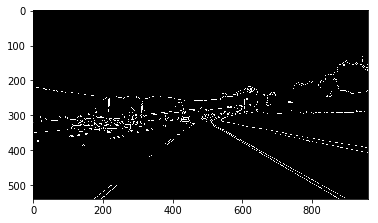

In [35]:
prev_clip_data = [0,0,0,0]
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

current clip data = [-0.61319469681527783, 607.27910610884192, 0.67372463110295311, -20.842869123896552]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|                                                                                                                                                                                                             | 0/682 [00:00<?, ?it/s]

current clip data = [-0.61319469681527794, 607.27910610884192, 0.67372463110295311, -20.842869123896552]


  0%|▎                                                                                                                                                                                                    | 1/682 [00:00<02:05,  5.41it/s]

current clip data = [-0.63499388921591604, 613.52214692630741, 0.68422091736267721, -27.013318121127131]


  0%|▌                                                                                                                                                                                                    | 2/682 [00:00<02:05,  5.41it/s]

ignoring line  [[717 458 763 487]]  as outlier  0.630434782609 5.97826086957
current clip data = [-0.63002201920135159, 613.57832043745532, 0.69367085998575473, -32.264922120444517]


  0%|▊                                                                                                                                                                                                    | 3/682 [00:00<02:15,  5.01it/s]

current clip data = [-0.61816626988299461, 610.59025235988679, 0.6744821240761687, -20.748299098345377]


  1%|█▏                                                                                                                                                                                                   | 4/682 [00:00<02:15,  5.02it/s]

ignoring line  [[819 524 842 538]]  as outlier  0.608695652174 25.4782608696
current clip data = [-0.63869507893678945, 617.11224977650693, 0.66435224586353492, -15.471729152877856]


  1%|█▍                                                                                                                                                                                                   | 5/682 [00:01<02:15,  4.99it/s]

current clip data = [-0.6468785406364177, 621.9273125622185, 0.66711428049160659, -17.880336049914323]


  1%|█▋                                                                                                                                                                                                   | 6/682 [00:01<02:15,  5.00it/s]

ignoring line  [[539 340 622 400]]  as outlier  0.722891566265 -49.6385542169
ignoring line  [[419 355 447 334]]  as outlier  -0.75 669.25
current clip data = [-0.63909221642111314, 620.3850933940729, 0.65735960649956704, -14.179970172667106]


  1%|██                                                                                                                                                                                                   | 7/682 [00:01<02:24,  4.67it/s]

ignoring line  [[368 389 447 334]]  as outlier  -0.696202531646 645.202531646
current clip data = [-0.63953949293349044, 620.66950911796937, 0.65392171253853471, -12.12992684000921]


  1%|██▎                                                                                                                                                                                                  | 8/682 [00:01<02:17,  4.91it/s]

ignoring line  [[409 356 440 334]]  as outlier  -0.709677419355 646.258064516
current clip data = [-0.66002904889796987, 627.22942373433546, 0.65192954727304486, -11.129059385956745]


  1%|██▌                                                                                                                                                                                                  | 9/682 [00:01<02:08,  5.22it/s]

current clip data = [-0.66682294881270798, 630.15343362927842, 0.64638434013478729, -8.7451402772352385]


  1%|██▊                                                                                                                                                                                                 | 10/682 [00:01<02:01,  5.55it/s]

current clip data = [-0.66739440745395673, 629.14647931421268, 0.64212386414688005, -6.8060048744461223]


  2%|███▏                                                                                                                                                                                                | 11/682 [00:02<01:54,  5.87it/s]

ignoring line  [[643 409 683 438]]  as outlier  0.725 -57.175
ignoring line  [[566 354 604 381]]  as outlier  0.710526315789 -48.1578947368
current clip data = [-0.65236378483084945, 624.6862172042114, 0.63314051959319761, -1.4137630229640255]


  2%|███▍                                                                                                                                                                                                | 12/682 [00:02<01:57,  5.73it/s]

ignoring line  [[398 368 442 336]]  as outlier  -0.727272727273 657.454545455
ignoring line  [[398 363 435 337]]  as outlier  -0.702702702703 642.675675676
ignoring line  [[542 338 584 367]]  as outlier  0.690476190476 -36.2380952381
current clip data = [-0.6553441337545729, 626.34487739623114, 0.63542455436706224, -2.657683416849316]


  2%|███▋                                                                                                                                                                                                | 13/682 [00:02<02:02,  5.48it/s]

ignoring line  [[679 434 714 458]]  as outlier  0.685714285714 -31.6
current clip data = [-0.65909293795253576, 627.77669900187868, 0.63903708249006452, -4.771642859859953]


  2%|████                                                                                                                                                                                                | 14/682 [00:02<02:02,  5.46it/s]

ignoring line  [[402 361 435 337]]  as outlier  -0.727272727273 653.363636364
ignoring line  [[541 343 594 374]]  as outlier  0.584905660377 26.5660377358
current clip data = [-0.68239164654738982, 637.52380136379975, 0.63314165990474669, -1.5440362625610273]


  2%|████▎                                                                                                                                                                                               | 15/682 [00:02<02:02,  5.45it/s]

ignoring line  [[274 457 325 419]]  as outlier  -0.745098039216 661.156862745
ignoring line  [[389 375 444 334]]  as outlier  -0.745454545455 664.981818182
current clip data = [-0.67776792753771242, 635.79670440572932, 0.62988082657575539, 2.489681900597259]


  2%|████▌                                                                                                                                                                                               | 16/682 [00:03<02:01,  5.47it/s]

ignoring line  [[542 343 610 382]]  as outlier  0.573529411765 32.1470588235
ignoring line  [[132 538 201 495]]  as outlier  -0.623188405797 620.260869565
current clip data = [-0.68308745895898015, 635.87373209517182, 0.62812376087028032, 3.672720243516598]


  2%|████▉                                                                                                                                                                                               | 17/682 [00:03<01:56,  5.69it/s]

current clip data = [-0.68495879752666244, 636.92059031866484, 0.633627789264956, -0.86700862988749339]


  3%|█████▏                                                                                                                                                                                              | 18/682 [00:03<01:47,  6.15it/s]

ignoring line  [[594 377 621 396]]  as outlier  0.703703703704 -41.0
current clip data = [-0.68438528314656466, 638.82834759466255, 0.6178891634496837, 7.3890763302165725]


  3%|█████▍                                                                                                                                                                                              | 19/682 [00:03<01:45,  6.26it/s]

ignoring line  [[600 380 635 404]]  as outlier  0.685714285714 -31.4285714286
current clip data = [-0.68282157882164229, 636.73589826406544, 0.63038338824549212, 0.71225971048790271]


  3%|█████▋                                                                                                                                                                                              | 20/682 [00:03<01:50,  5.98it/s]

ignoring line  [[535 334 583 367]]  as outlier  0.6875 -33.8125
current clip data = [-0.69118457962353219, 639.96261425703335, 0.62891731731037603, 1.2430206261700936]


  3%|██████                                                                                                                                                                                              | 21/682 [00:03<01:43,  6.39it/s]

current clip data = [-0.68966444925507386, 637.96476469862807, 0.62835489203350314, 0.50217555380590306]


  3%|██████▎                                                                                                                                                                                             | 22/682 [00:03<01:35,  6.93it/s]

current clip data = [-0.6834756740144885, 633.7678188401087, 0.62239159350376594, 3.2889020407976899]


  3%|██████▌                                                                                                                                                                                             | 23/682 [00:04<01:32,  7.12it/s]

ignoring line  [[538 335 573 359]]  as outlier  0.685714285714 -33.9142857143
ignoring line  [[391 367 431 335]]  as outlier  -0.8 679.8
current clip data = [-0.66749767826681572, 628.67427989067926, 0.62602499075281048, 2.7009220221379602]


  4%|██████▉                                                                                                                                                                                             | 24/682 [00:04<01:31,  7.15it/s]

current clip data = [-0.68069646149259067, 635.66325488070072, 0.64653886877260025, -9.230396168254499]


  4%|███████▏                                                                                                                                                                                            | 25/682 [00:04<01:27,  7.54it/s]

ignoring line  [[536 338 587 368]]  as outlier  0.588235294118 22.7058823529
current clip data = [-0.69129374869538318, 640.94201668373637, 0.63604227593332696, -3.0304997206492366]


  4%|███████▍                                                                                                                                                                                            | 26/682 [00:04<01:23,  7.84it/s]

ignoring line  [[201 509 244 477]]  as outlier  -0.744186046512 658.581395349
ignoring line  [[409 355 433 334]]  as outlier  -0.875 712.875
current clip data = [-0.69501792549885566, 643.75102221048098, 0.63446998243891339, -4.170642700769827]


  4%|███████▊                                                                                                                                                                                            | 27/682 [00:04<01:28,  7.39it/s]

ignoring line  [[354 394 434 334]]  as outlier  -0.75 659.5
current clip data = [-0.70182076791695402, 646.86550469739655, 0.6280070813059504, -0.47421764040994002]


  4%|████████                                                                                                                                                                                            | 28/682 [00:04<01:27,  7.45it/s]

ignoring line  [[776 480 861 529]]  as outlier  0.576470588235 32.6588235294
ignoring line  [[351 396 432 335]]  as outlier  -0.753086419753 660.333333333
ignoring line  [[840 518 875 538]]  as outlier  0.571428571429 38.0
current clip data = [-0.70713502854165022, 647.7529379726534, 0.62278343713886408, 2.5983955516783102]


  4%|████████▎                                                                                                                                                                                           | 29/682 [00:04<01:33,  6.96it/s]

current clip data = [-0.69825835517666124, 642.31402007298152, 0.61367757112904286, 6.9798664233671266]


  4%|████████▌                                                                                                                                                                                           | 30/682 [00:04<01:28,  7.33it/s]

ignoring line  [[315 429 417 352]]  as outlier  -0.754901960784 666.794117647
ignoring line  [[351 396 429 337]]  as outlier  -0.75641025641 661.5
ignoring line  [[391 371 423 347]]  as outlier  -0.75 664.25
current clip data = [-0.69166897452061782, 639.35172916114266, 0.61453861424466016, 6.3945233756904081]


  5%|████████▉                                                                                                                                                                                           | 31/682 [00:05<01:30,  7.16it/s]

ignoring line  [[367 385 431 335]]  as outlier  -0.78125 671.71875
ignoring line  [[376 383 416 353]]  as outlier  -0.75 665.0
ignoring line  [[549 340 631 397]]  as outlier  0.69512195122 -41.6219512195
ignoring line  [[291 447 313 430]]  as outlier  -0.772727272727 671.863636364
ignoring line  [[215 502 266 464]]  as outlier  -0.745098039216 662.196078431
current clip data = [-0.6988217628281771, 643.07326372868863, 0.60138695418115207, 12.75608521725794]


  5%|█████████▏                                                                                                                                                                                          | 32/682 [00:05<01:39,  6.53it/s]

ignoring line  [[354 399 420 349]]  as outlier  -0.757575757576 667.181818182
ignoring line  [[395 369 436 334]]  as outlier  -0.853658536585 706.195121951
current clip data = [-0.70442351796927105, 644.66701639212772, 0.61405473961358048, 5.4771758594096216]


  5%|█████████▍                                                                                                                                                                                          | 33/682 [00:05<01:35,  6.82it/s]

ignoring line  [[363 392 427 343]]  as outlier  -0.765625 669.921875
ignoring line  [[352 402 437 334]]  as outlier  -0.8 683.6
current clip data = [-0.71104622681008078, 646.44435417853242, 0.61497554237365604, 4.5381114918631802]


  5%|█████████▊                                                                                                                                                                                          | 34/682 [00:05<01:33,  6.94it/s]

ignoring line  [[349 404 436 334]]  as outlier  -0.804597701149 684.804597701
ignoring line  [[626 393 653 411]]  as outlier  0.666666666667 -24.3333333333
current clip data = [-0.72687249365834927, 652.0681409281276, 0.62132468573019728, -0.49195946597972312]


  5%|██████████                                                                                                                                                                                          | 35/682 [00:05<01:27,  7.37it/s]

ignoring line  [[366 384 430 334]]  as outlier  -0.78125 669.9375
ignoring line  [[550 338 600 373]]  as outlier  0.7 -47.0
current clip data = [-0.73829072129065043, 656.77537197287006, 0.63198238309877874, -5.5001012949046864]


  5%|██████████▎                                                                                                                                                                                         | 36/682 [00:05<01:26,  7.44it/s]

ignoring line  [[657 407 746 458]]  as outlier  0.573033707865 30.5168539326
current clip data = [-0.74686823451632012, 660.52821691765428, 0.62198400832543066, 0.14703565119748668]


  5%|██████████▋                                                                                                                                                                                         | 37/682 [00:05<01:23,  7.76it/s]

current clip data = [-0.74789532401216985, 659.22988930346924, 0.6195379208634163, 1.2217698119643534]


  6%|██████████▉                                                                                                                                                                                         | 38/682 [00:06<01:17,  8.32it/s]

ignoring line  [[339 401 381 372]]  as outlier  -0.690476190476 635.071428571
ignoring line  [[308 423 341 401]]  as outlier  -0.666666666667 628.333333333
ignoring line  [[394 367 428 338]]  as outlier  -0.852941176471 703.058823529
ignoring line  [[367 381 390 365]]  as outlier  -0.695652173913 636.304347826
current clip data = [-0.73627363274584223, 654.825316559199, 0.6074811157060136, 8.943189228887622]


  6%|███████████▏                                                                                                                                                                                        | 39/682 [00:06<01:26,  7.41it/s]

ignoring line  [[322 422 343 405]]  as outlier  -0.809523809524 682.666666667
ignoring line  [[351 400 433 334]]  as outlier  -0.80487804878 682.512195122
ignoring line  [[386 367 426 334]]  as outlier  -0.825 685.45
current clip data = [-0.74076347884243898, 655.66351739510594, 0.59800545744224054, 14.307597925589212]


  6%|███████████▍                                                                                                                                                                                        | 40/682 [00:06<01:25,  7.47it/s]

current clip data = [-0.74013288533915234, 653.34936088280335, 0.60943466318897432, 5.4080247935496679]


  6%|███████████▊                                                                                                                                                                                        | 41/682 [00:06<01:19,  8.08it/s]

current clip data = [-0.75348440814689643, 659.7198263294049, 0.61876088613738678, 0.95201738969314087]


  6%|████████████                                                                                                                                                                                        | 42/682 [00:06<01:14,  8.56it/s]

ignoring line  [[142 538 372 377]]  as outlier  -0.7 637.4
ignoring line  [[144 538 352 392]]  as outlier  -0.701923076923 639.076923077
ignoring line  [[362 383 392 362]]  as outlier  -0.7 636.4
ignoring line  [[399 357 427 334]]  as outlier  -0.821428571429 684.75
current clip data = [-0.76415715423630981, 665.64934456180515, 0.6180107834755979, 1.0973530064273236]


  6%|████████████▎                                                                                                                                                                                       | 43/682 [00:06<01:18,  8.12it/s]

ignoring line  [[143 539 344 398]]  as outlier  -0.701492537313 639.313432836
ignoring line  [[143 538 371 378]]  as outlier  -0.701754385965 638.350877193
ignoring line  [[547 338 624 392]]  as outlier  0.701298701299 -45.6103896104
current clip data = [-0.76300171730667443, 664.25334749842625, 0.60067205840446558, 11.715343169880354]


  6%|████████████▋                                                                                                                                                                                       | 44/682 [00:06<01:20,  7.96it/s]

ignoring line  [[145 538 360 387]]  as outlier  -0.702325581395 639.837209302
ignoring line  [[601 378 636 401]]  as outlier  0.657142857143 -16.9428571429
ignoring line  [[393 362 415 344]]  as outlier  -0.818181818182 683.545454545
current clip data = [-0.76140379661681878, 664.88842754434847, 0.59389759735226011, 16.581350434616677]


  7%|████████████▉                                                                                                                                                                                       | 45/682 [00:06<01:18,  8.15it/s]

ignoring line  [[145 538 357 389]]  as outlier  -0.702830188679 639.910377358
ignoring line  [[308 423 398 359]]  as outlier  -0.711111111111 642.022222222
current clip data = [-0.76019647523989398, 664.81538581351367, 0.6119987625717298, 8.332214685066667]


  7%|█████████████▏                                                                                                                                                                                      | 46/682 [00:07<01:20,  7.93it/s]

ignoring line  [[145 539 327 411]]  as outlier  -0.703296703297 640.978021978
ignoring line  [[405 357 425 343]]  as outlier  -0.7 640.5
ignoring line  [[315 418 357 389]]  as outlier  -0.690476190476 635.5
current clip data = [-0.7538564788339156, 662.08561625874518, 0.61435757259646606, 7.779819196811796]


  7%|█████████████▌                                                                                                                                                                                      | 47/682 [00:07<01:18,  8.05it/s]

ignoring line  [[145 538 374 377]]  as outlier  -0.703056768559 639.943231441
ignoring line  [[146 538 327 411]]  as outlier  -0.701657458564 640.44198895
ignoring line  [[146 539 267 454]]  as outlier  -0.702479338843 641.561983471
current clip data = [-0.74182554747978213, 656.62366057246379, 0.60889502501724779, 10.761043398104555]


  7%|█████████████▊                                                                                                                                                                                      | 48/682 [00:07<01:20,  7.91it/s]

ignoring line  [[269 462 298 439]]  as outlier  -0.793103448276 675.344827586
current clip data = [-0.74291602500327492, 655.84874927867929, 0.62512056291350859, 0.57351860953454015]


  7%|██████████████                                                                                                                                                                                      | 49/682 [00:07<01:15,  8.43it/s]

current clip data = [-0.73721288303803689, 653.53913070941292, 0.61061275936894299, 9.0565645188591635]
current clip data = [-0.72149136662084923, 646.34838863312655, 0.60936168840809479, 9.6182536796066511]


  7%|██████████████▋                                                                                                                                                                                     | 51/682 [00:07<01:08,  9.23it/s]

current clip data = [-0.74128320721805674, 651.80460070825882, 0.59618004212134879, 19.111055321471621]
current clip data = [-0.72904129538615958, 650.17637030552271, 0.62102026882018224, 2.9247860932549687]


  8%|███████████████▏                                                                                                                                                                                    | 53/682 [00:07<01:03,  9.97it/s]

current clip data = [-0.72718780584625209, 650.09154351796337, 0.61206498101223239, 10.822569200199453]
current clip data = [-0.73133194325664519, 649.45444732823557, 0.60298130092739888, 16.379454383481239]


  8%|███████████████▊                                                                                                                                                                                    | 55/682 [00:07<00:59, 10.46it/s]

ignoring line  [[158 526 277 445]]  as outlier  -0.680672268908 633.546218487
current clip data = [-0.72014669866173242, 649.41382181865276, 0.60262388648540988, 16.032096501853779]
ignoring line  [[534 334 573 360]]  as outlier  0.666666666667 -22.0
current clip data = [-0.72503759990764038, 649.56959615457743, 0.60948199654841817, 12.227970102510232]


  8%|████████████████▍                                                                                                                                                                                   | 57/682 [00:08<00:59, 10.56it/s]

current clip data = [-0.717584127875739, 648.84405892692962, 0.61563320495047746, 9.1171442915827861]
current clip data = [-0.719359973809511, 648.10591915441444, 0.615069124012119, 9.1987120323152265]


  9%|████████████████▉                                                                                                                                                                                   | 59/682 [00:08<00:56, 11.02it/s]

current clip data = [-0.72632746387813774, 649.77571929935164, 0.62811327740251921, 1.5357456048677838]
current clip data = [-0.71113559700758511, 646.48477852785413, 0.61474890758592338, 9.900480518864379]


  9%|█████████████████▌                                                                                                                                                                                  | 61/682 [00:08<00:53, 11.56it/s]

ignoring line  [[644 408 693 441]]  as outlier  0.673469387755 -25.7142857143
ignoring line  [[546 341 573 360]]  as outlier  0.703703703704 -43.2222222222
current clip data = [-0.70821698277433442, 642.31693975689302, 0.60799043192368796, 13.372535128163724]
current clip data = [-0.70712529352291431, 638.66202618850673, 0.60853091628908185, 13.264090528017185]


  9%|██████████████████                                                                                                                                                                                  | 63/682 [00:08<00:53, 11.64it/s]

current clip data = [-0.70243405749494359, 638.22087517649391, 0.6099163526885002, 11.971616466785562]
ignoring line  [[186 517 215 495]]  as outlier  -0.758620689655 658.103448276
current clip data = [-0.71439417857666221, 644.28854151153257, 0.60496399927558464, 15.569311653990601]


 10%|██████████████████▋                                                                                                                                                                                 | 65/682 [00:08<00:52, 11.82it/s]

ignoring line  [[534 339 588 375]]  as outlier  0.666666666667 -17.0
current clip data = [-0.70981214914763446, 642.06488426183739, 0.6128113782110044, 11.286267792884734]
current clip data = [-0.70620201104990032, 641.98842554791565, 0.61805060710455362, 7.9035340836238781]


 10%|███████████████████▎                                                                                                                                                                                | 67/682 [00:08<00:50, 12.16it/s]

ignoring line  [[538 342 602 385]]  as outlier  0.671875 -19.46875
current clip data = [-0.70692927404018968, 641.56289202057621, 0.62253057903956788, 5.731202844552679]
current clip data = [-0.70693565073688325, 642.12599109633322, 0.62685933473658095, 4.6469615502996877]


 10%|███████████████████▊                                                                                                                                                                                | 69/682 [00:09<00:48, 12.57it/s]

ignoring line  [[594 378 622 397]]  as outlier  0.678571428571 -25.0714285714
current clip data = [-0.70320286054735381, 640.53530714673627, 0.64885917370145951, -8.6532135271667716]
ignoring line  [[604 382 649 408]]  as outlier  0.577777777778 33.0222222222
ignoring line  [[606 382 649 407]]  as outlier  0.581395348837 29.6744186047
current clip data = [-0.69846134064667087, 639.56492136307838, 0.63563536377428143, -1.1906420067821928]


 10%|████████████████████▍                                                                                                                                                                               | 71/682 [00:09<00:49, 12.32it/s]

ignoring line  [[176 525 205 503]]  as outlier  -0.758620689655 658.517241379
current clip data = [-0.70272967832282374, 641.43017071853103, 0.62924058790318527, 3.1497614229755797]
ignoring line  [[338 409 367 387]]  as outlier  -0.758620689655 665.413793103
ignoring line  [[625 395 680 426]]  as outlier  0.563636363636 42.7272727273
ignoring line  [[369 387 438 335]]  as outlier  -0.753623188406 665.086956522
current clip data = [-0.69989306478012836, 641.2919216663272, 0.6352876399227021, 0.56818995793829785]


 11%|████████████████████▉                                                                                                                                                                               | 73/682 [00:09<00:51, 11.83it/s]

ignoring line  [[631 403 670 430]]  as outlier  0.692307692308 -33.8461538462
ignoring line  [[402 358 431 335]]  as outlier  -0.793103448276 676.827586207
current clip data = [-0.69622652752852388, 641.02313877581594, 0.63286886992875002, 1.230918966456193]
current clip data = [-0.70695790392108759, 642.43684566294587, 0.63151573741699296, 2.6759225106954183]


 11%|█████████████████████▌                                                                                                                                                                              | 75/682 [00:09<00:51, 11.82it/s]

ignoring line  [[331 417 363 391]]  as outlier  -0.8125 685.9375
ignoring line  [[392 365 426 339]]  as outlier  -0.764705882353 664.764705882
ignoring line  [[373 385 393 369]]  as outlier  -0.8 683.4
ignoring line  [[300 438 327 417]]  as outlier  -0.777777777778 671.333333333
ignoring line  [[719 461 754 485]]  as outlier  0.685714285714 -32.0285714286
current clip data = [-0.70633773926139376, 644.08645130542334, 0.63814941086947741, -0.83631753644120521]
current clip data = [-0.72034264014306826, 650.53063769216772, 0.64024620793800391, -1.2290970588571934]


 11%|██████████████████████▏                                                                                                                                                                             | 77/682 [00:09<00:54, 11.20it/s]

current clip data = [-0.70905524570642708, 643.69131869184753, 0.62568503424691591, 7.0530183094816072]
current clip data = [-0.71439253309827566, 644.85578045941827, 0.62603411635453687, 6.686592203667229]


 12%|██████████████████████▋                                                                                                                                                                             | 79/682 [00:09<00:49, 12.16it/s]

current clip data = [-0.6996217117011998, 643.16568684995195, 0.62227409291477342, 8.7221234152957337]
current clip data = [-0.70632262792196476, 642.92326075291828, 0.63743912765268673, -0.10705554266417749]


 12%|███████████████████████▎                                                                                                                                                                            | 81/682 [00:10<00:47, 12.57it/s]

ignoring line  [[535 336 618 396]]  as outlier  0.722891566265 -50.7469879518
current clip data = [-0.70654635679235345, 641.82654654264149, 0.64468598221256523, -4.5536876062287721]
ignoring line  [[536 337 628 403]]  as outlier  0.717391304348 -47.5217391304
current clip data = [-0.70187834539137561, 640.59829365100734, 0.61996203872533084, 9.1398228635519025]


 12%|███████████████████████▊                                                                                                                                                                            | 83/682 [00:10<00:48, 12.33it/s]

current clip data = [-0.7033272840379724, 640.68094688945803, 0.62745779541435331, 5.1033452098367666]
ignoring line  [[526 334 576 368]]  as outlier  0.68 -23.68
current clip data = [-0.71069912637672161, 643.6314348571035, 0.62364004798212835, 7.1048123373177035]


 12%|████████████████████████▍                                                                                                                                                                           | 85/682 [00:10<00:47, 12.54it/s]

ignoring line  [[154 539 185 515]]  as outlier  -0.774193548387 658.225806452
current clip data = [-0.69354917567759167, 638.55556994989468, 0.63938095593796895, -1.650295457377581]
ignoring line  [[543 342 587 373]]  as outlier  0.704545454545 -40.5681818182
current clip data = [-0.70687982227845736, 643.39634048969435, 0.62895926268667124, 4.3790517049552387]


 13%|█████████████████████████                                                                                                                                                                           | 87/682 [00:10<00:47, 12.46it/s]

current clip data = [-0.69372406139161491, 638.37234004158609, 0.62188275650391323, 8.5667558030303006]
current clip data = [-0.68638226920056233, 635.5688897970623, 0.62766136773544934, 5.1089863025018616]


 13%|█████████████████████████▌                                                                                                                                                                          | 89/682 [00:10<00:46, 12.62it/s]

current clip data = [-0.68202626811868949, 633.61123270626399, 0.62467445278562328, 8.5890829565519962]
ignoring line  [[555 350 589 373]]  as outlier  0.676470588235 -25.4411764706
current clip data = [-0.68442101024140112, 632.63997625154707, 0.62678740175539038, 8.2981796680227369]


 13%|██████████████████████████▏                                                                                                                                                                         | 91/682 [00:10<00:45, 12.90it/s]

current clip data = [-0.68774746895962524, 636.3497553830864, 0.63835852310142804, 0.67965777045949882]
current clip data = [-0.68443796353059927, 637.26622443516544, 0.63081566953353285, 6.2230972063222758]


 14%|██████████████████████████▋                                                                                                                                                                         | 93/682 [00:10<00:45, 12.93it/s]

current clip data = [-0.68645681164866523, 639.3034312850051, 0.65066877148873492, -5.3469430290288562]
ignoring line  [[591 378 622 396]]  as outlier  0.58064516129 34.8387096774
current clip data = [-0.68193268825014475, 639.39658846027146, 0.66491826433136991, -13.212421869890983]


 14%|███████████████████████████▎                                                                                                                                                                        | 95/682 [00:11<00:44, 13.13it/s]

ignoring line  [[281 452 331 415]]  as outlier  -0.74 659.94
ignoring line  [[597 382 634 404]]  as outlier  0.594594594595 27.027027027
current clip data = [-0.68824817886789069, 639.78291502170839, 0.65219497699934337, -6.3208072899622287]
current clip data = [-0.68878954193680642, 639.99125340388048, 0.65433275785527711, -8.0753123667076103]


 14%|███████████████████████████▉                                                                                                                                                                        | 97/682 [00:11<00:46, 12.70it/s]

ignoring line  [[548 353 578 371]]  as outlier  0.6 24.2
current clip data = [-0.68715877198700304, 640.38526396523412, 0.65237062052234718, -6.9655525265554763]
current clip data = [-0.68919379752508303, 640.26243530257102, 0.63752356589075365, 0.98666620920217984]


 15%|████████████████████████████▍                                                                                                                                                                       | 99/682 [00:11<00:44, 12.96it/s]

current clip data = [-0.69009024556880783, 642.57002012874693, 0.63962386853260056, -0.89508003116111501]
current clip data = [-0.68959017611586049, 639.48391515167464, 0.63584750026707082, 1.410536727349764]


 15%|████████████████████████████▉                                                                                                                                                                      | 101/682 [00:11<00:44, 12.98it/s]

current clip data = [-0.6917975539011707, 641.58080632377425, 0.64243659329112945, -1.6599064120726463]
current clip data = [-0.6965899807403515, 640.64103264425125, 0.638204806461249, 0.15499890448977563]


 15%|█████████████████████████████▍                                                                                                                                                                     | 103/682 [00:11<00:42, 13.58it/s]

current clip data = [-0.68903177652185432, 638.05269167086931, 0.64152179547694654, -1.1633693617017049]
current clip data = [-0.68441425186696003, 635.8846544963543, 0.6329704598436604, 4.2155125353813503]


 15%|██████████████████████████████                                                                                                                                                                     | 105/682 [00:11<00:41, 13.84it/s]

ignoring line  [[404 362 441 334]]  as outlier  -0.756756756757 667.72972973
ignoring line  [[182 538 220 507]]  as outlier  -0.815789473684 686.473684211
current clip data = [-0.67666338444606133, 632.48014914918576, 0.63714904105531378, 0.85148857469013917]
current clip data = [-0.68206954130172071, 634.22463285472884, 0.64349412479621548, -3.1695038084364682]


 16%|██████████████████████████████▌                                                                                                                                                                    | 107/682 [00:12<00:43, 13.34it/s]

ignoring line  [[591 377 624 396]]  as outlier  0.575757575758 36.7272727273
ignoring line  [[594 377 627 396]]  as outlier  0.575757575758 35.0
ignoring line  [[593 377 627 397]]  as outlier  0.588235294118 28.1764705882
current clip data = [-0.68446966059600667, 635.34384788920499, 0.65193574164339263, -7.1319217155402281]
ignoring line  [[599 382 637 404]]  as outlier  0.578947368421 35.2105263158
current clip data = [-0.6992971807458408, 642.19584120017805, 0.65586385416252713, -9.8684890637841001]


 16%|███████████████████████████████▏                                                                                                                                                                   | 109/682 [00:12<00:45, 12.46it/s]

ignoring line  [[264 452 322 415]]  as outlier  -0.637931034483 620.413793103
ignoring line  [[609 388 654 415]]  as outlier  0.6 22.6
ignoring line  [[308 423 340 403]]  as outlier  -0.625 615.5
ignoring line  [[526 336 580 368]]  as outlier  0.592592592593 24.2962962963
ignoring line  [[405 363 443 334]]  as outlier  -0.763157894737 672.078947368
ignoring line  [[136 537 186 505]]  as outlier  -0.64 624.04
current clip data = [-0.68226199968099466, 636.55737806820048, 0.64936049850983502, -4.0771016747492439]
ignoring line  [[399 368 443 334]]  as outlier  -0.772727272727 676.318181818
ignoring line  [[383 374 437 334]]  as outlier  -0.740740740741 657.703703704
current clip data = [-0.66633681637396669, 631.59290436698996, 0.63937126212096407, 1.465854585812437]


 16%|███████████████████████████████▋                                                                                                                                                                   | 111/682 [00:12<00:50, 11.29it/s]

ignoring line  [[629 401 695 439]]  as outlier  0.575757575758 38.8484848485
ignoring line  [[626 402 669 432]]  as outlier  0.697674418605 -34.7441860465
ignoring line  [[631 401 672 425]]  as outlier  0.585365853659 31.6341463415
current clip data = [-0.67147204225245982, 632.54845854876214, 0.65172024526839178, -4.6341888222732104]
current clip data = [-0.6869885510339081, 638.64299893912516, 0.6589793975313879, -11.92162077894074]


 17%|████████████████████████████████▎                                                                                                                                                                  | 113/682 [00:12<00:49, 11.44it/s]

ignoring line  [[389 375 434 336]]  as outlier  -0.866666666667 712.133333333
current clip data = [-0.68465260206854262, 638.59834932016486, 0.63920480224226561, -0.01363080658530055]
current clip data = [-0.68208894760883654, 636.74578095017193, 0.6366688197923126, 0.74732054517396274]


 17%|████████████████████████████████▉                                                                                                                                                                  | 115/682 [00:12<00:48, 11.59it/s]

ignoring line  [[401 366 421 350]]  as outlier  -0.8 686.8
current clip data = [-0.68292745667461963, 637.00888856702636, 0.64513026410185048, -5.3711705498283173]
current clip data = [-0.68815034938824349, 638.04196672034482, 0.63380830534386401, 2.6945487392483671]


 17%|█████████████████████████████████▍                                                                                                                                                                 | 117/682 [00:12<00:47, 11.96it/s]

current clip data = [-0.68787495665796594, 639.34374832343872, 0.63232347318781534, 3.4725605528378543]
ignoring line  [[827 519 860 538]]  as outlier  0.575757575758 42.8484848485
current clip data = [-0.69702531391843581, 642.9896416035084, 0.62035720657969606, 8.9996190080958449]


 17%|██████████████████████████████████                                                                                                                                                                 | 119/682 [00:13<00:45, 12.40it/s]

current clip data = [-0.70029964621987117, 643.69170755819914, 0.62512335119715023, 5.5735508907184572]
ignoring line  [[162 537 191 515]]  as outlier  -0.758620689655 659.896551724
current clip data = [-0.70865393923361719, 646.57104599748777, 0.62885635449245114, 3.9279664190230967]


 18%|██████████████████████████████████▌                                                                                                                                                                | 121/682 [00:13<00:45, 12.36it/s]

ignoring line  [[531 334 581 368]]  as outlier  0.68 -27.08
current clip data = [-0.69483552838510931, 641.63717374649332, 0.62440188003115182, 7.2027034667168826]
current clip data = [-0.70065782899302453, 644.31580703386112, 0.6379165833386089, -0.88418167422628358]


 18%|███████████████████████████████████▏                                                                                                                                                               | 123/682 [00:13<00:44, 12.55it/s]

ignoring line  [[532 336 589 376]]  as outlier  0.701754385965 -37.3333333333
ignoring line  [[533 336 591 376]]  as outlier  0.689655172414 -31.5862068966
current clip data = [-0.69352372377434879, 641.10476380851799, 0.63242605954585029, 3.5502143899491743]
current clip data = [-0.70029497489481873, 644.07307745995581, 0.62327520593097396, 8.030801117150137]


 18%|███████████████████████████████████▋                                                                                                                                                               | 125/682 [00:13<00:44, 12.48it/s]

current clip data = [-0.70832886665985895, 646.28720066556832, 0.61567451192539535, 12.608935300074467]
current clip data = [-0.71373783409221137, 648.24617626795464, 0.636198969072297, 0.50872982568195291]


 19%|████████████████████████████████████▎                                                                                                                                                              | 127/682 [00:13<00:42, 12.92it/s]

current clip data = [-0.70117132700925555, 644.78740505977714, 0.63333207543186654, 2.8760930923466672]
current clip data = [-0.70719103149804763, 648.37719235901625, 0.63066670026516736, 4.7679460785661707]


 19%|████████████████████████████████████▉                                                                                                                                                              | 129/682 [00:13<00:42, 13.11it/s]

current clip data = [-0.69655053005673384, 644.35143568243973, 0.62302859567078106, 8.9410475964076515]
current clip data = [-0.69835011851925022, 644.98120232559347, 0.61920764933793615, 12.648561252942704]


 19%|█████████████████████████████████████▍                                                                                                                                                             | 131/682 [00:13<00:41, 13.22it/s]

ignoring line  [[526 335 612 393]]  as outlier  0.674418604651 -19.7441860465
current clip data = [-0.69232651820491697, 641.7205005469358, 0.62082454753464467, 8.5018212032806044]
ignoring line  [[223 496 293 444]]  as outlier  -0.742857142857 661.657142857
ignoring line  [[163 539 200 511]]  as outlier  -0.756756756757 662.351351351
current clip data = [-0.70024873681899935, 644.06543604330977, 0.62283807868125407, 7.5641472275630486]


 20%|██████████████████████████████████████                                                                                                                                                             | 133/682 [00:14<00:42, 12.79it/s]

current clip data = [-0.69720426966101579, 644.71576951971781, 0.63965110928624602, -1.3039423005067117]
current clip data = [-0.69849789506017357, 644.5347260938297, 0.63723734769459306, 0.34587452384391487]


 20%|██████████████████████████████████████▌                                                                                                                                                            | 135/682 [00:14<00:42, 12.86it/s]

current clip data = [-0.68780447142313517, 640.27422389421463, 0.63825052381692637, -0.76762937032004075]
current clip data = [-0.70043701872044906, 643.63522193271331, 0.64257545146705253, -2.4963945220673533]


 20%|███████████████████████████████████████▏                                                                                                                                                           | 137/682 [00:14<00:41, 13.07it/s]

current clip data = [-0.70928196159768009, 647.88165033095277, 0.6327634033838283, 2.991727843225179]
ignoring line  [[667 421 722 453]]  as outlier  0.581818181818 32.9272727273
current clip data = [-0.70244630801407082, 646.39792203221725, 0.61463429121022151, 12.891796301559317]


 20%|███████████████████████████████████████▋                                                                                                                                                           | 139/682 [00:14<00:40, 13.48it/s]

ignoring line  [[730 468 797 513]]  as outlier  0.671641791045 -22.2985074627
current clip data = [-0.69427387686511843, 641.72160652551531, 0.62654200486566491, 6.2370820206028448]
current clip data = [-0.69896161900881737, 642.16746967634094, 0.62879533908077379, 4.6130692074325674]


 21%|████████████████████████████████████████▎                                                                                                                                                          | 141/682 [00:14<00:41, 13.10it/s]

current clip data = [-0.70025595921303296, 645.37996317111197, 0.62800817122144115, 6.1523467151430502]
ignoring line  [[771 494 837 539]]  as outlier  0.681818181818 -31.6818181818
ignoring line  [[332 418 365 393]]  as outlier  -0.757575757576 669.515151515
current clip data = [-0.70789057178933867, 645.94489492400737, 0.63153123096335917, 3.2942082357147178]


 21%|████████████████████████████████████████▉                                                                                                                                                          | 143/682 [00:14<00:41, 13.07it/s]

ignoring line  [[142 538 206 496]]  as outlier  -0.65625 631.1875
current clip data = [-0.71010446292905527, 646.87485594830594, 0.63746766437015989, -0.24932806917867012]
ignoring line  [[144 538 176 517]]  as outlier  -0.65625 632.5
current clip data = [-0.69721911325982366, 644.19308128238526, 0.63177060660675166, 4.302812957592284]


 21%|█████████████████████████████████████████▍                                                                                                                                                         | 145/682 [00:15<00:41, 12.83it/s]

current clip data = [-0.69232160483455696, 642.14780783873562, 0.62263080678795557, 9.6259521911804828]
current clip data = [-0.70123034068900791, 643.99013637498228, 0.62604494803861932, 7.0961529955609643]


 22%|██████████████████████████████████████████                                                                                                                                                         | 147/682 [00:15<00:41, 12.88it/s]

current clip data = [-0.70556782824367337, 644.01830135515343, 0.60793356620677941, 17.499401337107212]
ignoring line  [[630 398 666 418]]  as outlier  0.555555555556 48.0
current clip data = [-0.70186757722605353, 645.11872486047969, 0.61255809647438486, 14.653364815899067]


 22%|██████████████████████████████████████████▌                                                                                                                                                        | 149/682 [00:15<00:40, 13.09it/s]

current clip data = [-0.6972019329570992, 643.17689821541421, 0.62314188048325103, 7.1843041804180157]
current clip data = [-0.69788626156018674, 645.16613774018276, 0.62079855590765975, 8.7037356269334296]


 22%|███████████████████████████████████████████▏                                                                                                                                                       | 151/682 [00:15<00:40, 13.07it/s]

current clip data = [-0.68285480737954873, 638.89413725165946, 0.61576021518280855, 12.2966556013066]
ignoring line  [[690 440 758 486]]  as outlier  0.676470588235 -26.7647058824
ignoring line  [[394 373 444 334]]  as outlier  -0.78 680.32
ignoring line  [[691 442 714 458]]  as outlier  0.695652173913 -38.6956521739
current clip data = [-0.67844178207838524, 637.56792909435774, 0.62380668271707029, 7.6249989521321666]


 22%|███████████████████████████████████████████▋                                                                                                                                                       | 153/682 [00:15<00:41, 12.66it/s]

ignoring line  [[235 489 318 427]]  as outlier  -0.746987951807 664.542168675
current clip data = [-0.69717933020061063, 646.28608201569295, 0.62170795550838243, 9.1583712395023031]
current clip data = [-0.69029054034650028, 644.5362617796261, 0.61485743867456466, 12.431274724014814]


 23%|████████████████████████████████████████████▎                                                                                                                                                      | 155/682 [00:15<00:40, 12.93it/s]

current clip data = [-0.69069271579287506, 644.56622840219256, 0.6144437827721958, 13.844549377888566]
ignoring line  [[169 539 233 491]]  as outlier  -0.75 665.75
current clip data = [-0.69014317490427235, 647.05817770295573, 0.61275161345440554, 14.930759676163975]


 23%|████████████████████████████████████████████▉                                                                                                                                                      | 157/682 [00:16<00:40, 12.96it/s]

ignoring line  [[604 383 636 401]]  as outlier  0.5625 43.25
current clip data = [-0.69467954220415629, 649.27985080211715, 0.60749264670343106, 19.078433908645568]
ignoring line  [[172 538 231 494]]  as outlier  -0.745762711864 666.271186441
ignoring line  [[404 372 455 334]]  as outlier  -0.745098039216 673.019607843
ignoring line  [[197 520 230 495]]  as outlier  -0.757575757576 669.242424242
current clip data = [-0.69300238817894055, 648.40950662728608, 0.58978784259490358, 29.74917661342209]


 23%|█████████████████████████████████████████████▍                                                                                                                                                     | 159/682 [00:16<00:43, 11.89it/s]

ignoring line  [[423 355 448 336]]  as outlier  -0.76 676.48
ignoring line  [[407 366 450 334]]  as outlier  -0.744186046512 668.88372093
current clip data = [-0.69280920107804023, 650.60303555559642, 0.59520166073968039, 26.191351503817934]
ignoring line  [[395 379 455 334]]  as outlier  -0.75 675.25
ignoring line  [[410 369 455 335]]  as outlier  -0.755555555556 678.777777778
current clip data = [-0.70014974584748213, 652.14700864982115, 0.60184498955947496, 21.556746706253367]


 24%|██████████████████████████████████████████████                                                                                                                                                     | 161/682 [00:16<00:44, 11.68it/s]

ignoring line  [[551 350 574 365]]  as outlier  0.652173913043 -9.34782608696
current clip data = [-0.69591312371842651, 650.500875971048, 0.59429742834898025, 26.140907285545065]
current clip data = [-0.70761436668406874, 652.5915700281314, 0.59544233359574916, 24.05181576252367]


 24%|██████████████████████████████████████████████▌                                                                                                                                                    | 163/682 [00:16<00:44, 11.72it/s]

ignoring line  [[517 334 587 372]]  as outlier  0.542857142857 53.3428571429
current clip data = [-0.71785157768508712, 658.49023508827156, 0.58894053798806423, 27.213256856709688]
current clip data = [-0.70685780161561451, 653.90491909990271, 0.59063113065200779, 27.337661103983788]


 24%|███████████████████████████████████████████████▏                                                                                                                                                   | 165/682 [00:16<00:42, 12.08it/s]

current clip data = [-0.69814604782271916, 650.7951770493321, 0.58234982834253168, 31.027663905795009]
current clip data = [-0.7095451903015908, 654.26304306040095, 0.58545300284067547, 28.321176041142326]


 24%|███████████████████████████████████████████████▋                                                                                                                                                   | 167/682 [00:16<00:41, 12.50it/s]

current clip data = [-0.716402423205315, 657.7750193972372, 0.58969016209077241, 26.373765540151503]
current clip data = [-0.7142975433900195, 657.8979608760834, 0.5988891502658239, 19.917704983740926]


 25%|████████████████████████████████████████████████▎                                                                                                                                                  | 169/682 [00:17<00:40, 12.65it/s]

ignoring line  [[554 349 580 366]]  as outlier  0.653846153846 -13.2307692308
current clip data = [-0.71488880134078858, 657.703481305119, 0.58746109511546096, 26.180006903900313]
ignoring line  [[189 532 232 499]]  as outlier  -0.767441860465 677.046511628
ignoring line  [[611 383 649 403]]  as outlier  0.526315789474 61.4210526316
current clip data = [-0.72255390826295385, 661.92871241370062, 0.57731399172758291, 32.729937623411203]


 25%|████████████████████████████████████████████████▉                                                                                                                                                  | 171/682 [00:17<00:41, 12.36it/s]

ignoring line  [[381 385 447 334]]  as outlier  -0.772727272727 679.409090909
current clip data = [-0.73916672654278126, 668.04381573296234, 0.56832154916668487, 37.206143013009672]
ignoring line  [[562 353 592 372]]  as outlier  0.633333333333 -2.93333333333
ignoring line  [[536 339 594 375]]  as outlier  0.620689655172 6.31034482759
current clip data = [-0.7294207739443479, 665.04147258102137, 0.56931604655924173, 36.820689550861353]


 25%|█████████████████████████████████████████████████▍                                                                                                                                                 | 173/682 [00:17<00:42, 11.99it/s]

ignoring line  [[338 423 452 334]]  as outlier  -0.780701754386 686.877192982
ignoring line  [[293 457 332 426]]  as outlier  -0.794871794872 689.897435897
ignoring line  [[638 402 694 437]]  as outlier  0.625 3.25
ignoring line  [[275 470 307 445]]  as outlier  -0.78125 684.84375
ignoring line  [[637 400 669 420]]  as outlier  0.625 1.875
current clip data = [-0.73881614738093759, 667.7693297786567, 0.58973160904240807, 24.029847712390438]
ignoring line  [[408 369 448 336]]  as outlier  -0.825 705.6
current clip data = [-0.73066133555532364, 664.20465467410338, 0.58651982616741194, 25.859129084802039]


 26%|██████████████████████████████████████████████████                                                                                                                                                 | 175/682 [00:17<00:44, 11.31it/s]

current clip data = [-0.73423245577168372, 665.59351734965026, 0.57556786104728686, 31.114526002437742]
current clip data = [-0.75463981607131891, 675.41519317693383, 0.58277971681730723, 26.680871449229269]


 26%|██████████████████████████████████████████████████▌                                                                                                                                                | 177/682 [00:17<00:42, 11.87it/s]

current clip data = [-0.74930744874872046, 674.89177358516633, 0.57142361980958634, 33.457838821226396]
ignoring line  [[526 338 607 378]]  as outlier  0.493827160494 78.2469135802
current clip data = [-0.75516758342920953, 675.92175739671279, 0.57992012120673841, 29.976613721463323]


 26%|███████████████████████████████████████████████████▏                                                                                                                                               | 179/682 [00:17<00:41, 12.26it/s]

ignoring line  [[526 337 615 384]]  as outlier  0.52808988764 59.2247191011
current clip data = [-0.75490068042952618, 675.36327832184554, 0.56084123385546358, 41.806645700625957]
current clip data = [-0.75497014249550365, 674.67939074878439, 0.56338708933649728, 38.98697504490125]


 27%|███████████████████████████████████████████████████▊                                                                                                                                               | 181/682 [00:18<00:40, 12.49it/s]

ignoring line  [[601 376 637 394]]  as outlier  0.5 75.5
current clip data = [-0.74231841777198448, 669.4360439522361, 0.56294354466824958, 40.024737522449996]
current clip data = [-0.76240209732924136, 676.60797827671502, 0.56532333113709732, 38.507297377530399]


 27%|████████████████████████████████████████████████████▎                                                                                                                                              | 183/682 [00:18<00:38, 12.80it/s]

ignoring line  [[171 538 209 512]]  as outlier  -0.684210526316 655.0
ignoring line  [[196 520 232 495]]  as outlier  -0.694444444444 656.111111111
current clip data = [-0.75369739626462884, 674.85565606796047, 0.54857143424792743, 48.21260197303431]
ignoring line  [[533 339 591 374]]  as outlier  0.603448275862 17.3620689655
current clip data = [-0.7615833992321932, 677.76526750569383, 0.54745375521525363, 49.701615742431215]


 27%|████████████████████████████████████████████████████▉                                                                                                                                              | 185/682 [00:18<00:39, 12.49it/s]

ignoring line  [[634 400 669 421]]  as outlier  0.6 19.6
ignoring line  [[376 388 403 369]]  as outlier  -0.703703703704 652.592592593
ignoring line  [[634 399 678 426]]  as outlier  0.613636363636 9.95454545455
ignoring line  [[397 372 417 358]]  as outlier  -0.7 649.9
current clip data = [-0.75091787252164066, 673.66249835712802, 0.56495055046511289, 39.168507748181121]
current clip data = [-0.75559295553954464, 674.97484592358319, 0.56519819880796029, 40.596516291971682]


 27%|█████████████████████████████████████████████████████▍                                                                                                                                             | 187/682 [00:18<00:41, 11.94it/s]

ignoring line  [[364 405 452 334]]  as outlier  -0.806818181818 698.681818182
ignoring line  [[370 400 434 347]]  as outlier  -0.828125 706.40625
ignoring line  [[371 399 397 377]]  as outlier  -0.846153846154 712.923076923
current clip data = [-0.7745303375260546, 681.68738509768025, 0.55986708366076776, 42.448491337866741]
current clip data = [-0.76925858839077077, 680.06837693617751, 0.54827086345152154, 49.728282181756278]


 28%|██████████████████████████████████████████████████████                                                                                                                                             | 189/682 [00:18<00:42, 11.71it/s]

current clip data = [-0.76693903389958251, 679.52307932526639, 0.55508543671516952, 44.280191223858495]
ignoring line  [[392 382 444 339]]  as outlier  -0.826923076923 706.153846154
current clip data = [-0.77329973041461875, 681.40164653831562, 0.56159079378907839, 41.598037340634654]


 28%|██████████████████████████████████████████████████████▌                                                                                                                                            | 191/682 [00:18<00:39, 12.43it/s]

ignoring line  [[219 519 244 498]]  as outlier  -0.84 702.96
current clip data = [-0.77815932855517933, 680.53718765281417, 0.55900738306526709, 44.474137919138727]
ignoring line  [[408 366 441 342]]  as outlier  -0.727272727273 662.727272727
current clip data = [-0.76799009463456458, 677.50066756778642, 0.55596787529878899, 46.494959830569044]


 28%|███████████████████████████████████████████████████████▏                                                                                                                                           | 193/682 [00:18<00:39, 12.38it/s]

current clip data = [-0.77375610342700185, 681.87667123488075, 0.5509020394686841, 48.53709750251631]
current clip data = [-0.78943245845729371, 684.400829341036, 0.54923340762470241, 49.264965908897288]


 29%|███████████████████████████████████████████████████████▊                                                                                                                                           | 195/682 [00:19<00:37, 12.95it/s]

current clip data = [-0.79094453330987347, 686.065356170222, 0.55608267361459052, 45.554483978392533]
current clip data = [-0.77527004376390507, 681.13827185945968, 0.571683244811374, 36.954703577753897]


 29%|████████████████████████████████████████████████████████▎                                                                                                                                          | 197/682 [00:19<00:37, 13.06it/s]

current clip data = [-0.77041978582898307, 678.61243527463535, 0.56257181434731807, 42.458672076060381]
ignoring line  [[344 417 401 370]]  as outlier  -0.824561403509 700.649122807
ignoring line  [[408 366 444 334]]  as outlier  -0.888888888889 728.666666667
current clip data = [-0.75200230759303588, 670.23632842916334, 0.54317720523782775, 54.474826920862675]


 29%|████████████████████████████████████████████████████████▉                                                                                                                                          | 199/682 [00:19<00:37, 12.83it/s]

ignoring line  [[647 411 721 455]]  as outlier  0.594594594595 26.2972972973
ignoring line  [[745 493 778 493]]  as outlier  2.79685035372e-15 493.0
ignoring line  [[745 491 791 489]]  as outlier  -0.0434782608696 523.391304348
current clip data = [-0.74811163908606393, 669.2665099073306, 0.54885130872348342, 51.067911837775121]
ignoring line  [[339 420 390 378]]  as outlier  -0.823529411765 699.176470588
current clip data = [-0.76343104976238196, 674.69568718441917, 0.56121931841835948, 44.913075995688544]


 29%|█████████████████████████████████████████████████████████▍                                                                                                                                         | 201/682 [00:19<00:40, 12.02it/s]

ignoring line  [[261 481 306 444]]  as outlier  -0.822222222222 695.6
ignoring line  [[187 539 210 520]]  as outlier  -0.826086956522 693.47826087
current clip data = [-0.78187981960141961, 680.07136266061525, 0.56025592718064976, 44.662394633585947]
ignoring line  [[706 445 770 485]]  as outlier  0.625 3.75
current clip data = [-0.7689916792104865, 673.74383699984855, 0.56674417789731379, 41.671189093222182]


 30%|██████████████████████████████████████████████████████████                                                                                                                                         | 203/682 [00:19<00:41, 11.56it/s]

ignoring line  [[404 362 443 334]]  as outlier  -0.717948717949 652.051282051
current clip data = [-0.76718984705370452, 674.18658655391732, 0.57114850519659899, 39.330367911087599]
ignoring line  [[303 436 393 372]]  as outlier  -0.711111111111 651.466666667
ignoring line  [[377 382 425 349]]  as outlier  -0.6875 641.1875
ignoring line  [[279 454 339 411]]  as outlier  -0.716666666667 653.95
current clip data = [-0.76672878792234644, 675.67142520779521, 0.56995126699555643, 41.440867792186125]


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 205/682 [00:20<00:47, 10.13it/s]

current clip data = [-0.76029923039995584, 673.57173584354393, 0.56699729211713867, 43.726741039920363]
ignoring line  [[542 353 570 367]]  as outlier  0.5 82.0
current clip data = [-0.75186638092242197, 670.15373368234293, 0.54573739827805468, 55.651189148693433]


 30%|███████████████████████████████████████████████████████████▏                                                                                                                                       | 207/682 [00:20<01:15,  6.32it/s]

current clip data = [-0.75592402915857237, 671.42262519726216, 0.54879890306310064, 55.008621798319666]
ignoring line  [[526 339 576 369]]  as outlier  0.6 23.4
current clip data = [-0.74421774247206141, 668.49360335817312, 0.55925683532288439, 48.915179925104667]


 31%|███████████████████████████████████████████████████████████▊                                                                                                                                       | 209/682 [00:20<01:06,  7.15it/s]

current clip data = [-0.74078931017516425, 665.47716875831145, 0.56163108572714671, 46.018997387930838]
current clip data = [-0.74101650443909073, 666.33501288008654, 0.57454140060936065, 38.820936833331629]


 31%|████████████████████████████████████████████████████████████▎                                                                                                                                      | 211/682 [00:21<00:57,  8.17it/s]

current clip data = [-0.74087091724714715, 664.30355944402163, 0.57917875117046946, 37.738098450948819]
ignoring line  [[651 417 693 444]]  as outlier  0.642857142857 -1.5
current clip data = [-0.74295860950943571, 664.11950775849277, 0.57563785199034712, 38.536565408361163]


 31%|████████████████████████████████████████████████████████████▉                                                                                                                                      | 213/682 [00:21<00:51,  9.13it/s]

current clip data = [-0.742050909733178, 663.41190036051216, 0.56808004562587555, 44.715633079711182]
current clip data = [-0.73164911365563168, 660.48468258184482, 0.57425865176781754, 40.699697186512942]


 32%|█████████████████████████████████████████████████████████████▍                                                                                                                                     | 215/682 [00:21<00:45, 10.21it/s]

ignoring line  [[155 538 201 507]]  as outlier  -0.673913043478 642.456521739
current clip data = [-0.73169261253686402, 660.14507021687871, 0.57187636356324589, 42.734540011062052]
ignoring line  [[750 478 848 539]]  as outlier  0.622448979592 11.1632653061
ignoring line  [[808 513 848 538]]  as outlier  0.625 8.0
current clip data = [-0.73535610466824897, 660.87323218199788, 0.58128145046168023, 35.220330799215802]


 32%|██████████████████████████████████████████████████████████████                                                                                                                                     | 217/682 [00:21<00:44, 10.52it/s]

current clip data = [-0.7299193461543293, 656.61572057288379, 0.57490212950551567, 41.58873258136888]
ignoring line  [[523 337 613 395]]  as outlier  0.644444444444 -0.0444444444443
current clip data = [-0.73379371168970364, 660.23728340614628, 0.56943778308863102, 44.526741549899768]


 32%|██████████████████████████████████████████████████████████████▌                                                                                                                                    | 219/682 [00:21<00:41, 11.12it/s]

ignoring line  [[415 354 440 334]]  as outlier  -0.8 686.0
current clip data = [-0.72943679949673446, 660.53842465090838, 0.56810956998447604, 43.870297140389525]
ignoring line  [[212 495 317 424]]  as outlier  -0.67619047619 638.352380952
current clip data = [-0.71832602178741933, 656.48689359488446, 0.58799113019070615, 32.530266266292465]


 32%|███████████████████████████████████████████████████████████████▏                                                                                                                                   | 221/682 [00:21<00:40, 11.48it/s]

ignoring line  [[608 391 644 415]]  as outlier  0.666666666667 -14.3333333333
current clip data = [-0.71568645233745398, 653.63354185635558, 0.59239196350568668, 28.729034276704823]
current clip data = [-0.71679644502313467, 654.45378860338496, 0.59883558579899188, 24.831983733252176]


 33%|███████████████████████████████████████████████████████████████▊                                                                                                                                   | 223/682 [00:21<00:38, 11.95it/s]

ignoring line  [[421 354 446 334]]  as outlier  -0.8 690.8
current clip data = [-0.70940316797199954, 651.72977012699027, 0.61101969404883671, 17.352208850491383]
ignoring line  [[687 433 730 457]]  as outlier  0.558139534884 49.5581395349
current clip data = [-0.72215924310443447, 656.2290808396458, 0.59296808828573344, 28.287415313052286]


 33%|████████████████████████████████████████████████████████████████▎                                                                                                                                  | 225/682 [00:22<00:37, 12.16it/s]

current clip data = [-0.7265218171954736, 657.69666356195251, 0.58927448069070743, 29.66052715235833]
ignoring line  [[680 433 756 482]]  as outlier  0.644736842105 -5.42105263158
current clip data = [-0.73142488753259116, 658.70409829040887, 0.59100383250108146, 27.50141834505315]


 33%|████████████████████████████████████████████████████████████████▉                                                                                                                                  | 227/682 [00:22<00:36, 12.48it/s]

current clip data = [-0.72866899646776906, 658.09175719495522, 0.57999509718625619, 36.289590053651722]
ignoring line  [[539 343 594 381]]  as outlier  0.690909090909 -29.4
current clip data = [-0.73257222477460937, 658.55925080855286, 0.58744903022808526, 31.582726101145632]


 34%|█████████████████████████████████████████████████████████████████▍                                                                                                                                 | 229/682 [00:22<00:36, 12.55it/s]

current clip data = [-0.73494201764539102, 659.19248389229313, 0.59732805878885142, 24.332225232724003]
current clip data = [-0.72452126764241687, 655.08612495914338, 0.61469147100490606, 13.567628352600561]


 34%|██████████████████████████████████████████████████████████████████                                                                                                                                 | 231/682 [00:22<00:35, 12.79it/s]

current clip data = [-0.71326747608091157, 649.49811289953232, 0.60689867420283949, 18.738681281698561]
ignoring line  [[602 382 640 403]]  as outlier  0.552631578947 49.3157894737
current clip data = [-0.70441695189157782, 646.54616442824044, 0.6089637257897661, 17.700495236250148]


 34%|██████████████████████████████████████████████████████████████████▌                                                                                                                                | 233/682 [00:22<00:34, 12.93it/s]

ignoring line  [[605 388 644 414]]  as outlier  0.666666666667 -15.3333333333
current clip data = [-0.70375799857049925, 648.05664226022657, 0.61645929557942536, 14.582268861034601]
current clip data = [-0.70554283026072595, 646.91662214338214, 0.62063025062924437, 11.139026109289752]


 34%|███████████████████████████████████████████████████████████████████▏                                                                                                                               | 235/682 [00:22<00:34, 12.94it/s]

current clip data = [-0.71525280662650981, 649.44789112027286, 0.62225702609565581, 9.7364755112328627]
ignoring line  [[528 337 567 359]]  as outlier  0.564102564103 39.1538461538
ignoring line  [[525 339 564 361]]  as outlier  0.564102564103 42.8461538462
current clip data = [-0.70903507115280839, 646.66091192163447, 0.61815100475118023, 9.9682210508502536]


 35%|███████████████████████████████████████████████████████████████████▊                                                                                                                               | 237/682 [00:23<00:34, 12.84it/s]

ignoring line  [[540 347 571 364]]  as outlier  0.548387096774 50.8709677419
current clip data = [-0.7038276815000023, 645.53819347235151, 0.60844090700886866, 16.133044579003393]
ignoring line  [[678 426 723 451]]  as outlier  0.555555555556 49.3333333333
current clip data = [-0.70417331810107286, 644.43028774702884, 0.60321805335019152, 19.07628701572499]


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 239/682 [00:23<00:34, 12.83it/s]

current clip data = [-0.70488161852366582, 646.30964518653752, 0.59771111492097451, 23.065577673015216]
current clip data = [-0.71216167586293044, 648.94640430016909, 0.60742329892965141, 16.444243980763858]


 35%|████████████████████████████████████████████████████████████████████▉                                                                                                                              | 241/682 [00:23<00:33, 13.07it/s]

current clip data = [-0.70246557979587676, 645.52688757150622, 0.59236305081257945, 26.295494946312299]
current clip data = [-0.70161680732956111, 645.03871555063301, 0.58617232610334324, 31.02802686850028]


 36%|█████████████████████████████████████████████████████████████████████▍                                                                                                                             | 243/682 [00:23<00:32, 13.37it/s]

ignoring line  [[521 334 603 387]]  as outlier  0.646341463415 -2.74390243902
current clip data = [-0.70343844719792425, 646.11463106306883, 0.56075614073314639, 44.803136083293936]
ignoring line  [[403 361 446 334]]  as outlier  -0.627906976744 614.046511628
current clip data = [-0.6967867965875475, 643.8612636531501, 0.57911765326061193, 35.029831499924605]


 36%|██████████████████████████████████████████████████████████████████████                                                                                                                             | 245/682 [00:23<00:33, 12.99it/s]

current clip data = [-0.70331175219829267, 647.57331301428189, 0.58914457650173591, 29.930451067133486]
ignoring line  [[399 364 447 334]]  as outlier  -0.625 613.375
current clip data = [-0.70252554351065322, 647.13932501846034, 0.59069821225311681, 29.031415162961419]


 36%|██████████████████████████████████████████████████████████████████████▌                                                                                                                            | 247/682 [00:23<00:33, 13.09it/s]

ignoring line  [[603 387 637 410]]  as outlier  0.676470588235 -20.9117647059
current clip data = [-0.69681692272384854, 644.66925568007537, 0.60384620093608654, 21.46552305963754]
current clip data = [-0.69973850838768648, 645.50743529456463, 0.58833023110886484, 30.443982422640737]


 37%|███████████████████████████████████████████████████████████████████████▏                                                                                                                           | 249/682 [00:23<00:33, 13.04it/s]

ignoring line  [[532 340 587 377]]  as outlier  0.672727272727 -17.8909090909
current clip data = [-0.69515552120932489, 643.23189406059953, 0.60281097375800474, 22.488796484528255]
current clip data = [-0.70064394764335602, 645.54278871054692, 0.59738049292457895, 25.414301426820643]


 37%|███████████████████████████████████████████████████████████████████████▊                                                                                                                           | 251/682 [00:24<00:32, 13.15it/s]

ignoring line  [[283 455 316 430]]  as outlier  -0.757575757576 669.393939394
ignoring line  [[305 439 327 422]]  as outlier  -0.772727272727 674.681818182
ignoring line  [[333 419 356 401]]  as outlier  -0.782608695652 679.608695652
ignoring line  [[251 478 280 456]]  as outlier  -0.758620689655 668.413793103
current clip data = [-0.69432382605359988, 643.18606434383321, 0.60639410874071786, 20.732007866971049]
current clip data = [-0.70008366223497398, 645.96462253402751, 0.60546451177714233, 21.324807176705278]


 37%|████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 253/682 [00:24<00:34, 12.35it/s]

ignoring line  [[315 433 380 383]]  as outlier  -0.769230769231 675.307692308
current clip data = [-0.69951782114932959, 646.48624298657285, 0.59417032595987773, 30.613429083260272]
current clip data = [-0.70719899662828234, 650.06879009498016, 0.60243281980528751, 23.574006686436164]


 37%|████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 255/682 [00:24<00:34, 12.52it/s]

ignoring line  [[558 356 599 383]]  as outlier  0.658536585366 -11.4634146341
ignoring line  [[216 505 250 479]]  as outlier  -0.764705882353 670.176470588
current clip data = [-0.72841615997573739, 658.10508340327067, 0.59669186398590013, 29.197826687458932]
current clip data = [-0.72723012550242794, 656.69153053655657, 0.59609061988228618, 27.532497945161726]


 38%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 257/682 [00:24<00:33, 12.53it/s]

current clip data = [-0.7246895573152764, 654.97822419735917, 0.60456442502847074, 22.205705131451658]
ignoring line  [[513 334 570 365]]  as outlier  0.543859649123 55.0
current clip data = [-0.72957414662961917, 656.84934843030692, 0.59346759697070428, 27.632071444153866]


 38%|██████████████████████████████████████████████████████████████████████████                                                                                                                         | 259/682 [00:24<00:33, 12.80it/s]

ignoring line  [[369 390 389 377]]  as outlier  -0.65 629.85
current clip data = [-0.70881847441286516, 648.62038041615654, 0.60398359670549362, 21.565771198933167]
current clip data = [-0.71968470697313547, 653.49265090517986, 0.60439607221016345, 20.790912624636967]


 38%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 261/682 [00:24<00:33, 12.67it/s]

current clip data = [-0.72553227359865491, 658.08308768150653, 0.61029176718064326, 17.773078723879276]
current clip data = [-0.72635571199839988, 656.82404326416804, 0.60132390418540327, 23.094079821100486]


 39%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 263/682 [00:25<00:32, 12.96it/s]

ignoring line  [[232 480 280 448]]  as outlier  -0.666666666667 634.666666667
ignoring line  [[672 430 704 452]]  as outlier  0.6875 -32.0
current clip data = [-0.70984535123570791, 650.44126681723617, 0.60531458015945716, 19.946121954116517]
current clip data = [-0.71601545847013415, 653.73021701721757, 0.59096686567284917, 27.056691983948305]


 39%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 265/682 [00:25<00:32, 12.75it/s]

current clip data = [-0.7183367847845088, 653.30225984113497, 0.59862158142326716, 23.666318224774777]
ignoring line  [[518 338 592 374]]  as outlier  0.486486486486 86.0
current clip data = [-0.7140575390483016, 652.03392049889032, 0.594256935442395, 26.684822150315373]


 39%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 267/682 [00:25<00:32, 12.87it/s]

ignoring line  [[579 366 599 379]]  as outlier  0.65 -10.35
current clip data = [-0.71295040713941127, 652.47173357053271, 0.61289583373331025, 15.42020417328829]
ignoring line  [[512 334 545 352]]  as outlier  0.545454545455 54.7272727273
current clip data = [-0.7124074102469633, 651.10664669836308, 0.58731539368438301, 30.423744491954743]


 39%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 269/682 [00:25<00:32, 12.74it/s]

ignoring line  [[822 521 849 539]]  as outlier  0.666666666667 -27.0
current clip data = [-0.71199908732856776, 649.19090927466107, 0.58807456924359547, 28.50524347628831]
current clip data = [-0.71039586435350532, 650.32191949905689, 0.59189896145983523, 26.522122039284763]


 40%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 271/682 [00:25<00:32, 12.84it/s]

current clip data = [-0.71551941890297233, 651.49251785309878, 0.57433094468274692, 36.692608102387915]
ignoring line  [[511 334 582 370]]  as outlier  0.507042253521 74.9014084507
ignoring line  [[519 334 584 368]]  as outlier  0.523076923077 62.5230769231
current clip data = [-0.70654616396072645, 650.8977092931824, 0.57587209315516619, 35.041333843778574]


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 273/682 [00:25<00:32, 12.52it/s]

ignoring line  [[554 353 587 374]]  as outlier  0.636363636364 0.454545454548
current clip data = [-0.70304020396573719, 649.67189745288772, 0.57627114226056109, 35.800315016480369]
ignoring line  [[629 401 679 433]]  as outlier  0.64 -1.56
current clip data = [-0.71006558443841239, 654.44903252149641, 0.5838601353561873, 30.635398160130915]


 40%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 275/682 [00:26<00:33, 12.32it/s]

ignoring line  [[518 334 575 364]]  as outlier  0.526315789474 61.3684210526
current clip data = [-0.7098506246500591, 652.99766945471242, 0.58131430953894758, 32.502657556358201]
ignoring line  [[518 336 579 368]]  as outlier  0.524590163934 64.262295082
current clip data = [-0.71503441580804405, 654.39569051585897, 0.56300977129356145, 42.020149432979714]


 41%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 277/682 [00:26<00:33, 12.23it/s]

ignoring line  [[675 428 779 492]]  as outlier  0.615384615385 12.6153846154
ignoring line  [[713 450 786 495]]  as outlier  0.616438356164 10.4794520548
current clip data = [-0.72046958198233912, 655.1929383249643, 0.55448026835872566, 47.16104330195612]
ignoring line  [[557 354 591 375]]  as outlier  0.617647058824 9.9705882353
current clip data = [-0.71786376670342833, 653.34607232323003, 0.56981421122835074, 39.950353134056876]


 41%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 279/682 [00:26<00:33, 11.99it/s]

ignoring line  [[157 534 216 495]]  as outlier  -0.661016949153 637.779661017
ignoring line  [[392 377 414 360]]  as outlier  -0.772727272727 679.909090909
current clip data = [-0.70641069816174751, 652.07694477864106, 0.57248414692658511, 40.395835729674417]
current clip data = [-0.70979269584122628, 654.03301886064355, 0.57381049126089823, 39.054930089875448]


 41%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 281/682 [00:26<00:33, 11.99it/s]

ignoring line  [[335 388 401 388]]  as outlier  -1.8493840551e-15 388.0
current clip data = [-0.71361978108976742, 655.248746860702, 0.56925287009993475, 43.176452791411215]
ignoring line  [[369 394 396 394]]  as outlier  1.05017923537e-16 394.0
ignoring line  [[292 453 367 395]]  as outlier  -0.773333333333 678.813333333
current clip data = [-0.71009801546271156, 654.84004378559428, 0.56347546048699282, 47.47913780382769]


 41%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 283/682 [00:26<00:33, 11.89it/s]

ignoring line  [[315 400 366 399]]  as outlier  -0.0196078431373 406.176470588
current clip data = [-0.70856734381687814, 653.9249998184473, 0.55135348483548718, 54.031480671181839]
ignoring line  [[416 360 450 334]]  as outlier  -0.764705882353 678.117647059
ignoring line  [[343 406 382 406]]  as outlier  -2.65730235623e-15 406.0
ignoring line  [[311 403 380 403]]  as outlier  0.0 403.0
current clip data = [-0.71715252684223607, 656.95318954492279, 0.56391534995633241, 46.93687900583118]


 42%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 285/682 [00:26<00:34, 11.68it/s]

ignoring line  [[514 334 582 376]]  as outlier  0.617647058824 16.5294117647
ignoring line  [[296 414 345 413]]  as outlier  -0.0204081632653 420.040816327
ignoring line  [[308 410 373 412]]  as outlier  0.0307692307692 400.523076923
current clip data = [-0.72044515740346082, 655.44736050064057, 0.56896205594877758, 44.512574561167057]
ignoring line  [[297 423 362 424]]  as outlier  0.0153846153846 418.430769231
ignoring line  [[313 421 359 421]]  as outlier  1.79020208267e-15 421.0
ignoring line  [[153 538 186 516]]  as outlier  -0.666666666667 640.0
current clip data = [-0.71402379746655542, 653.3765810043891, 0.56745998438841982, 44.929552244721698]


 42%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 287/682 [00:27<00:35, 10.98it/s]

ignoring line  [[512 334 594 385]]  as outlier  0.621951219512 15.5609756098
ignoring line  [[635 409 692 446]]  as outlier  0.649122807018 -3.19298245614
ignoring line  [[286 438 317 438]]  as outlier  9.31971785022e-16 438.0
ignoring line  [[296 435 346 435]]  as outlier  -1.74773288506e-15 435.0
ignoring line  [[264 437 293 437]]  as outlier  7.20646310468e-16 437.0
ignoring line  [[657 423 698 449]]  as outlier  0.634146341463 6.36585365854
current clip data = [-0.71923250225343827, 656.64122165337062, 0.58196671753685469, 38.054610283402518]
ignoring line  [[243 453 328 455]]  as outlier  0.0235294117647 447.282352941
ignoring line  [[255 451 332 452]]  as outlier  0.012987012987 447.688311688
current clip data = [-0.72036124236966259, 657.27706950006893, 0.56782262440785491, 47.237108279609139]


 42%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 289/682 [00:27<00:38, 10.28it/s]

ignoring line  [[510 334 579 377]]  as outlier  0.623188405797 16.1739130435
ignoring line  [[666 431 767 494]]  as outlier  0.623762376238 15.5742574257
ignoring line  [[263 475 310 476]]  as outlier  0.0212765957447 469.404255319
ignoring line  [[220 472 305 472]]  as outlier  4.53459340225e-16 472.0
current clip data = [-0.72831011501485998, 661.32149417145251, 0.56399307947658295, 51.819877920645503]
ignoring line  [[688 443 821 526]]  as outlier  0.624060150376 13.6466165414
ignoring line  [[223 505 261 475]]  as outlier  -0.789473684211 681.052631579
ignoring line  [[178 498 211 498]]  as outlier  6.17745672611e-16 498.0
ignoring line  [[239 502 282 503]]  as outlier  0.0232558139535 496.441860465
ignoring line  [[733 471 822 526]]  as outlier  0.61797752809 18.0224719101
ignoring line  [[188 495 284 500]]  as outlier  0.0520833333333 485.208333333
current clip data = [-0.73298937007388121, 662.05352171259221, 0.57637282999827222, 42.324188047627437]


 43%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 291/682 [00:27<00:41,  9.37it/s]

ignoring line  [[222 489 399 369]]  as outlier  -0.677966101695 639.508474576
ignoring line  [[215 535 240 535]]  as outlier  -5.11596092564e-15 535.0
ignoring line  [[716 460 774 497]]  as outlier  0.637931034483 3.24137931034
ignoring line  [[133 537 153 537]]  as outlier  0.0 537.0
ignoring line  [[196 537 222 538]]  as outlier  0.0384615384615 529.461538462
ignoring line  [[180 534 213 534]]  as outlier  -4.07668287637e-16 534.0
current clip data = [-0.71361149965083759, 656.81851117850158, 0.5938323471935929, 31.455347685913438]


 43%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 292/682 [00:27<00:43,  8.88it/s]

ignoring line  [[572 374 596 387]]  as outlier  0.541666666667 64.1666666667
ignoring line  [[415 361 447 335]]  as outlier  -0.8125 698.1875
current clip data = [-0.72453432596053857, 659.68507948111676, 0.58206982356924852, 38.725189114720983]
ignoring line  [[423 355 448 334]]  as outlier  -0.84 710.32
current clip data = [-0.71605470094725254, 656.35144658472962, 0.58846570012719257, 33.787777013612015]


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 294/682 [00:27<00:40,  9.51it/s]

ignoring line  [[278 463 339 416]]  as outlier  -0.770491803279 677.196721311
ignoring line  [[258 478 291 452]]  as outlier  -0.787878787879 681.272727273
ignoring line  [[525 339 610 396]]  as outlier  0.670588235294 -13.0588235294
current clip data = [-0.72486391328103139, 658.61011295197216, 0.57150557733632312, 43.039343052260833]
ignoring line  [[361 401 394 375]]  as outlier  -0.787878787879 685.424242424
ignoring line  [[392 378 415 359]]  as outlier  -0.826086956522 701.826086957
current clip data = [-0.72969540218372819, 659.61837074256255, 0.5874270572253979, 33.591536125604897]


 43%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 296/682 [00:28<00:39,  9.89it/s]

ignoring line  [[521 335 577 371]]  as outlier  0.642857142857 0.0714285714299
ignoring line  [[518 334 546 352]]  as outlier  0.642857142857 1.0
current clip data = [-0.73311323883042501, 660.72501356748694, 0.61310223147469622, 18.166477320423478]
ignoring line  [[526 339 578 374]]  as outlier  0.673076923077 -15.0384615385
current clip data = [-0.7253418864778014, 660.07472887236906, 0.59419978483079983, 29.945157225511469]


 44%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 298/682 [00:28<00:37, 10.32it/s]

ignoring line  [[518 336 561 364]]  as outlier  0.651162790698 -1.3023255814
current clip data = [-0.73360004265741119, 662.2465361488097, 0.5998602498308433, 25.172086437362889]
current clip data = [-0.73190402172955171, 662.25978767722552, 0.59657085149837286, 28.537775280754932]


 44%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 300/682 [00:28<00:34, 10.94it/s]

ignoring line  [[640 414 674 437]]  as outlier  0.676470588235 -18.9411764706
ignoring line  [[547 351 576 370]]  as outlier  0.655172413793 -7.37931034483
ignoring line  [[673 435 699 452]]  as outlier  0.653846153846 -5.03846153846
current clip data = [-0.74133640158809144, 665.64532072408826, 0.60602364556908317, 22.306503389693692]
current clip data = [-0.73110660934710181, 660.9059399892069, 0.59520865846970483, 29.313536133378996]


 44%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 302/682 [00:28<00:33, 11.19it/s]

current clip data = [-0.72834176999276101, 659.6048206129858, 0.60900379844212271, 20.859610412087115]
ignoring line  [[569 368 589 379]]  as outlier  0.55 55.05
ignoring line  [[416 353 438 335]]  as outlier  -0.818181818182 693.363636364
ignoring line  [[406 360 439 334]]  as outlier  -0.787878787879 679.878787879
current clip data = [-0.72125333499952671, 655.1474114036414, 0.60333880042257426, 22.376560722335515]


 45%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 304/682 [00:28<00:33, 11.15it/s]

ignoring line  [[792 509 830 534]]  as outlier  0.657894736842 -12.0526315789
current clip data = [-0.73121065685990183, 658.45702806394024, 0.61878793333882254, 14.162950221006881]
ignoring line  [[401 363 435 335]]  as outlier  -0.823529411765 693.235294118
ignoring line  [[770 494 837 539]]  as outlier  0.671641791045 -23.1641791045
current clip data = [-0.73826287088041997, 661.20460477700897, 0.62124303641634659, 12.862038075217255]


 45%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 306/682 [00:28<00:33, 11.21it/s]

current clip data = [-0.73018805102890427, 657.19467196462733, 0.61470816053777844, 15.515184698015709]
ignoring line  [[521 337 571 365]]  as outlier  0.56 45.24
ignoring line  [[151 538 188 513]]  as outlier  -0.675675675676 640.027027027
current clip data = [-0.7317024303181634, 656.08884981745689, 0.62128604403377186, 11.236293515871754]


 45%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 308/682 [00:29<00:32, 11.55it/s]

ignoring line  [[602 382 642 404]]  as outlier  0.55 50.9
current clip data = [-0.73552154194878472, 658.72460303690991, 0.62165147733840986, 11.00941007930431]
ignoring line  [[523 338 576 368]]  as outlier  0.566037735849 41.9622641509
current clip data = [-0.72845673401952693, 655.19684512110382, 0.62112675320665056, 9.4782359661429876]


 45%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 310/682 [00:29<00:31, 11.73it/s]

ignoring line  [[632 399 675 423]]  as outlier  0.558139534884 46.2558139535
ignoring line  [[408 361 439 335]]  as outlier  -0.838709677419 703.193548387
current clip data = [-0.71655886972332394, 649.67890135190078, 0.6169861284307574, 12.475168308976807]
ignoring line  [[632 400 662 417]]  as outlier  0.566666666667 41.8666666667
ignoring line  [[633 401 679 427]]  as outlier  0.565217391304 43.2173913043
current clip data = [-0.71652436882585913, 650.79242250567438, 0.61654580731783459, 12.323233244486715]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 312/682 [00:29<00:32, 11.36it/s]

ignoring line  [[373 382 435 334]]  as outlier  -0.774193548387 670.774193548
current clip data = [-0.72118355672304346, 653.96724972355071, 0.60731604240731285, 18.637803138835576]
current clip data = [-0.71286913560282872, 650.68004253077447, 0.58997134040953947, 28.924618031684595]


 46%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 314/682 [00:29<00:31, 11.80it/s]

ignoring line  [[677 433 790 506]]  as outlier  0.646017699115 -4.35398230088
current clip data = [-0.70632976833764083, 646.35879018649371, 0.578124632355837, 37.134893586272639]
ignoring line  [[723 462 835 534]]  as outlier  0.642857142857 -2.78571428571
ignoring line  [[782 499 843 538]]  as outlier  0.639344262295 -0.967213114754
ignoring line  [[699 448 719 461]]  as outlier  0.65 -6.35
ignoring line  [[700 448 798 511]]  as outlier  0.642857142857 -2.0
current clip data = [-0.71419372958260852, 649.5370353128294, 0.5956578644549495, 24.808330688255637]


 46%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 316/682 [00:29<00:32, 11.31it/s]

ignoring line  [[517 334 631 408]]  as outlier  0.649122807018 -1.59649122807
current clip data = [-0.71287943331535475, 650.28304089043604, 0.5941886058583209, 26.754035750525311]
current clip data = [-0.71860550702983073, 651.45246195364666, 0.58832899591573007, 30.849261517161263]


 47%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 318/682 [00:29<00:31, 11.59it/s]

current clip data = [-0.71774513266216367, 651.59543379075637, 0.59022045918145394, 29.976453190633762]
ignoring line  [[526 337 621 398]]  as outlier  0.642105263158 -0.747368421052
ignoring line  [[358 399 437 338]]  as outlier  -0.772151898734 675.430379747
current clip data = [-0.71976930766992331, 653.10427254266813, 0.58593028109460188, 31.94723692968741]


 47%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 320/682 [00:30<00:30, 11.79it/s]

ignoring line  [[595 382 629 404]]  as outlier  0.647058823529 -3.0
current clip data = [-0.72352584132475051, 653.49454818399113, 0.60009109350372491, 22.667692124912616]
ignoring line  [[423 348 444 334]]  as outlier  -0.666666666667 630.0
ignoring line  [[302 440 331 417]]  as outlier  -0.793103448276 679.517241379
current clip data = [-0.72483118812123937, 653.80158115802135, 0.59593210058133217, 25.822493701858111]


 47%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 322/682 [00:30<00:30, 11.78it/s]

current clip data = [-0.71919291574994204, 652.34860594399129, 0.59556308971709215, 25.14721916595289]
current clip data = [-0.71253975150947113, 649.0453656265006, 0.58888801958452097, 30.991054743690867]


 48%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 324/682 [00:30<00:28, 12.56it/s]

ignoring line  [[308 426 331 411]]  as outlier  -0.652173913043 626.869565217
current clip data = [-0.69978491681505817, 645.44629751374976, 0.58406157453368679, 33.399299957592177]
ignoring line  [[654 419 741 475]]  as outlier  0.64367816092 -1.96551724138
current clip data = [-0.70677662752664339, 647.05869836281408, 0.59430752563470668, 28.677340834430215]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 326/682 [00:30<00:28, 12.69it/s]

ignoring line  [[672 432 730 470]]  as outlier  0.655172413793 -8.27586206897
current clip data = [-0.71649246503534236, 651.1073714306782, 0.58870201167009817, 32.291975787437039]
current clip data = [-0.71340120309512534, 650.44345566161462, 0.59666237670294542, 27.712992177042825]


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 328/682 [00:30<00:27, 12.95it/s]

ignoring line  [[728 467 775 498]]  as outlier  0.659574468085 -13.170212766
current clip data = [-0.72463503823038755, 654.02172863310636, 0.60960824134084568, 20.963071084931215]
current clip data = [-0.7088526310404204, 647.38891663251547, 0.6162353810764849, 16.462336381300908]


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 330/682 [00:30<00:27, 12.97it/s]

current clip data = [-0.71667810803127463, 647.95690280112933, 0.6031406598819008, 22.442783382578906]
current clip data = [-0.70575725045618731, 642.49356735202127, 0.60695860146306124, 20.394222602575422]


 49%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 332/682 [00:31<00:26, 13.15it/s]

ignoring line  [[541 351 568 366]]  as outlier  0.555555555556 50.4444444444
current clip data = [-0.69725146308869068, 641.47400668810201, 0.59414001961233931, 26.90548397629798]
ignoring line  [[601 387 641 413]]  as outlier  0.65 -3.65
current clip data = [-0.6996173406768863, 642.63747087061267, 0.59223459732906103, 28.206957601120486]


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 334/682 [00:31<00:26, 13.11it/s]

current clip data = [-0.69635281067489485, 644.15968598843563, 0.5911747522294778, 29.393238580488308]
ignoring line  [[621 401 676 437]]  as outlier  0.654545454545 -5.47272727273
current clip data = [-0.69656087245834608, 641.07463763571047, 0.59673695260335391, 26.559830742208302]


 49%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 336/682 [00:31<00:26, 13.25it/s]

ignoring line  [[633 408 702 453]]  as outlier  0.652173913043 -4.82608695652
current clip data = [-0.68584447167517704, 638.92181273050414, 0.59266882516286024, 28.805744832786399]
ignoring line  [[648 418 732 472]]  as outlier  0.642857142857 1.42857142857
ignoring line  [[648 417 733 472]]  as outlier  0.647058823529 -2.29411764706
current clip data = [-0.68238417827624631, 636.01597708073768, 0.60092213901210223, 23.718032067749981]


 50%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 338/682 [00:31<00:26, 12.78it/s]

current clip data = [-0.67236637798542398, 633.33250455071425, 0.59434056476430397, 29.805755208610929]
ignoring line  [[747 480 833 536]]  as outlier  0.651162790698 -6.41860465116
current clip data = [-0.68227547822409351, 637.19067334185047, 0.59153950034839853, 31.38812530969043]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 340/682 [00:31<00:26, 13.02it/s]

ignoring line  [[523 339 588 381]]  as outlier  0.646153846154 1.06153846154
current clip data = [-0.68955898489274936, 639.6973035233874, 0.60947856505142917, 20.23472812124583]
current clip data = [-0.68872332675474102, 639.52848217522046, 0.60432008469513598, 22.802546028148083]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 342/682 [00:31<00:26, 13.02it/s]

ignoring line  [[519 338 608 387]]  as outlier  0.550561797753 52.2584269663
ignoring line  [[522 336 580 374]]  as outlier  0.655172413793 -6.0
current clip data = [-0.68780395483374857, 639.40066897677957, 0.62071868607941139, 13.506613101732952]
ignoring line  [[524 340 619 394]]  as outlier  0.568421052632 42.1473684211
current clip data = [-0.69248347602208138, 640.84229171038442, 0.61384698908217172, 16.858968292974829]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 344/682 [00:31<00:26, 12.80it/s]

ignoring line  [[594 381 630 401]]  as outlier  0.555555555556 51.0
ignoring line  [[596 381 630 400]]  as outlier  0.558823529412 47.9411764706
current clip data = [-0.68878811879004354, 638.46654468524571, 0.60984442119732474, 18.730767208769805]
current clip data = [-0.69140018703345107, 639.92046501200264, 0.62068478950985784, 12.854204960087007]


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 346/682 [00:32<00:26, 12.86it/s]

current clip data = [-0.69045518998079003, 641.2518631429748, 0.62178288116727665, 12.51880904709515]
current clip data = [-0.68882963709989264, 641.30036141279652, 0.62223269923154734, 12.319499708199762]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 348/682 [00:32<00:24, 13.49it/s]

current clip data = [-0.6901671387678151, 642.83075545461509, 0.61522591733156973, 16.288764332151217]
current clip data = [-0.6835783824345697, 639.24236347978626, 0.61286737803214308, 17.766391910787455]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 350/682 [00:32<00:24, 13.77it/s]

ignoring line  [[510 334 579 369]]  as outlier  0.507246376812 75.3043478261
ignoring line  [[417 352 438 335]]  as outlier  -0.809523809524 689.571428571
current clip data = [-0.66900819342143647, 634.08831478075228, 0.60827518141059278, 20.487771625401201]
current clip data = [-0.68651847514156039, 641.18036935840655, 0.61260972162122829, 17.724468641707229]


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 352/682 [00:32<00:24, 13.29it/s]

ignoring line  [[710 457 737 475]]  as outlier  0.666666666667 -16.3333333333
current clip data = [-0.68819655799232715, 640.6083366904885, 0.60369663498524839, 22.721269767157647]
ignoring line  [[251 474 297 440]]  as outlier  -0.739130434783 659.52173913
ignoring line  [[744 479 789 509]]  as outlier  0.666666666667 -17.0
current clip data = [-0.700219122220887, 644.62145871536052, 0.61494201918055691, 15.547129504989996]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 354/682 [00:32<00:24, 13.21it/s]

current clip data = [-0.69074308662237949, 642.45301536847717, 0.61506681012337305, 16.632179466895749]
ignoring line  [[518 337 618 393]]  as outlier  0.56 46.92
current clip data = [-0.68557712500704071, 639.39393542107416, 0.62818557897473049, 9.5769592986649901]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 356/682 [00:32<00:25, 12.92it/s]

ignoring line  [[595 380 629 399]]  as outlier  0.558823529412 47.5
ignoring line  [[509 334 567 367]]  as outlier  0.568965517241 44.3965517241
current clip data = [-0.69212899213734647, 640.11325920405659, 0.62056589828978193, 14.022519966510158]
current clip data = [-0.69207324910244294, 641.2624640567052, 0.6007686530778813, 24.671663473749241]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 358/682 [00:32<00:24, 13.35it/s]

ignoring line  [[507 334 578 373]]  as outlier  0.549295774648 55.5070422535
ignoring line  [[418 354 440 334]]  as outlier  -0.909090909091 734.0
current clip data = [-0.69003926984023212, 639.07056108161055, 0.60714144704802353, 20.534621249776258]
ignoring line  [[415 349 435 334]]  as outlier  -0.75 660.25
ignoring line  [[617 398 659 426]]  as outlier  0.666666666667 -13.3333333333
ignoring line  [[647 412 676 428]]  as outlier  0.551724137931 55.0344827586
ignoring line  [[403 364 427 344]]  as outlier  -0.833333333333 699.833333333
current clip data = [-0.68195521797689318, 635.13154540177186, 0.6108962423158143, 18.370967192932799]


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 360/682 [00:33<00:26, 12.13it/s]

ignoring line  [[509 334 593 380]]  as outlier  0.547619047619 55.2619047619
current clip data = [-0.67615821440637436, 633.53686026755804, 0.60710832292058081, 21.086296068556322]
ignoring line  [[245 478 424 348]]  as outlier  -0.72625698324 655.932960894
ignoring line  [[366 392 441 334]]  as outlier  -0.773333333333 675.04
current clip data = [-0.6932377473443021, 640.03348198215519, 0.58951012221577959, 32.00925882492691]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 362/682 [00:33<00:27, 11.80it/s]

ignoring line  [[659 425 757 488]]  as outlier  0.642857142857 1.35714285714
ignoring line  [[346 406 431 342]]  as outlier  -0.752941176471 666.517647059
ignoring line  [[529 342 574 371]]  as outlier  0.644444444444 1.08888888889
ignoring line  [[660 426 717 464]]  as outlier  0.666666666667 -14.0
ignoring line  [[394 366 434 334]]  as outlier  -0.8 681.2
ignoring line  [[326 422 368 389]]  as outlier  -0.785714285714 678.142857143
current clip data = [-0.70921470578230783, 648.61173785398523, 0.59184609680768763, 29.327902013012203]
ignoring line  [[416 353 437 337]]  as outlier  -0.761904761905 669.952380952
ignoring line  [[680 439 807 521]]  as outlier  0.645669291339 -0.0551181102363
ignoring line  [[548 352 582 374]]  as outlier  0.647058823529 -2.58823529412
ignoring line  [[390 369 411 352]]  as outlier  -0.809523809524 684.714285714
ignoring line  [[680 438 808 521]]  as outlier  0.6484375 -2.9375
ignoring line  [[400 362 434 334]]  as outlier  -0.823529411765 691.411764706


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 364/682 [00:33<00:30, 10.55it/s]

ignoring line  [[401 365 430 343]]  as outlier  -0.758620689655 669.206896552
ignoring line  [[320 426 343 408]]  as outlier  -0.782608695652 676.434782609
ignoring line  [[382 381 440 334]]  as outlier  -0.810344827586 690.551724138
ignoring line  [[288 451 329 418]]  as outlier  -0.80487804878 682.804878049
current clip data = [-0.68702838407266442, 642.83419682074589, 0.60419358036691317, 24.128583725270492]
ignoring line  [[390 369 434 334]]  as outlier  -0.795454545455 679.227272727
ignoring line  [[348 406 440 334]]  as outlier  -0.782608695652 678.347826087
current clip data = [-0.69754688587214753, 644.60147531381995, 0.59869458842598455, 25.660707597766955]


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 366/682 [00:33<00:30, 10.38it/s]

ignoring line  [[354 402 441 334]]  as outlier  -0.781609195402 678.689655172
ignoring line  [[653 421 684 421]]  as outlier  1.56286124528e-15 421.0
current clip data = [-0.70161290040240409, 644.4056282483715, 0.59124194026586196, 32.226157945524811]
ignoring line  [[402 360 435 334]]  as outlier  -0.787878787879 676.727272727
ignoring line  [[354 402 441 334]]  as outlier  -0.781609195402 678.689655172
ignoring line  [[367 386 400 360]]  as outlier  -0.787878787879 675.151515152
ignoring line  [[514 338 559 361]]  as outlier  0.511111111111 75.2888888889
ignoring line  [[671 432 725 432]]  as outlier  -1.15084038307e-15 432.0
ignoring line  [[383 374 432 335]]  as outlier  -0.795918367347 678.836734694
ignoring line  [[672 429 729 429]]  as outlier  2.86660539385e-16 429.0
current clip data = [-0.7070701170447784, 648.58817250133825, 0.58653070287201203, 34.810515050302719]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 368/682 [00:34<00:31, 10.02it/s]

ignoring line  [[377 378 434 334]]  as outlier  -0.771929824561 669.01754386
ignoring line  [[697 448 759 445]]  as outlier  -0.0483870967742 481.725806452
current clip data = [-0.71541824741440141, 650.8929785331967, 0.58657756476733536, 34.241755156346805]
ignoring line  [[386 369 439 334]]  as outlier  -0.660377358491 623.905660377
ignoring line  [[517 338 553 357]]  as outlier  0.527777777778 65.1388888889
current clip data = [-0.70128781491764292, 643.4812709691364, 0.59120707031113828, 30.389121013680626]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 370/682 [00:34<00:29, 10.50it/s]

ignoring line  [[403 363 439 334]]  as outlier  -0.805555555556 687.638888889
current clip data = [-0.717448764029055, 651.07471642957728, 0.58661386960034445, 33.756271465949396]
ignoring line  [[506 334 584 375]]  as outlier  0.525641025641 68.0256410256
ignoring line  [[619 395 653 413]]  as outlier  0.529411764706 67.2941176471
current clip data = [-0.70959380854693921, 647.37314080116857, 0.58476621249812522, 35.103633692817922]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 372/682 [00:34<00:28, 10.98it/s]

ignoring line  [[551 355 587 379]]  as outlier  0.666666666667 -12.3333333333
current clip data = [-0.72272611498110073, 650.95310279628347, 0.59676751274400719, 29.3389008801317]
current clip data = [-0.71012883769380353, 647.06768213061798, 0.60403604223134133, 24.529446842692799]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 374/682 [00:34<00:26, 11.52it/s]

current clip data = [-0.71621545167277645, 648.73384343619659, 0.58892841207588009, 33.752560155606361]
ignoring line  [[737 477 796 515]]  as outlier  0.64406779661 2.32203389831
current clip data = [-0.71398338421000551, 648.32694819493827, 0.60637423889703435, 22.402828367103194]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 376/682 [00:34<00:24, 12.42it/s]

current clip data = [-0.71371453100511439, 645.30711331639122, 0.60888357744251531, 21.524508817464639]
current clip data = [-0.70976653122634759, 643.52542872595689, 0.59207024443710232, 30.762051743394295]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 378/682 [00:34<00:23, 12.98it/s]

ignoring line  [[554 356 600 386]]  as outlier  0.652173913043 -5.30434782609
ignoring line  [[770 495 835 539]]  as outlier  0.676923076923 -26.2307692308
current clip data = [-0.70324572854109724, 639.72146859951715, 0.59052307013437111, 31.860726266478668]
current clip data = [-0.71203383809345366, 643.00339029561087, 0.58917359081667342, 32.407336492263561]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 380/682 [00:34<00:23, 12.82it/s]

ignoring line  [[514 334 562 365]]  as outlier  0.645833333333 2.04166666667
ignoring line  [[515 334 540 350]]  as outlier  0.64 4.4
current clip data = [-0.70417437098974167, 640.17819386256485, 0.56845817043144098, 45.126692077611452]
ignoring line  [[531 344 569 368]]  as outlier  0.631578947368 8.63157894737
ignoring line  [[591 385 626 407]]  as outlier  0.628571428571 13.5142857143
current clip data = [-0.7059676445964852, 643.86957822698037, 0.58462269368732511, 36.793730559926608]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 382/682 [00:35<00:24, 12.45it/s]

current clip data = [-0.71068101918124515, 646.23018077268375, 0.57449473740148627, 42.499966814450104]
ignoring line  [[609 395 658 427]]  as outlier  0.65306122449 -2.71428571428
current clip data = [-0.71404091201330078, 647.99806770860232, 0.58244538611821173, 37.828402515167603]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 384/682 [00:35<00:23, 12.78it/s]

ignoring line  [[621 402 679 440]]  as outlier  0.655172413793 -4.86206896552
ignoring line  [[133 538 177 509]]  as outlier  -0.659090909091 625.659090909
ignoring line  [[621 403 678 440]]  as outlier  0.649122807018 -0.105263157894
current clip data = [-0.70160479533637543, 643.15527776626516, 0.59007603374538253, 33.277310937815564]
ignoring line  [[633 410 703 456]]  as outlier  0.657142857143 -5.97142857143
ignoring line  [[526 340 592 383]]  as outlier  0.651515151515 -2.69696969697
current clip data = [-0.69719944730593253, 640.02516889002345, 0.603370132525056, 23.940190932501771]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 386/682 [00:35<00:24, 12.12it/s]

ignoring line  [[156 538 180 520]]  as outlier  -0.75 655.0
current clip data = [-0.70761778434975342, 643.399528797725, 0.62501301690011402, 12.766662696429542]
ignoring line  [[527 341 578 370]]  as outlier  0.56862745098 41.3333333333
current clip data = [-0.69888531078285698, 641.17349530862998, 0.63178007937995351, 8.536159965300504]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 388/682 [00:35<00:23, 12.37it/s]

current clip data = [-0.68949684778622544, 638.55333196433662, 0.61046706613544222, 20.553591739052827]
ignoring line  [[396 367 439 335]]  as outlier  -0.744186046512 661.697674419
ignoring line  [[369 386 398 364]]  as outlier  -0.758620689655 665.931034483
current clip data = [-0.68187709378310413, 635.59911362643686, 0.61797279566557539, 16.344647301559299]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 390/682 [00:35<00:23, 12.35it/s]

ignoring line  [[378 380 420 349]]  as outlier  -0.738095238095 659.0
ignoring line  [[573 370 598 384]]  as outlier  0.56 49.12
current clip data = [-0.68339980399026812, 635.74939530490178, 0.61806529206263028, 17.866929457443618]
current clip data = [-0.68448441117558034, 638.11146879838543, 0.62480744912819208, 12.610133151322037]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 392/682 [00:35<00:22, 12.85it/s]

ignoring line  [[521 336 607 396]]  as outlier  0.697674418605 -27.488372093
current clip data = [-0.68699099075702252, 638.77472092289906, 0.60160248304273012, 24.91671105044102]
ignoring line  [[522 337 567 368]]  as outlier  0.688888888889 -22.6
ignoring line  [[588 382 619 404]]  as outlier  0.709677419355 -35.2903225806
current clip data = [-0.69000395408714021, 638.68045685665709, 0.5831007469706605, 35.863278179040783]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 394/682 [00:36<00:23, 12.34it/s]

ignoring line  [[597 390 634 414]]  as outlier  0.648648648649 2.75675675676
ignoring line  [[517 334 572 371]]  as outlier  0.672727272727 -13.8
current clip data = [-0.69086694365969903, 638.80295030471768, 0.59319257058010155, 30.065085499608728]
ignoring line  [[608 396 652 425]]  as outlier  0.659090909091 -4.72727272728
ignoring line  [[511 334 573 374]]  as outlier  0.645161290323 4.32258064516
ignoring line  [[606 395 637 416]]  as outlier  0.677419354839 -15.5161290323
current clip data = [-0.68972984397260506, 637.25757724043046, 0.60118156874273776, 25.134275394691542]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 396/682 [00:36<00:24, 11.87it/s]

ignoring line  [[514 335 558 364]]  as outlier  0.659090909091 -3.77272727273
ignoring line  [[527 340 583 379]]  as outlier  0.696428571429 -27.0178571429
current clip data = [-0.6895939734261004, 636.63356744426005, 0.62157612225743131, 15.021769959150085]
ignoring line  [[628 410 692 453]]  as outlier  0.671875 -11.9375
current clip data = [-0.68672916745373214, 635.86535546941195, 0.63555492371935607, 7.1360260756137688]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 398/682 [00:36<00:24, 11.80it/s]

ignoring line  [[650 418 703 449]]  as outlier  0.584905660377 37.8113207547
current clip data = [-0.68130869493415513, 634.55499579395939, 0.64193371160686241, 4.2751055102891415]
ignoring line  [[660 430 723 474]]  as outlier  0.698412698413 -30.9523809524
ignoring line  [[660 431 696 456]]  as outlier  0.694444444444 -27.3333333333
current clip data = [-0.685845721319712, 633.73021214966764, 0.62940479774739877, 11.541776871792294]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 400/682 [00:36<00:23, 12.21it/s]

current clip data = [-0.68020890733960226, 631.97276918174521, 0.64995850084149742, -0.20525030029741531]
ignoring line  [[242 475 273 452]]  as outlier  -0.741935483871 654.548387097
current clip data = [-0.68302225025233154, 635.30160207358188, 0.637001725850175, 7.6704650960488703]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 402/682 [00:36<00:22, 12.59it/s]

ignoring line  [[223 488 257 463]]  as outlier  -0.735294117647 651.970588235
current clip data = [-0.69486092679303879, 639.9542420508119, 0.63073205337888849, 10.983306454127481]
current clip data = [-0.69547394957868369, 638.92468095721426, 0.62718346595793772, 14.427683757820907]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 404/682 [00:36<00:21, 12.72it/s]

ignoring line  [[147 525 250 460]]  as outlier  -0.631067961165 617.766990291
ignoring line  [[129 537 171 511]]  as outlier  -0.619047619048 616.857142857
current clip data = [-0.68599728749347633, 636.87245335207911, 0.61958951711185395, 17.069058346248294]
ignoring line  [[515 334 564 368]]  as outlier  0.69387755102 -23.3469387755
current clip data = [-0.67136277434571801, 631.67874857494519, 0.6314598792779641, 11.048514586561703]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 406/682 [00:37<00:21, 12.58it/s]

current clip data = [-0.66885301299314126, 631.46242868806553, 0.62120325504869367, 16.568155811325983]
ignoring line  [[349 402 443 334]]  as outlier  -0.723404255319 654.468085106
ignoring line  [[319 423 365 389]]  as outlier  -0.739130434783 658.782608696
current clip data = [-0.67962554592902158, 634.72685303252865, 0.61253430164938116, 21.250408311824568]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 408/682 [00:37<00:21, 12.71it/s]

ignoring line  [[617 404 665 436]]  as outlier  0.666666666667 -7.33333333333
current clip data = [-0.67858078795277921, 634.73533208663594, 0.61672567081987284, 18.230117383756884]
current clip data = [-0.68657480856695008, 635.57064484077773, 0.6316128242212008, 9.1963845427393256]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 410/682 [00:37<00:21, 12.58it/s]

current clip data = [-0.68097472193691144, 635.96788858248908, 0.62144995400084302, 15.375093973496041]
ignoring line  [[658 427 757 496]]  as outlier  0.69696969697 -31.6060606061
current clip data = [-0.68033948383607468, 632.36728900543073, 0.64219856062796365, 1.9286084120736593]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 412/682 [00:37<00:20, 13.10it/s]

current clip data = [-0.68303097283009551, 633.56789641530963, 0.63548396599181101, 4.192614185196704]
current clip data = [-0.68232822819745065, 633.65358068414912, 0.63597859368976317, 3.3039113096644308]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 414/682 [00:37<00:19, 13.67it/s]

current clip data = [-0.68743042702070711, 635.15166803386967, 0.63942929546833838, 1.7208871253811506]
ignoring line  [[518 336 607 387]]  as outlier  0.573033707865 39.1685393258
ignoring line  [[522 334 600 388]]  as outlier  0.692307692308 -27.3846153846
current clip data = [-0.67854327705466466, 632.47217102560057, 0.62734604021659945, 11.384032187173398]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 416/682 [00:37<00:19, 13.47it/s]

ignoring line  [[519 337 617 393]]  as outlier  0.571428571429 40.4285714286
ignoring line  [[586 379 608 394]]  as outlier  0.681818181818 -20.5454545455
current clip data = [-0.68245612535131173, 633.43767424725934, 0.6470063534416326, -0.47465057307958158]
ignoring line  [[595 380 629 400]]  as outlier  0.588235294118 30.0
current clip data = [-0.68450779911396042, 636.79731237251337, 0.62626717101623397, 10.613722180578838]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 418/682 [00:37<00:20, 13.09it/s]

ignoring line  [[596 386 628 408]]  as outlier  0.6875 -23.75
current clip data = [-0.68711841608835167, 639.79105313125297, 0.63566098969809048, 5.7446218658746071]
ignoring line  [[606 390 658 420]]  as outlier  0.576923076923 40.3846153846
ignoring line  [[608 390 650 414]]  as outlier  0.571428571429 42.5714285714
current clip data = [-0.68493635961690136, 636.9867370368147, 0.64413895940834187, 1.2063635047965868]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 420/682 [00:38<00:20, 12.68it/s]

current clip data = [-0.6855865076077321, 638.18150371680008, 0.64588389367461219, 0.32437854248625725]
ignoring line  [[629 403 702 445]]  as outlier  0.575342465753 41.1095890411
ignoring line  [[658 420 702 446]]  as outlier  0.590909090909 31.1818181818
current clip data = [-0.67781414279323249, 634.12743591954552, 0.64790568229404921, -0.84937127772494225]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 422/682 [00:38<00:20, 12.94it/s]

current clip data = [-0.67997006040994701, 635.81868079051469, 0.63902666392049623, 3.8447616264307527]
current clip data = [-0.68366312353563308, 637.51815143336864, 0.63914761465429626, 3.087736132711135]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 424/682 [00:38<00:19, 13.37it/s]

current clip data = [-0.67772170468450399, 633.71674971958305, 0.62819078977593235, 9.8110548531784758]
current clip data = [-0.68153639354708251, 636.4776204481991, 0.63723855215100322, 4.048716236806718]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 426/682 [00:38<00:18, 13.87it/s]

ignoring line  [[515 334 598 382]]  as outlier  0.578313253012 36.1686746988
current clip data = [-0.67917262492053021, 635.53073498291656, 0.62994418855658973, 10.267133283271097]
ignoring line  [[768 500 793 517]]  as outlier  0.68 -22.24
current clip data = [-0.68454277599140001, 638.36225231015396, 0.62003967227544921, 15.802430323763945]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 428/682 [00:38<00:19, 13.18it/s]

current clip data = [-0.67883888190571662, 638.70095239870898, 0.63688872313896239, 4.8118009874995895]
ignoring line  [[524 336 618 401]]  as outlier  0.691489361702 -26.3404255319
ignoring line  [[521 337 617 393]]  as outlier  0.583333333333 33.0833333333
current clip data = [-0.68396697757458402, 637.95640720740175, 0.63688872313896239, 4.8118009874995895]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 430/682 [00:38<00:18, 13.30it/s]

ignoring line  [[593 384 629 409]]  as outlier  0.694444444444 -27.8055555556
ignoring line  [[522 338 571 366]]  as outlier  0.571428571429 39.7142857143
ignoring line  [[596 381 617 393]]  as outlier  0.571428571429 40.4285714286
current clip data = [-0.68296495114327738, 636.74980499765354, 0.62585446371505749, 9.8341825841787944]
ignoring line  [[222 492 252 470]]  as outlier  -0.733333333333 654.8
ignoring line  [[395 365 437 334]]  as outlier  -0.738095238095 656.547619048
current clip data = [-0.69840078564054697, 641.55744978392818, 0.6462389018472473, -1.841554364625714]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 432/682 [00:39<00:20, 12.45it/s]

current clip data = [-0.69815454399080035, 641.11918188637173, 0.64995655810236153, -4.188815564957646]
ignoring line  [[618 398 685 445]]  as outlier  0.701492537313 -35.5223880597
current clip data = [-0.69293777246251764, 637.95824720208975, 0.62224791145541458, 10.953673301743287]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 434/682 [00:39<00:19, 12.76it/s]

current clip data = [-0.68511066377286767, 635.88677713300092, 0.62884988410737852, 6.7164016906413062]
ignoring line  [[644 416 686 445]]  as outlier  0.690476190476 -28.6666666667
current clip data = [-0.67958218073100962, 633.23612020607948, 0.63875305616728761, 2.3659835757029195]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 436/682 [00:39<00:18, 13.24it/s]

current clip data = [-0.68413105046298373, 635.18313803696537, 0.63526268950992038, 3.4990118967654347]
current clip data = [-0.6826942599153828, 634.90000811059087, 0.63989020672879071, -0.75261528861412541]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 438/682 [00:39<00:17, 13.78it/s]

current clip data = [-0.68249397912633369, 633.96145746004595, 0.64317052723119728, -1.8331394757874977]
current clip data = [-0.68089886307695535, 632.94344880850986, 0.64674598092646474, -3.680875886600214]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 440/682 [00:39<00:17, 13.98it/s]

current clip data = [-0.6799911186302865, 631.43165011779172, 0.63436168391557712, 3.6014265774076168]
current clip data = [-0.68786507605367797, 634.14809166890257, 0.62751911784087788, 7.9409192574252669]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 442/682 [00:39<00:16, 14.33it/s]

current clip data = [-0.68769505206344728, 634.40350285122952, 0.62584868042640296, 9.4718240172548818]
ignoring line  [[185 500 251 458]]  as outlier  -0.636363636364 617.727272727
ignoring line  [[127 538 193 496]]  as outlier  -0.636363636364 618.818181818
ignoring line  [[165 513 230 472]]  as outlier  -0.630769230769 617.076923077
ignoring line  [[344 403 368 385]]  as outlier  -0.75 661.0
current clip data = [-0.67999856655277802, 632.56584751156106, 0.63182509053475244, 5.8804319226065633]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 444/682 [00:39<00:18, 13.07it/s]

current clip data = [-0.6804877218977996, 631.63617335760944, 0.63515676717234937, 5.779424408736932]
ignoring line  [[617 395 668 424]]  as outlier  0.56862745098 44.1568627451
ignoring line  [[512 334 578 372]]  as outlier  0.575757575758 39.2121212121
current clip data = [-0.68602062178459344, 635.09583503719864, 0.63585267561197112, 5.1125586042553692]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 446/682 [00:40<00:17, 13.22it/s]

ignoring line  [[157 534 185 513]]  as outlier  -0.75 651.75
ignoring line  [[200 504 220 489]]  as outlier  -0.75 654.0
current clip data = [-0.69206599364678345, 636.8887197131603, 0.62492296223512833, 10.930826706147474]
ignoring line  [[633 410 653 424]]  as outlier  0.7 -33.1
current clip data = [-0.68436031509182638, 633.75956481734931, 0.63750820918116791, 3.3159629120802263]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 448/682 [00:40<00:18, 12.77it/s]

ignoring line  [[649 418 699 453]]  as outlier  0.7 -36.3
current clip data = [-0.68223548435348502, 632.88340073119616, 0.64054688185707731, 0.96577527358943072]
current clip data = [-0.68093778197144883, 632.63294287610927, 0.63039380948197565, 6.662068623750149]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 450/682 [00:40<00:17, 13.01it/s]

current clip data = [-0.68144625605522691, 631.2349356559414, 0.62841604393049555, 7.170991655046218]
ignoring line  [[789 508 817 527]]  as outlier  0.678571428571 -27.3928571429
current clip data = [-0.68351025569121182, 632.39735492995658, 0.63673460400915438, 1.8107948252176249]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 452/682 [00:40<00:17, 13.01it/s]

ignoring line  [[535 344 556 356]]  as outlier  0.571428571429 38.2857142857
current clip data = [-0.68692396623976038, 633.70734455692207, 0.63713778430202272, 1.9619488883005585]
current clip data = [-0.68960324433111397, 633.18211602288829, 0.62678326237570869, 7.1637145366911525]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 454/682 [00:40<00:16, 13.61it/s]

current clip data = [-0.6897376823012118, 632.83264279644868, 0.63026430807048583, 4.3130256185106068]
ignoring line  [[124 538 151 521]]  as outlier  -0.62962962963 616.074074074
ignoring line  [[272 448 294 434]]  as outlier  -0.636363636364 621.090909091
ignoring line  [[132 532 190 495]]  as outlier  -0.637931034483 616.206896552
current clip data = [-0.66671265823346648, 627.19013479756075, 0.62162857701762086, 9.0032564046280044]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 456/682 [00:40<00:17, 13.02it/s]

ignoring line  [[600 385 638 411]]  as outlier  0.684210526316 -25.5263157895
current clip data = [-0.66466174686102308, 626.59809965848353, 0.6256687081653014, 7.4118693119132173]
ignoring line  [[539 343 581 372]]  as outlier  0.690476190476 -29.1666666667
current clip data = [-0.66068128625813083, 626.38054783837276, 0.64226251807860701, -0.021802442104329599]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 458/682 [00:40<00:16, 13.19it/s]

ignoring line  [[516 334 584 374]]  as outlier  0.588235294118 30.4705882353
current clip data = [-0.66137853783372469, 628.13085073754962, 0.64027389825033021, 1.4075981568058651]
current clip data = [-0.65663076844266544, 625.62049437051166, 0.64030109074588071, 0.58961148116359086]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 460/682 [00:41<00:16, 13.14it/s]

ignoring line  [[342 397 373 375]]  as outlier  -0.709677419355 639.709677419
current clip data = [-0.65981293189269841, 626.97255923184321, 0.64715842056846784, -3.8848293594969117]
ignoring line  [[407 360 443 334]]  as outlier  -0.722222222222 653.944444444
current clip data = [-0.67957227351349037, 632.78900461791079, 0.62897642231120288, 6.2847031420811863]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 462/682 [00:41<00:16, 13.27it/s]

ignoring line  [[696 441 734 463]]  as outlier  0.578947368421 38.0526315789
current clip data = [-0.67261201677981464, 629.18833980432726, 0.61961180151884687, 12.696686964466213]
ignoring line  [[423 350 445 334]]  as outlier  -0.727272727273 657.636363636
current clip data = [-0.68116053543932042, 633.99064358999283, 0.62083882196748685, 12.208774187245616]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 464/682 [00:41<00:16, 13.19it/s]

ignoring line  [[182 517 228 483]]  as outlier  -0.739130434783 651.52173913
current clip data = [-0.6892889327919276, 636.23675909598251, 0.61618504979760635, 14.929335927288458]
ignoring line  [[140 531 195 496]]  as outlier  -0.636363636364 620.090909091
ignoring line  [[386 377 444 334]]  as outlier  -0.741379310345 663.172413793
ignoring line  [[130 538 156 522]]  as outlier  -0.615384615385 618.0
current clip data = [-0.67630877934173395, 633.51974951266493, 0.61874914710658713, 13.595316056732242]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 466/682 [00:41<00:16, 12.76it/s]

ignoring line  [[416 355 444 334]]  as outlier  -0.75 667.0
current clip data = [-0.67519947843953343, 632.68570890640797, 0.60617723940970314, 20.047239750254562]
ignoring line  [[523 335 567 364]]  as outlier  0.659090909091 -9.70454545454
ignoring line  [[592 381 620 400]]  as outlier  0.678571428571 -20.7142857143
current clip data = [-0.66682966137418853, 628.82464724544593, 0.59962354154510278, 23.047524223278]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 468/682 [00:41<00:17, 12.25it/s]

ignoring line  [[410 359 444 334]]  as outlier  -0.735294117647 660.470588235
ignoring line  [[365 391 427 346]]  as outlier  -0.725806451613 655.919354839
current clip data = [-0.6546934190879159, 624.66746052578628, 0.5994798018641132, 23.558635821787146]
ignoring line  [[394 371 446 334]]  as outlier  -0.711538461538 651.346153846
ignoring line  [[347 403 403 363]]  as outlier  -0.714285714286 650.857142857
ignoring line  [[240 477 292 440]]  as outlier  -0.711538461538 647.769230769
ignoring line  [[318 423 348 401]]  as outlier  -0.733333333333 656.2
current clip data = [-0.67016172330675494, 630.96087487224281, 0.61179115401841677, 16.983057597319352]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 470/682 [00:41<00:17, 11.78it/s]

ignoring line  [[130 538 172 512]]  as outlier  -0.619047619048 618.476190476
current clip data = [-0.67792793864576639, 635.89636407142086, 0.61749363245357702, 15.40803371219687]
ignoring line  [[406 359 440 334]]  as outlier  -0.735294117647 657.529411765
current clip data = [-0.69455927887278668, 642.89116587325145, 0.60437556576632268, 23.196589764511351]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 472/682 [00:42<00:17, 12.12it/s]

ignoring line  [[392 374 440 334]]  as outlier  -0.833333333333 700.666666667
ignoring line  [[640 414 718 466]]  as outlier  0.666666666667 -12.6666666667
current clip data = [-0.69826518843053886, 645.15325243957443, 0.62010233283642646, 13.979733650564716]
ignoring line  [[421 349 441 334]]  as outlier  -0.75 664.75
current clip data = [-0.69072787216839515, 641.87826555545712, 0.62290685469385443, 11.943233007828642]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 474/682 [00:42<00:17, 12.17it/s]

ignoring line  [[203 491 285 439]]  as outlier  -0.634146341463 619.731707317
ignoring line  [[319 416 377 379]]  as outlier  -0.637931034483 619.5
ignoring line  [[324 421 348 403]]  as outlier  -0.75 664.0
current clip data = [-0.69078109866610482, 641.29861323875627, 0.6082879234869788, 22.020126724826934]
current clip data = [-0.67653484154534371, 635.33674748883698, 0.620738970709798, 14.285269220222888]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 476/682 [00:42<00:18, 11.42it/s]

current clip data = [-0.68397120768255815, 638.80170878271031, 0.61822426825209553, 16.349599330292762]
current clip data = [-0.67424474643403953, 635.33900845191579, 0.62762863061103658, 10.632736271295117]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 478/682 [00:42<00:16, 12.19it/s]

current clip data = [-0.67963703651497143, 635.9068310367727, 0.62396147713444627, 12.837435387922909]
current clip data = [-0.68279220152892872, 638.41710496081248, 0.62228228632179861, 13.862553910622713]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 480/682 [00:42<00:15, 12.96it/s]

ignoring line  [[537 344 630 409]]  as outlier  0.698924731183 -31.3225806452
current clip data = [-0.69221430431497322, 643.10669460045904, 0.61991134125784553, 15.027543710233191]
ignoring line  [[375 387 446 334]]  as outlier  -0.746478873239 666.929577465
ignoring line  [[394 369 441 334]]  as outlier  -0.744680851064 662.404255319
ignoring line  [[398 371 432 345]]  as outlier  -0.764705882353 675.352941176
current clip data = [-0.69524871015412015, 644.30060070148556, 0.61999973477751058, 14.961253035417766]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 482/682 [00:42<00:15, 12.61it/s]

ignoring line  [[399 370 433 344]]  as outlier  -0.764705882353 675.117647059
current clip data = [-0.68736200121495572, 639.55831001286481, 0.63798915072868867, 5.0784764919509922]
ignoring line  [[625 405 681 444]]  as outlier  0.696428571429 -30.2678571429
ignoring line  [[402 368 426 349]]  as outlier  -0.791666666667 686.25
current clip data = [-0.67614430285002702, 637.95938794509425, 0.64308315112406789, 2.4716070168490227]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 484/682 [00:43<00:15, 12.51it/s]

ignoring line  [[643 412 717 455]]  as outlier  0.581081081081 38.3648648649
current clip data = [-0.69005767528888995, 642.31685908364364, 0.65516906456441582, -5.8413599234107236]
ignoring line  [[660 420 760 480]]  as outlier  0.6 24.0
ignoring line  [[363 393 441 335]]  as outlier  -0.74358974359 662.923076923
ignoring line  [[417 349 437 334]]  as outlier  -0.75 661.75
current clip data = [-0.68873669910316204, 639.92439177238271, 0.66504741835505976, -13.478476066314574]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 486/682 [00:43<00:15, 12.29it/s]

ignoring line  [[518 334 582 372]]  as outlier  0.59375 26.4375
ignoring line  [[724 459 809 510]]  as outlier  0.6 24.6
ignoring line  [[168 516 226 479]]  as outlier  -0.637931034483 623.172413793
ignoring line  [[680 432 728 460]]  as outlier  0.583333333333 35.3333333333
ignoring line  [[548 353 581 373]]  as outlier  0.606060606061 20.8787878788
ignoring line  [[679 432 801 505]]  as outlier  0.598360655738 25.7131147541
current clip data = [-0.69177027968347826, 640.27001347802377, 0.65033554604881927, -4.8491300358618492]
ignoring line  [[522 335 586 373]]  as outlier  0.59375 25.0625
current clip data = [-0.68909793796239893, 637.95324570512514, 0.63242914670364725, 4.1870244741404425]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 488/682 [00:43<00:16, 11.49it/s]

ignoring line  [[135 539 158 522]]  as outlier  -0.739130434783 638.782608696
current clip data = [-0.6833275360137685, 636.30658883007527, 0.64121480432936895, -0.29468047445421419]
current clip data = [-0.67980741157959823, 634.24516588134838, 0.64972045553771918, -4.3214506016306586]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 490/682 [00:43<00:16, 11.91it/s]

current clip data = [-0.69107134493943612, 639.65998349880329, 0.63712538151571574, 3.0399934560925068]
current clip data = [-0.69335972225650522, 641.44688437508864, 0.6400439000352226, 1.2682917994102809]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 492/682 [00:43<00:14, 12.74it/s]

current clip data = [-0.6926221809299119, 639.21103755024933, 0.63273337109079419, 4.6627083157859834]
current clip data = [-0.68896352447882869, 639.63342792061178, 0.62882363097787375, 7.267254306835655]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 494/682 [00:43<00:14, 12.98it/s]

ignoring line  [[244 477 290 443]]  as outlier  -0.739130434783 657.347826087
current clip data = [-0.69358098267919055, 641.14117249360777, 0.62512192030333813, 9.6177358687025905]
current clip data = [-0.68393969185074521, 639.89098839687165, 0.62027672895694175, 11.261912012455522]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 496/682 [00:44<00:14, 12.99it/s]

ignoring line  [[324 421 398 366]]  as outlier  -0.743243243243 661.810810811
ignoring line  [[272 458 326 418]]  as outlier  -0.740740740741 659.481481481
ignoring line  [[636 408 703 453]]  as outlier  0.671641791045 -19.1641791045
current clip data = [-0.6831664729431508, 636.41940568694417, 0.60731597724094011, 19.19319002444011]
ignoring line  [[652 417 739 476]]  as outlier  0.67816091954 -25.1609195402
ignoring line  [[652 418 701 452]]  as outlier  0.69387755102 -34.4081632653
ignoring line  [[400 366 434 341]]  as outlier  -0.735294117647 660.117647059
ignoring line  [[652 419 680 438]]  as outlier  0.678571428571 -23.4285714286
current clip data = [-0.69846485437358852, 641.96057452564912, 0.61007192926429432, 15.194666093543328]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 498/682 [00:44<00:15, 11.92it/s]

current clip data = [-0.69605421568721448, 642.44149325491321, 0.61172093816329554, 15.150577705157948]
ignoring line  [[523 334 583 374]]  as outlier  0.666666666667 -14.6666666667
current clip data = [-0.68514053877916148, 638.26454826872259, 0.62634744668439035, 6.241862386065387]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 500/682 [00:44<00:15, 11.92it/s]

ignoring line  [[313 429 375 383]]  as outlier  -0.741935483871 661.225806452
ignoring line  [[284 450 338 410]]  as outlier  -0.740740740741 660.37037037
ignoring line  [[380 374 409 356]]  as outlier  -0.620689655172 609.862068966
current clip data = [-0.69439055714891773, 642.03453553953693, 0.61432176944379546, 14.334964497437067]
current clip data = [-0.71068508435555799, 648.8387908811377, 0.62209346905825158, 9.9454380525164776]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 502/682 [00:44<00:15, 11.99it/s]

current clip data = [-0.69389967615431258, 642.24663738661184, 0.63062829917965646, 3.6399213166864768]
ignoring line  [[523 338 623 394]]  as outlier  0.56 45.12
current clip data = [-0.68501871648170454, 640.24145949185004, 0.64162993906351273, -1.5168814469201755]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 504/682 [00:44<00:14, 12.65it/s]

current clip data = [-0.69549713974278482, 643.13358927749584, 0.62363302373768559, 9.3800250777394574]
ignoring line  [[546 353 577 370]]  as outlier  0.548387096774 53.5806451613
current clip data = [-0.68811319846691499, 641.33436846053178, 0.61095131770543676, 16.770832790288761]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 506/682 [00:44<00:14, 12.54it/s]

ignoring line  [[614 391 665 419]]  as outlier  0.549019607843 53.9019607843
current clip data = [-0.68021447469256768, 638.07779900274056, 0.6134387990235054, 15.678901935387143]
current clip data = [-0.69001201282762048, 640.93482127737536, 0.59492701937510639, 26.874881056942506]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 508/682 [00:45<00:13, 12.68it/s]

current clip data = [-0.68406850962492438, 636.44211486140478, 0.60548409825251348, 21.541741520387934]
current clip data = [-0.69477320806610565, 641.83870208273606, 0.60756386280505792, 22.022229572444292]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 510/682 [00:45<00:12, 13.34it/s]

ignoring line  [[394 366 446 334]]  as outlier  -0.615384615385 608.461538462
ignoring line  [[390 374 448 337]]  as outlier  -0.637931034483 622.793103448
ignoring line  [[224 479 274 447]]  as outlier  -0.64 622.36
current clip data = [-0.67185044805391125, 633.7484468344179, 0.62342421542334869, 13.565659844469424]
current clip data = [-0.67973985077636268, 638.0720907104087, 0.61184567028590275, 20.783148558228007]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 512/682 [00:45<00:13, 12.84it/s]

current clip data = [-0.66710297150332654, 631.34864599003424, 0.61948841643600072, 16.446969155863613]
current clip data = [-0.67244174286600122, 632.46796047292582, 0.62429905237758931, 12.547831330446273]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 514/682 [00:45<00:12, 13.06it/s]

current clip data = [-0.67862952126888088, 634.89315261079935, 0.61764482730388692, 16.595941023026004]
ignoring line  [[350 400 388 372]]  as outlier  -0.736842105263 657.894736842
ignoring line  [[410 353 441 334]]  as outlier  -0.612903225806 604.290322581
current clip data = [-0.68211460129728996, 634.64626542691997, 0.60080476424894225, 25.07948245463523]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 516/682 [00:45<00:13, 12.66it/s]

ignoring line  [[590 382 619 401]]  as outlier  0.655172413793 -4.55172413793
current clip data = [-0.67839727656167781, 634.09906182043517, 0.59452002918329439, 28.127976521435428]
current clip data = [-0.68774553908552072, 637.8006144982262, 0.60159840798519315, 24.148558445550659]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 518/682 [00:45<00:12, 12.93it/s]

ignoring line  [[323 420 369 386]]  as outlier  -0.739130434783 658.739130435
ignoring line  [[259 454 296 431]]  as outlier  -0.621621621622 615.0
ignoring line  [[279 451 321 420]]  as outlier  -0.738095238095 656.928571429
current clip data = [-0.68395633591305627, 635.92455010606329, 0.60340257461580649, 24.102125359367449]
ignoring line  [[352 392 396 365]]  as outlier  -0.613636363636 608.0
ignoring line  [[331 406 378 377]]  as outlier  -0.617021276596 610.234042553
ignoring line  [[519 334 584 377]]  as outlier  0.661538461538 -9.33846153846
ignoring line  [[401 365 451 334]]  as outlier  -0.62 613.62
current clip data = [-0.68093390622799344, 634.91605437657915, 0.60868969758678215, 21.238994426734859]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 520/682 [00:46<00:14, 11.38it/s]

current clip data = [-0.6781971300209072, 634.16158158746202, 0.61645659043475554, 15.451067251305989]
current clip data = [-0.67140325219793939, 633.77184065052916, 0.61935575166351586, 13.857717747626156]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 522/682 [00:46<00:13, 11.97it/s]

ignoring line  [[306 430 335 412]]  as outlier  -0.620689655172 619.931034483
current clip data = [-0.66963013367957958, 635.00075639143915, 0.61959717933028002, 13.369094637262348]
ignoring line  [[181 521 239 478]]  as outlier  -0.741379310345 655.189655172
ignoring line  [[167 531 206 502]]  as outlier  -0.74358974359 655.179487179
current clip data = [-0.68130247941025024, 636.62892290806644, 0.62005230394480104, 13.314139742703773]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 524/682 [00:46<00:13, 11.88it/s]

current clip data = [-0.66902418614731007, 634.51029848764313, 0.62569593496943277, 10.429163291303441]
current clip data = [-0.67165768835482709, 635.46628461665443, 0.62506744721106489, 10.479394388123856]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 526/682 [00:46<00:12, 12.56it/s]

current clip data = [-0.66579778882780394, 632.8797294501228, 0.61915005617967134, 14.102424310494444]
ignoring line  [[157 539 212 499]]  as outlier  -0.727272727273 653.181818182
current clip data = [-0.67009882704154078, 637.09536674865853, 0.62922653864122258, 6.9345386396384061]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 528/682 [00:46<00:11, 12.86it/s]

ignoring line  [[593 379 626 398]]  as outlier  0.575757575758 37.5757575758
current clip data = [-0.67403686013338715, 639.47790557416818, 0.62862698098065339, 7.8835264348004603]
ignoring line  [[600 383 638 404]]  as outlier  0.552631578947 51.4210526316
current clip data = [-0.66912138745859739, 636.40104043652138, 0.62771983033342083, 8.1466496283337619]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 530/682 [00:46<00:12, 12.53it/s]

current clip data = [-0.68586103564584744, 640.54260051925382, 0.63726553372650452, 2.9239216637863144]
ignoring line  [[620 394 651 412]]  as outlier  0.58064516129 34.0
ignoring line  [[555 358 584 375]]  as outlier  0.586206896552 32.6551724138
ignoring line  [[619 394 669 423]]  as outlier  0.58 34.98
current clip data = [-0.68628555959163451, 641.40861525651712, 0.63344500398441628, 4.5228776893519731]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 532/682 [00:46<00:12, 12.31it/s]

current clip data = [-0.69086791226184874, 643.54181369121068, 0.63625318391495866, 2.5988588511646382]
ignoring line  [[641 408 719 453]]  as outlier  0.576923076923 38.1923076923
ignoring line  [[637 409 679 438]]  as outlier  0.690476190476 -30.8333333333
ignoring line  [[343 419 384 386]]  as outlier  -0.80487804878 695.073170732
ignoring line  [[361 405 383 387]]  as outlier  -0.818181818182 700.363636364
current clip data = [-0.67234441942402978, 635.28255874521824, 0.62629825583061061, 6.7178670083282936]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 534/682 [00:47<00:12, 11.96it/s]

ignoring line  [[408 365 445 334]]  as outlier  -0.837837837838 706.837837838
ignoring line  [[329 431 387 384]]  as outlier  -0.810344827586 697.603448276
ignoring line  [[430 350 450 335]]  as outlier  -0.75 672.5
ignoring line  [[410 364 430 349]]  as outlier  -0.75 671.5
current clip data = [-0.68355586661743073, 638.61527858757393, 0.62167022948693507, 10.225260342632664]
ignoring line  [[313 444 373 394]]  as outlier  -0.833333333333 704.833333333
ignoring line  [[670 431 731 472]]  as outlier  0.672131147541 -19.3278688525
current clip data = [-0.68605931640847062, 641.3533077111349, 0.62037935205008121, 12.104662161697814]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 536/682 [00:47<00:12, 11.29it/s]

ignoring line  [[290 463 379 391]]  as outlier  -0.808988764045 697.606741573
ignoring line  [[310 446 380 391]]  as outlier  -0.785714285714 689.571428571
current clip data = [-0.68233836359240241, 638.77371081532272, 0.63600919330755523, 3.1534160582117439]
current clip data = [-0.68620759878899151, 642.14551648769395, 0.61254316607102233, 17.472622649514459]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 538/682 [00:47<00:12, 11.75it/s]

current clip data = [-0.68708772652172068, 644.62982409928293, 0.61624480447133712, 14.647519046709524]
ignoring line  [[809 521 836 539]]  as outlier  0.666666666667 -18.3333333333
current clip data = [-0.68789814918756431, 643.10583567495667, 0.61537439643433733, 14.396031103186061]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 540/682 [00:47<00:11, 12.25it/s]

current clip data = [-0.68549993802451081, 644.9706685361017, 0.62236211762710369, 11.499007775796006]
ignoring line  [[531 338 627 403]]  as outlier  0.677083333333 -21.53125
current clip data = [-0.69465699820792381, 647.36860480138876, 0.61730102753049509, 12.332223870522887]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 542/682 [00:47<00:10, 12.85it/s]

current clip data = [-0.69754413301012619, 646.95889225227938, 0.63611516457226525, 0.96726293595382329]
current clip data = [-0.69660418494549425, 646.36948875757298, 0.63408347040993129, 1.7650190241514332]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 544/682 [00:47<00:10, 13.22it/s]

ignoring line  [[628 397 683 429]]  as outlier  0.581818181818 31.6181818182
current clip data = [-0.69137974804800972, 644.61950647012327, 0.6238878109299788, 8.1713030242050309]
current clip data = [-0.68832385466013468, 644.36997814930396, 0.6173891524487426, 12.49433614784896]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 546/682 [00:48<00:10, 13.41it/s]

ignoring line  [[402 369 449 334]]  as outlier  -0.744680851064 668.361702128
ignoring line  [[322 427 400 369]]  as outlier  -0.74358974359 666.435897436
current clip data = [-0.69863928973778011, 646.52480556078433, 0.62079374497284479, 9.0082749098916501]
ignoring line  [[665 424 735 471]]  as outlier  0.671428571429 -22.5
ignoring line  [[410 358 442 334]]  as outlier  -0.75 665.5
current clip data = [-0.71550437601017558, 652.62470025609889, 0.61667508747060562, 11.065939281451103]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 548/682 [00:48<00:10, 13.05it/s]

current clip data = [-0.71160345758095933, 651.11861777880142, 0.61817914063243529, 10.10965997256087]
ignoring line  [[713 454 766 490]]  as outlier  0.679245283019 -30.3018867925
current clip data = [-0.70875617661618351, 650.40490950485764, 0.62082769321528397, 8.3963888442692305]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 550/682 [00:48<00:10, 13.04it/s]

current clip data = [-0.70863982613853582, 650.0607536494233, 0.61162816051296653, 14.116884469342434]
ignoring line  [[791 505 842 539]]  as outlier  0.666666666667 -22.3333333333
current clip data = [-0.70545256355343167, 648.23529422712443, 0.61136867422836838, 13.757664340185219]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 552/682 [00:48<00:09, 13.62it/s]

ignoring line  [[528 334 603 386]]  as outlier  0.693333333333 -32.08
current clip data = [-0.69457210403296699, 644.68646398145131, 0.5935083321837048, 23.5005385096356]
ignoring line  [[528 335 628 402]]  as outlier  0.67 -18.76
current clip data = [-0.67733834330517262, 640.28698130023349, 0.61096742385921521, 15.010280513312546]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 554/682 [00:48<00:09, 13.03it/s]

ignoring line  [[527 334 581 370]]  as outlier  0.666666666667 -17.3333333333
current clip data = [-0.69688380907928149, 645.95350290320971, 0.62211589522057065, 9.8436570337362213]
current clip data = [-0.71001372748304992, 650.78412878803499, 0.61654470211505374, 12.022831915089608]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 556/682 [00:48<00:09, 13.61it/s]

current clip data = [-0.72446637221417443, 655.84538075708508, 0.60472853389660497, 18.02453218351576]
ignoring line  [[633 403 671 428]]  as outlier  0.657894736842 -13.447368421
current clip data = [-0.71393450185428475, 650.09957442658742, 0.61497503247728591, 10.659979628436298]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 558/682 [00:48<00:09, 13.32it/s]

current clip data = [-0.70415663369305181, 648.0242946653849, 0.60593990210384507, 15.783403431891566]
ignoring line  [[345 402 379 380]]  as outlier  -0.647058823529 625.235294118
ignoring line  [[542 340 585 369]]  as outlier  0.674418604651 -25.5348837209
ignoring line  [[683 434 721 459]]  as outlier  0.657894736842 -15.3421052632
ignoring line  [[267 454 353 398]]  as outlier  -0.651162790698 627.860465116
current clip data = [-0.70554173912323304, 648.66479898267426, 0.6132217799545685, 11.11020826990582]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 560/682 [00:49<00:09, 12.71it/s]

current clip data = [-0.70148770197251797, 647.65302674434372, 0.59282423166014342, 23.914784665108893]
ignoring line  [[540 341 596 377]]  as outlier  0.642857142857 -6.14285714286
ignoring line  [[528 335 593 377]]  as outlier  0.646153846154 -6.16923076923
current clip data = [-0.69151987218966382, 644.24809797712999, 0.60799281776524638, 14.913486943350632]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 562/682 [00:49<00:10, 11.32it/s]

ignoring line  [[526 335 605 379]]  as outlier  0.556962025316 42.0379746835
current clip data = [-0.69941178138560556, 648.41462822439746, 0.5922219539120297, 25.289852539177897]
current clip data = [-0.70467886069792351, 649.08005996766747, 0.59603618777200063, 22.440077623714405]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 564/682 [00:49<00:10, 10.83it/s]

ignoring line  [[369 394 443 337]]  as outlier  -0.77027027027 678.22972973
current clip data = [-0.70573476507127486, 650.76619618079724, 0.59995892520264071, 18.751142691317572]
current clip data = [-0.71731359193874666, 653.11044521827284, 0.6026585766165623, 17.103145149954884]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 566/682 [00:49<00:14,  8.06it/s]

ignoring line  [[200 519 243 486]]  as outlier  -0.767441860465 672.488372093
current clip data = [-0.7267687032954564, 658.44883891370466, 0.595806873192544, 20.764004583815801]
current clip data = [-0.72908365469014713, 660.91039881007839, 0.59140485037035662, 22.310448265108214]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 568/682 [00:50<00:12,  8.95it/s]

current clip data = [-0.73526809540816696, 663.32828844879975, 0.59582400914866451, 20.350006841873409]
ignoring line  [[326 429 355 406]]  as outlier  -0.793103448276 687.551724138
ignoring line  [[634 400 688 435]]  as outlier  0.648148148148 -10.9259259259
current clip data = [-0.72126759520857764, 656.73540015535127, 0.60098451105909656, 18.298302149064451]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 570/682 [00:50<00:11,  9.72it/s]

ignoring line  [[157 538 202 508]]  as outlier  -0.666666666667 642.666666667
ignoring line  [[325 429 348 415]]  as outlier  -0.608695652174 626.826086957
current clip data = [-0.72959074719092853, 661.59861864678339, 0.59838310964171126, 18.373557443468957]
ignoring line  [[663 417 709 447]]  as outlier  0.652173913043 -15.3913043478
current clip data = [-0.72934866435901646, 659.87558636950382, 0.59668300067214608, 18.553509372126612]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 572/682 [00:50<00:11,  9.56it/s]

current clip data = [-0.73102728955296281, 661.46995338975717, 0.60476065918451538, 13.435522378852681]
ignoring line  [[397 376 446 337]]  as outlier  -0.795918367347 691.979591837
current clip data = [-0.7436046704179885, 667.45300318862905, 0.5875448202143797, 24.870289847708591]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 574/682 [00:50<00:10, 10.30it/s]

ignoring line  [[347 415 406 368]]  as outlier  -0.796610169492 691.423728814
ignoring line  [[367 400 434 346]]  as outlier  -0.805970149254 695.791044776
current clip data = [-0.75042731539890051, 670.14496419860916, 0.5741673814369922, 34.753917120128257]
ignoring line  [[339 421 362 402]]  as outlier  -0.826086956522 701.043478261
ignoring line  [[368 399 389 381]]  as outlier  -0.857142857143 714.428571429
ignoring line  [[378 391 435 345]]  as outlier  -0.80701754386 696.052631579
current clip data = [-0.75638924841079191, 672.88385145041264, 0.59367180919037954, 20.962877590109155]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 576/682 [00:50<00:09, 10.74it/s]

ignoring line  [[402 364 446 334]]  as outlier  -0.681818181818 638.090909091
current clip data = [-0.76544652869436569, 675.98411307066567, 0.596505634679246, 18.903143036964629]
ignoring line  [[535 338 576 360]]  as outlier  0.536585365854 50.9268292683
ignoring line  [[598 373 631 391]]  as outlier  0.545454545455 46.8181818182
current clip data = [-0.757298774983859, 670.30637536238135, 0.60728215088078652, 13.244111031032682]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 578/682 [00:50<00:09, 11.08it/s]

ignoring line  [[602 376 643 397]]  as outlier  0.512195121951 67.6585365854
ignoring line  [[604 376 642 396]]  as outlier  0.526315789474 58.1052631579
current clip data = [-0.75621417169317307, 670.06088132406649, 0.59131627251581687, 21.053592565900427]
ignoring line  [[553 349 583 365]]  as outlier  0.533333333333 54.0666666667
ignoring line  [[350 402 370 388]]  as outlier  -0.7 647.0
ignoring line  [[419 356 450 335]]  as outlier  -0.677419354839 639.838709677
current clip data = [-0.76036908109044987, 672.53406586093774, 0.58577914702642853, 23.237326357553776]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 580/682 [00:51<00:09, 11.02it/s]

current clip data = [-0.75097322196003624, 669.23357536861442, 0.58372962847261289, 24.858352430224809]
ignoring line  [[629 394 682 428]]  as outlier  0.641509433962 -9.50943396227
current clip data = [-0.75403163012002838, 669.46918001469123, 0.58646110952036268, 24.4672886748506]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 582/682 [00:51<00:08, 11.57it/s]

ignoring line  [[648 401 676 416]]  as outlier  0.535714285714 53.8571428571
current clip data = [-0.74422335314157595, 667.86717563989339, 0.57290393714676102, 32.533967575056359]
current clip data = [-0.75363804198265938, 672.25944715880917, 0.5663582307638696, 36.067195779802596]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 584/682 [00:51<00:08, 12.05it/s]

ignoring line  [[410 365 456 334]]  as outlier  -0.673913043478 641.304347826
ignoring line  [[702 439 740 463]]  as outlier  0.631578947368 -4.36842105263
ignoring line  [[370 389 400 368]]  as outlier  -0.7 648.0
ignoring line  [[415 361 454 334]]  as outlier  -0.692307692308 648.307692308
ignoring line  [[674 421 707 443]]  as outlier  0.666666666667 -28.3333333333
current clip data = [-0.74806769159998798, 669.21186761865033, 0.57703934125259226, 30.103679930310356]
current clip data = [-0.75823185376857039, 673.4920997265192, 0.57985097142073649, 28.505209047211924]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 586/682 [00:51<00:08, 11.65it/s]

ignoring line  [[368 390 410 361]]  as outlier  -0.690476190476 644.095238095
ignoring line  [[419 353 449 334]]  as outlier  -0.633333333333 618.366666667
current clip data = [-0.76303337978313746, 675.51972049040592, 0.58324411587135816, 25.626690302710237]
current clip data = [-0.75431009741427979, 672.58742627472327, 0.58220762816987381, 28.057836122180046]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 588/682 [00:51<00:07, 12.16it/s]

current clip data = [-0.73891491459460468, 666.681193858288, 0.56932812290995194, 36.605800008342932]
ignoring line  [[189 539 242 496]]  as outlier  -0.811320754717 692.339622642
ignoring line  [[327 431 398 374]]  as outlier  -0.802816901408 693.521126761
ignoring line  [[210 523 322 433]]  as outlier  -0.803571428571 691.75
current clip data = [-0.73359068067522559, 663.58672966707081, 0.57534164041381608, 32.392871759009211]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 590/682 [00:51<00:07, 12.41it/s]

current clip data = [-0.7374513346812428, 666.85530912254524, 0.58217775249769044, 28.756505465596383]
ignoring line  [[397 379 453 334]]  as outlier  -0.803571428571 698.017857143
ignoring line  [[607 385 642 408]]  as outlier  0.657142857143 -13.8857142857
current clip data = [-0.74425440159956557, 670.92539671686734, 0.58058542173098027, 30.920273907382413]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 592/682 [00:52<00:07, 12.18it/s]

current clip data = [-0.74088604114989964, 670.05551166077419, 0.57420104745649014, 35.292018839332549]
ignoring line  [[192 539 229 509]]  as outlier  -0.810810810811 694.675675676
current clip data = [-0.74005406001278995, 671.43002327403315, 0.58330245396355607, 31.012783409084005]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 594/682 [00:52<00:06, 12.98it/s]

current clip data = [-0.74542505629724753, 674.1181000229883, 0.58317182750709817, 32.739465328611089]
current clip data = [-0.74359289530195871, 674.34967854204399, 0.58661261823718391, 30.423193275259418]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 596/682 [00:52<00:06, 13.05it/s]

ignoring line  [[212 526 334 428]]  as outlier  -0.803278688525 696.295081967
current clip data = [-0.75464058483953111, 677.52009300136649, 0.58608767516258842, 28.619244715657693]
current clip data = [-0.74605567864879485, 673.24226274946159, 0.59882890980989767, 20.704650203816879]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 598/682 [00:52<00:06, 13.54it/s]

ignoring line  [[322 440 407 372]]  as outlier  -0.8 697.6
ignoring line  [[517 335 600 378]]  as outlier  0.518072289157 67.156626506
current clip data = [-0.75104535709497666, 677.59765496821637, 0.59008112075234409, 25.869448590211352]
ignoring line  [[337 427 364 405]]  as outlier  -0.814814814815 701.592592593
ignoring line  [[382 392 411 368]]  as outlier  -0.827586206897 708.137931034
current clip data = [-0.76116864636558468, 679.35586714856947, 0.58678994508600379, 26.472355050629055]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 600/682 [00:52<00:06, 12.34it/s]

current clip data = [-0.75819951873031877, 678.67780365624992, 0.58339163511709835, 26.681481003342203]
ignoring line  [[852 519 886 537]]  as outlier  0.529411764706 67.9411764706
current clip data = [-0.75186219961905731, 674.65196917668118, 0.58851543523664374, 24.056222990876257]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 602/682 [00:52<00:06, 12.37it/s]

ignoring line  [[555 348 630 396]]  as outlier  0.64 -7.2
current clip data = [-0.74950846274697869, 673.21410108373925, 0.57118074581544187, 33.468624559634165]
current clip data = [-0.76427579890847308, 679.09772883067126, 0.56578133688474663, 37.352771016855385]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 604/682 [00:53<00:06, 11.19it/s]

ignoring line  [[189 526 222 503]]  as outlier  -0.69696969697 657.727272727
ignoring line  [[304 452 332 429]]  as outlier  -0.821428571429 701.714285714
ignoring line  [[362 407 401 375]]  as outlier  -0.820512820513 704.025641026
ignoring line  [[291 462 313 444]]  as outlier  -0.818181818182 700.090909091
ignoring line  [[325 436 364 404]]  as outlier  -0.820512820513 702.666666667
current clip data = [-0.76233270542664688, 678.57554725378031, 0.57417584625636087, 32.586287577795439]
current clip data = [-0.75442521196985413, 675.53027954947777, 0.57183743412490551, 34.161221533133116]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 606/682 [00:53<00:07, 10.48it/s]

current clip data = [-0.74992267361730547, 674.59670217151506, 0.56898241001743111, 37.160857892075221]
current clip data = [-0.76929769524107594, 681.55911234977305, 0.54660771423177423, 51.034055565029448]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 608/682 [00:53<00:06, 11.32it/s]

ignoring line  [[524 334 584 370]]  as outlier  0.6 19.6
current clip data = [-0.77248378620495883, 685.18468507726118, 0.55792899556943132, 44.230620644702533]
ignoring line  [[305 454 362 407]]  as outlier  -0.824561403509 705.49122807
ignoring line  [[681 427 740 463]]  as outlier  0.610169491525 11.4745762712
current clip data = [-0.78593089384071335, 689.01171303028514, 0.57230238296355729, 34.726767781100612]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 610/682 [00:53<00:07,  9.78it/s]

current clip data = [-0.79627507037741629, 694.10087869792949, 0.56909089685579228, 36.633037178709117]
ignoring line  [[567 355 605 379]]  as outlier  0.631578947368 -3.1052631579
ignoring line  [[418 360 445 336]]  as outlier  -0.888888888889 731.555555556
current clip data = [-0.79559215392897054, 695.23922474098185, 0.57619551317151041, 32.577134963179645]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 612/682 [00:53<00:06, 10.41it/s]

ignoring line  [[819 499 861 521]]  as outlier  0.52380952381 70.0
current clip data = [-0.7949622935172469, 693.89329316417809, 0.55756635984263736, 43.722464711473876]
current clip data = [-0.7952401946479114, 694.14729875167279, 0.56650379599648093, 37.331014668975428]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 614/682 [00:54<00:06, 10.94it/s]

ignoring line  [[411 366 448 334]]  as outlier  -0.864864864865 721.459459459
current clip data = [-0.79062279778562261, 692.43368634296951, 0.56459796773788395, 39.185414756455181]
ignoring line  [[530 337 578 367]]  as outlier  0.625 5.75
current clip data = [-0.77930803057737552, 686.21766778446738, 0.56706333168799417, 37.526912173302478]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 616/682 [00:54<00:06,  9.66it/s]

ignoring line  [[615 385 658 407]]  as outlier  0.511627906977 70.3488372093
current clip data = [-0.77989589875920973, 686.65349028370667, 0.57144327600559763, 35.054003595939299]
ignoring line  [[421 357 448 334]]  as outlier  -0.851851851852 715.62962963
ignoring line  [[411 365 436 343]]  as outlier  -0.88 726.68
ignoring line  [[261 493 332 434]]  as outlier  -0.830985915493 709.887323944
ignoring line  [[358 413 385 395]]  as outlier  -0.666666666667 651.666666667
current clip data = [-0.77032735331158142, 685.42418428185215, 0.57729823769586797, 32.05404339164896]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 618/682 [00:54<00:07,  9.03it/s]

ignoring line  [[206 538 254 498]]  as outlier  -0.833333333333 709.666666667
ignoring line  [[635 397 696 429]]  as outlier  0.524590163934 63.8852459016
ignoring line  [[398 380 453 334]]  as outlier  -0.836363636364 712.872727273
current clip data = [-0.78930524230255505, 691.45582486474314, 0.55873481081433674, 42.851804079325369]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 619/682 [00:54<00:06,  9.26it/s]

ignoring line  [[371 404 452 334]]  as outlier  -0.864197530864 724.617283951
ignoring line  [[400 374 422 354]]  as outlier  -0.909090909091 737.636363636
ignoring line  [[367 400 394 377]]  as outlier  -0.851851851852 712.62962963
current clip data = [-0.79997272369687056, 695.49805390955521, 0.56572725386453893, 38.776884625657623]
ignoring line  [[360 413 448 337]]  as outlier  -0.863636363636 723.909090909
ignoring line  [[327 440 377 397]]  as outlier  -0.86 721.22
ignoring line  [[659 413 709 444]]  as outlier  0.62 4.42
ignoring line  [[301 461 325 440]]  as outlier  -0.875 724.375
current clip data = [-0.80232968618002709, 694.64591186094276, 0.57633449227491695, 31.66806719461356]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 621/682 [00:54<00:06,  9.64it/s]

ignoring line  [[354 418 451 334]]  as outlier  -0.865979381443 724.556701031
ignoring line  [[327 440 385 390]]  as outlier  -0.862068965517 721.896551724
current clip data = [-0.80252115472430563, 694.0344729032729, 0.58104730224619472, 27.799563453598822]
ignoring line  [[187 535 237 498]]  as outlier  -0.74 673.38
ignoring line  [[374 399 449 334]]  as outlier  -0.866666666667 723.133333333
ignoring line  [[349 420 372 399]]  as outlier  -0.913043478261 738.652173913
ignoring line  [[415 359 443 334]]  as outlier  -0.892857142857 729.535714286
ignoring line  [[403 373 446 336]]  as outlier  -0.860465116279 719.76744186
current clip data = [-0.79101725485125818, 689.05468054399569, 0.58118125252166042, 25.563897652585737]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 623/682 [00:55<00:06,  9.74it/s]

current clip data = [-0.80853111829949142, 694.89822581504893, 0.56821609104320137, 33.909646388518006]
current clip data = [-0.81293813932753856, 696.18184124337597, 0.55482098502342037, 41.854122244558539]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 625/682 [00:55<00:05, 10.90it/s]

ignoring line  [[360 410 448 334]]  as outlier  -0.863636363636 720.909090909
ignoring line  [[296 463 330 433]]  as outlier  -0.882352941176 724.176470588
current clip data = [-0.81659741415340259, 697.12966263606722, 0.55505622476609728, 41.525533313432241]
ignoring line  [[281 463 357 405]]  as outlier  -0.763157894737 677.447368421
ignoring line  [[419 360 448 334]]  as outlier  -0.896551724138 735.655172414
current clip data = [-0.83087954660548891, 705.0468549057307, 0.55497051309098655, 44.09173153207]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 627/682 [00:55<00:04, 11.17it/s]

ignoring line  [[527 338 579 364]]  as outlier  0.5 74.5
current clip data = [-0.81384938728731571, 698.92009963578585, 0.55784538858713029, 41.453710452072258]
ignoring line  [[294 467 327 438]]  as outlier  -0.878787878788 725.363636364
current clip data = [-0.81454599401674199, 697.66912562720086, 0.543924434574375, 52.152490610550352]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 629/682 [00:55<00:04, 11.27it/s]

current clip data = [-0.81753797547574536, 701.10939836932209, 0.5493769908609567, 48.554069214418121]
current clip data = [-0.80799735790468163, 697.37204056992016, 0.53593011576077754, 57.786897338204909]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 631/682 [00:55<00:04, 12.20it/s]

ignoring line  [[638 401 698 437]]  as outlier  0.6 18.2
ignoring line  [[208 539 237 514]]  as outlier  -0.862068965517 718.310344828
ignoring line  [[638 402 678 426]]  as outlier  0.6 19.2
ignoring line  [[235 517 268 488]]  as outlier  -0.878787878788 723.515151515
current clip data = [-0.82223927207407765, 701.40008983630707, 0.5506491956068611, 47.548576186402983]
ignoring line  [[263 478 323 432]]  as outlier  -0.766666666667 679.633333333
ignoring line  [[296 452 359 404]]  as outlier  -0.761904761905 677.523809524
current clip data = [-0.81824752283008861, 701.07053106601722, 0.55458389728200985, 45.195012582488395]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 633/682 [00:55<00:04, 11.85it/s]

current clip data = [-0.81597396984011994, 698.1181118477416, 0.55703702929021393, 45.210945954524881]
current clip data = [-0.80480921207171696, 692.85741343597851, 0.54901035402579634, 49.233030032013581]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 635/682 [00:56<00:03, 12.55it/s]

ignoring line  [[427 353 449 334]]  as outlier  -0.863636363636 721.772727273
current clip data = [-0.80933083006279927, 695.06456897536236, 0.5503940827592172, 48.933716482808059]
current clip data = [-0.81991586658774251, 699.91974705339419, 0.56070589198204079, 41.434298735827312]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 637/682 [00:56<00:03, 12.52it/s]

current clip data = [-0.8254492333866833, 699.60342197449881, 0.56186531056224354, 42.400856426003315]
current clip data = [-0.82007803949151581, 697.40762171808376, 0.54894728690631633, 49.912549622552504]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 639/682 [00:56<00:03, 12.76it/s]

current clip data = [-0.79534937007848761, 687.71356554525676, 0.54595985702992489, 52.214446683403011]
ignoring line  [[304 441 373 390]]  as outlier  -0.739130434783 665.695652174
current clip data = [-0.78695694877623967, 683.54106135043844, 0.56236357967193229, 42.393509282772598]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 641/682 [00:56<00:03, 10.72it/s]

current clip data = [-0.78374377586517197, 683.5195682074941, 0.55302281624058403, 48.096535242680851]
ignoring line  [[616 391 664 420]]  as outlier  0.604166666667 18.8333333333
current clip data = [-0.78906459525051031, 684.49135922585629, 0.55379713576399792, 46.67053093133886]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 643/682 [00:56<00:03, 11.38it/s]

current clip data = [-0.78268218188013439, 681.4790249050601, 0.57522069848773527, 33.390494235843128]
ignoring line  [[305 449 330 428]]  as outlier  -0.84 705.2
current clip data = [-0.77304269760547284, 677.4010652761682, 0.57919237343671326, 31.708786807106204]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 645/682 [00:56<00:03, 11.84it/s]

current clip data = [-0.78008902383841683, 680.79204723858209, 0.58648965358036431, 29.044281832700857]
ignoring line  [[402 364 441 336]]  as outlier  -0.717948717949 652.615384615
current clip data = [-0.78240167301495345, 682.51550065278911, 0.57893966712325262, 34.714110692793753]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 647/682 [00:57<00:02, 12.19it/s]

current clip data = [-0.77062591575475348, 677.31974665529344, 0.58643597522563151, 31.045219215027991]
ignoring line  [[571 368 592 379]]  as outlier  0.52380952381 68.9047619048
ignoring line  [[239 503 259 486]]  as outlier  -0.85 706.15
current clip data = [-0.76374059934823924, 676.47917974917016, 0.58423871528230975, 32.185509489091835]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 649/682 [00:57<00:02, 12.14it/s]

current clip data = [-0.77115208004685187, 677.07856901987691, 0.57187396618572828, 38.990887645411746]
current clip data = [-0.78156863696289147, 681.5127944419977, 0.59408413362959778, 24.820515391797858]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 651/682 [00:57<00:02, 13.16it/s]

current clip data = [-0.78729974812366654, 683.1493835050436, 0.58446823837634554, 29.740454934904733]
current clip data = [-0.77283738780310263, 676.43653562245606, 0.57384137512674993, 36.203208068234943]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 653/682 [00:57<00:02, 13.08it/s]

ignoring line  [[338 418 391 374]]  as outlier  -0.830188679245 698.603773585
ignoring line  [[389 377 439 334]]  as outlier  -0.86 711.54
current clip data = [-0.78299707829301779, 677.71379181975533, 0.58591203460294339, 29.348809263435719]
current clip data = [-0.77699170132829642, 674.39881960004755, 0.59712042468088355, 22.155151923609576]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 655/682 [00:57<00:02, 13.23it/s]

ignoring line  [[331 413 440 334]]  as outlier  -0.724770642202 652.899082569
ignoring line  [[618 394 644 411]]  as outlier  0.653846153846 -10.0769230769
ignoring line  [[311 428 371 385]]  as outlier  -0.716666666667 650.883333333
ignoring line  [[555 350 589 373]]  as outlier  0.676470588235 -25.4411764706
ignoring line  [[164 537 213 502]]  as outlier  -0.714285714286 654.142857143
current clip data = [-0.76134731450944504, 671.00785279392392, 0.60680003212233691, 16.842573627147114]
ignoring line  [[545 344 595 377]]  as outlier  0.66 -15.7
current clip data = [-0.75543418088256042, 667.15388132310409, 0.61590338917812504, 11.713909287934365]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 657/682 [00:57<00:02, 12.37it/s]

current clip data = [-0.75337701911185628, 666.59126595414284, 0.59850445315940015, 21.626554841359972]
current clip data = [-0.76254503789750294, 671.67650376279778, 0.59544423031158777, 22.556767874821496]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 659/682 [00:57<00:01, 13.10it/s]

current clip data = [-0.74924741337232481, 667.92460884203331, 0.60622088851258649, 17.032137325556008]
current clip data = [-0.74713313805795478, 665.85320488222783, 0.59987952814022438, 22.036830350182132]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 661/682 [00:58<00:01, 13.48it/s]

ignoring line  [[353 405 374 388]]  as outlier  -0.809523809524 690.761904762
current clip data = [-0.74999951098417339, 665.907068726381, 0.60429549721807863, 19.307478145481678]
ignoring line  [[841 520 874 538]]  as outlier  0.545454545455 61.2727272727
ignoring line  [[578 370 603 383]]  as outlier  0.52 69.44
current clip data = [-0.73877293074447137, 659.7578089671083, 0.59331689016277622, 25.371699080052565]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 663/682 [00:58<00:01, 13.11it/s]

ignoring line  [[822 519 852 539]]  as outlier  0.666666666667 -29.0
current clip data = [-0.73733072898299812, 660.31451504525296, 0.591308378282693, 25.380675302900631]
current clip data = [-0.72166301139965583, 652.66810305180866, 0.59380898478006605, 23.827907931555313]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 665/682 [00:58<00:01, 13.48it/s]

ignoring line  [[156 535 195 509]]  as outlier  -0.666666666667 639.0
current clip data = [-0.72270427957842576, 655.10887730474019, 0.61108877155978614, 13.195403772553924]
ignoring line  [[395 373 435 341]]  as outlier  -0.8 689.0
ignoring line  [[527 336 581 366]]  as outlier  0.555555555556 43.2222222222
current clip data = [-0.73182361087919479, 658.24181291912998, 0.61506256138172966, 10.142862809041929]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 667/682 [00:58<00:01, 13.34it/s]

ignoring line  [[529 338 586 370]]  as outlier  0.561403508772 41.0175438596
current clip data = [-0.71712132007185081, 654.66796080822235, 0.60098415796444637, 19.660322251873144]
ignoring line  [[555 354 594 375]]  as outlier  0.538461538462 55.1538461538
current clip data = [-0.71497307636670138, 652.8980085899791, 0.61219190548451363, 11.789439929302688]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 669/682 [00:58<00:01, 12.98it/s]

ignoring line  [[204 500 242 475]]  as outlier  -0.657894736842 634.210526316
ignoring line  [[286 454 344 409]]  as outlier  -0.775862068966 675.896551724
current clip data = [-0.71473726712004826, 652.6391562311735, 0.60050886108238166, 18.481677829708122]
current clip data = [-0.71575670726875318, 654.03491123498861, 0.5993946855747917, 20.353147200421311]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 671/682 [00:58<00:00, 13.03it/s]

ignoring line  [[419 356 445 336]]  as outlier  -0.769230769231 678.307692308
current clip data = [-0.71102453658792719, 652.60294370742156, 0.59180792767294577, 24.601863371900432]
ignoring line  [[556 351 590 373]]  as outlier  0.647058823529 -8.76470588235
current clip data = [-0.71972653170904755, 655.87153808195546, 0.60049795498986658, 20.895210445490218]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 673/682 [00:59<00:00, 13.14it/s]

current clip data = [-0.72496898773099339, 657.73513577853828, 0.58853776222984577, 27.985362929408677]
ignoring line  [[728 493 775 492]]  as outlier  -0.0212765957447 508.489361702
ignoring line  [[729 496 836 491]]  as outlier  -0.0467289719626 530.065420561
ignoring line  [[782 496 822 522]]  as outlier  0.65 -12.3
ignoring line  [[753 478 804 511]]  as outlier  0.647058823529 -9.23529411765
current clip data = [-0.70716892032175005, 651.9808143646942, 0.59880549335926581, 22.17329096592449]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 675/682 [00:59<00:00, 12.55it/s]

ignoring line  [[779 532 903 524]]  as outlier  -0.0645161290323 582.258064516
ignoring line  [[173 539 233 493]]  as outlier  -0.766666666667 671.633333333
ignoring line  [[774 529 902 522]]  as outlier  -0.0546875 571.328125
ignoring line  [[590 372 614 388]]  as outlier  0.666666666667 -21.3333333333
current clip data = [-0.70837512629669541, 651.99351298872432, 0.61312133637691779, 13.319880683533805]
ignoring line  [[432 347 452 334]]  as outlier  -0.65 627.8
ignoring line  [[362 399 394 380]]  as outlier  -0.59375 613.9375
current clip data = [-0.6924178918949796, 646.92963630252711, 0.60793728396980584, 16.354552467364833]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 677/682 [00:59<00:00, 12.09it/s]

ignoring line  [[241 492 451 334]]  as outlier  -0.752380952381 673.323809524
ignoring line  [[195 525 435 345]]  as outlier  -0.75 671.25
ignoring line  [[608 385 635 400]]  as outlier  0.555555555556 47.2222222222
ignoring line  [[180 536 207 515]]  as outlier  -0.777777777778 676.0
current clip data = [-0.68246485962911341, 643.7088276488987, 0.59094047314739073, 27.282771202729332]
ignoring line  [[178 539 451 334]]  as outlier  -0.750915750916 672.663003663
ignoring line  [[178 538 428 350]]  as outlier  -0.752 671.856
current clip data = [-0.69825017171580872, 646.31881258675287, 0.58311865018503395, 31.270309582426034]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 679/682 [00:59<00:00, 11.47it/s]

ignoring line  [[180 539 321 432]]  as outlier  -0.758865248227 675.595744681
ignoring line  [[380 381 409 359]]  as outlier  -0.758620689655 669.275862069
ignoring line  [[612 391 657 420]]  as outlier  0.644444444444 -3.4
current clip data = [-0.71743325137416769, 656.68243056039205, 0.605212323667216, 18.720779905769817]
ignoring line  [[408 364 441 342]]  as outlier  -0.666666666667 636.0
current clip data = [-0.70333959023312198, 648.92821002366213, 0.59698032830175884, 24.982312188055221]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 681/682 [00:59<00:00, 11.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 1min


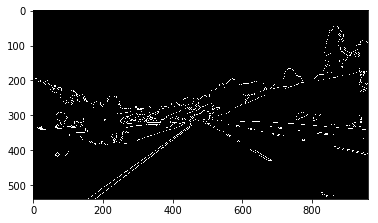

In [36]:
prev_clip_data = [0,0,0,0]
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
prev_clip_data = [0,0,0,0]
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

ignoring line  [[603 668 790 668]]  as outlier  -4.57568029247e-16 668.0
ignoring line  [[ 964  677 1085  677]]  as outlier  -1.56659698224e-15 677.0
ignoring line  [[432 676 573 669]]  as outlier  -0.0496453900709 697.446808511
ignoring line  [[218 686 291 685]]  as outlier  -0.013698630137 688.98630137
ignoring line  [[351 682 401 681]]  as outlier  -0.02 689.02
ignoring line  [[908 702 954 703]]  as outlier  0.0217391304348 682.260869565
ignoring line  [[827 669 939 676]]  as outlier  0.0625 617.3125
ignoring line  [[908 706 937 706]]  as outlier  2.26541890235e-15 706.0
ignoring line  [[1174  713 1197  713]]  as outlier  -5.89919089813e-15 713.0
ignoring line  [[1000  716 1025  716]]  as outlier  -8.73292534928e-16 716.0
ignoring line  [[573 700 607 700]]  as outlier  -2.6558135533e-15 700.0
ignoring line  [[325 683 352 683]]  as outlier  2.72891019936e-15 683.0
ignoring line  [[1087  676 1127  669]]  as outlier  -0.175 866.225
current clip data = [-0.63793507067650634, 842.0729087

  0%|                                                                                                                                                                                                             | 0/251 [00:00<?, ?it/s]

ignoring line  [[286 682 503 525]]  as outlier  -0.723502304147 888.921658986
ignoring line  [[603 668 790 668]]  as outlier  -4.57568029247e-16 668.0
ignoring line  [[ 964  677 1085  677]]  as outlier  -1.56659698224e-15 677.0
ignoring line  [[432 676 573 669]]  as outlier  -0.0496453900709 697.446808511
ignoring line  [[218 686 291 685]]  as outlier  -0.013698630137 688.98630137
ignoring line  [[351 682 401 681]]  as outlier  -0.02 689.02
ignoring line  [[500 520 533 501]]  as outlier  -0.575757575758 807.878787879
ignoring line  [[908 702 954 703]]  as outlier  0.0217391304348 682.260869565
ignoring line  [[827 669 939 676]]  as outlier  0.0625 617.3125
ignoring line  [[908 706 937 706]]  as outlier  2.26541890235e-15 706.0
ignoring line  [[1174  713 1197  713]]  as outlier  -5.89919089813e-15 713.0
ignoring line  [[1000  716 1025  716]]  as outlier  -8.73292534928e-16 716.0
ignoring line  [[573 700 607 700]]  as outlier  -2.6558135533e-15 700.0
ignoring line  [[325 683 352 683]]  a

  0%|▊                                                                                                                                                                                                    | 1/251 [00:00<03:20,  1.25it/s]

ignoring line  [[281 685 494 531]]  as outlier  -0.723004694836 888.164319249
ignoring line  [[633 667 747 667]]  as outlier  -6.96659439693e-16 667.0
ignoring line  [[1070  675 1094  675]]  as outlier  -4.75467891466e-15 675.0
ignoring line  [[429 676 568 669]]  as outlier  -0.0503597122302 697.604316547
ignoring line  [[220 686 407 680]]  as outlier  -0.0320855614973 693.058823529
ignoring line  [[ 910  675 1061  677]]  as outlier  0.0132450331126 662.947019868
ignoring line  [[477 534 531 502]]  as outlier  -0.592592592593 816.666666667
ignoring line  [[330 648 537 503]]  as outlier  -0.700483091787 879.15942029
ignoring line  [[776 668 880 671]]  as outlier  0.0288461538462 645.615384615
ignoring line  [[1077  677 1106  673]]  as outlier  -0.137931034483 825.551724138
ignoring line  [[907 702 954 703]]  as outlier  0.0212765957447 682.70212766
ignoring line  [[ 999  677 1024  676]]  as outlier  -0.04 716.96
ignoring line  [[535 702 594 703]]  as outlier  0.0169491525424 692.9322033

  1%|█▌                                                                                                                                                                                                   | 2/251 [00:01<03:14,  1.28it/s]

ignoring line  [[286 682 484 539]]  as outlier  -0.722222222222 888.555555556
ignoring line  [[685 668 788 668]]  as outlier  -7.62186605521e-16 668.0
ignoring line  [[560 670 616 668]]  as outlier  -0.0357142857143 690.0
ignoring line  [[ 949  677 1086  677]]  as outlier  4.72966175025e-16 677.0
ignoring line  [[375 681 407 680]]  as outlier  -0.03125 692.71875
ignoring line  [[1022  646 1043  645]]  as outlier  -0.047619047619 694.666666667
ignoring line  [[298 672 324 672]]  as outlier  6.45647865115e-16 672.0
ignoring line  [[526 671 578 669]]  as outlier  -0.0384615384615 691.230769231
ignoring line  [[308 684 350 682]]  as outlier  -0.0476190476191 698.666666667
ignoring line  [[221 686 287 685]]  as outlier  -0.0151515151515 689.348484848
ignoring line  [[598 669 674 667]]  as outlier  -0.0263157894737 684.736842105
ignoring line  [[1065  672 1112  672]]  as outlier  -1.88280675159e-15 672.0
ignoring line  [[297 673 332 673]]  as outlier  8.93246414576e-16 673.0
ignoring line  [

  1%|██▎                                                                                                                                                                                                  | 3/251 [00:02<03:13,  1.28it/s]

ignoring line  [[599 668 644 668]]  as outlier  6.46308168505e-17 668.0
ignoring line  [[376 617 570 481]]  as outlier  -0.701030927835 880.587628866
ignoring line  [[238 686 399 681]]  as outlier  -0.0310559006211 693.391304348
ignoring line  [[1040  677 1068  677]]  as outlier  -2.63108794454e-15 677.0
ignoring line  [[657 667 770 668]]  as outlier  0.00884955752212 661.185840708
ignoring line  [[497 533 622 446]]  as outlier  -0.696 878.912
ignoring line  [[ 907  675 1031  677]]  as outlier  0.0161290322581 660.370967742
ignoring line  [[463 673 484 673]]  as outlier  -2.12167306896e-15 673.0
ignoring line  [[807 694 854 696]]  as outlier  0.0425531914894 659.659574468
ignoring line  [[422 677 449 675]]  as outlier  -0.0740740740741 708.259259259
ignoring line  [[506 671 591 669]]  as outlier  -0.0235294117647 682.905882353
ignoring line  [[778 668 877 671]]  as outlier  0.030303030303 644.424242424
ignoring line  [[779 489 808 508]]  as outlier  0.655172413793 -21.3793103448
ignori

  2%|███▏                                                                                                                                                                                                 | 4/251 [00:02<02:50,  1.45it/s]

ignoring line  [[264 686 399 681]]  as outlier  -0.037037037037 695.777777778
ignoring line  [[646 667 724 667]]  as outlier  -9.37328573802e-16 667.0
ignoring line  [[913 676 958 676]]  as outlier  6.87251676435e-16 676.0
ignoring line  [[818 669 855 670]]  as outlier  0.027027027027 646.891891892
ignoring line  [[430 676 565 669]]  as outlier  -0.0518518518519 698.296296296
ignoring line  [[600 668 628 668]]  as outlier  -3.01052188116e-15 668.0
ignoring line  [[314 663 404 599]]  as outlier  -0.711111111111 886.288888889
ignoring line  [[1008  677 1091  676]]  as outlier  -0.0120481927711 689.144578313
ignoring line  [[815 694 842 696]]  as outlier  0.0740740740741 633.62962963
ignoring line  [[822 691 848 694]]  as outlier  0.115384615385 596.153846154
ignoring line  [[223 686 407 680]]  as outlier  -0.0326086956522 693.27173913
ignoring line  [[907 705 930 702]]  as outlier  -0.130434782609 823.304347826
ignoring line  [[919 710 952 704]]  as outlier  -0.181818181818 877.090909091

  2%|███▉                                                                                                                                                                                                 | 5/251 [00:03<02:38,  1.55it/s]

ignoring line  [[770 669 823 669]]  as outlier  1.41220326187e-15 669.0
ignoring line  [[457 674 635 668]]  as outlier  -0.0337078651685 689.404494382
ignoring line  [[283 685 411 680]]  as outlier  -0.0390625 696.0546875
ignoring line  [[911 676 954 676]]  as outlier  -2.97337742605e-15 676.0
ignoring line  [[942 677 990 677]]  as outlier  -9.98309751356e-16 677.0
ignoring line  [[824 670 869 671]]  as outlier  0.0222222222222 651.688888889
ignoring line  [[560 701 609 699]]  as outlier  -0.0408163265306 723.857142857
ignoring line  [[230 687 300 685]]  as outlier  -0.0285714285714 693.571428571
ignoring line  [[1072  678 1147  667]]  as outlier  -0.146666666667 835.226666667
ignoring line  [[788 500 826 527]]  as outlier  0.710526315789 -59.8947368421
ignoring line  [[906 703 954 704]]  as outlier  0.0208333333333 684.125
ignoring line  [[658 668 686 668]]  as outlier  4.66440546056e-15 668.0
ignoring line  [[696 668 724 668]]  as outlier  2.88663988051e-15 668.0
ignoring line  [[400

  2%|████▋                                                                                                                                                                                                | 6/251 [00:03<02:22,  1.72it/s]

ignoring line  [[634 667 751 667]]  as outlier  2.89182027366e-16 667.0
ignoring line  [[927 676 988 676]]  as outlier  -5.03486043638e-16 676.0
ignoring line  [[233 686 406 680]]  as outlier  -0.0346820809249 694.080924855
ignoring line  [[1010  676 1058  677]]  as outlier  0.0208333333333 654.958333333
ignoring line  [[482 672 503 672]]  as outlier  -4.89566317245e-15 672.0
ignoring line  [[718 449 768 484]]  as outlier  0.7 -53.6
ignoring line  [[906 702 930 704]]  as outlier  0.0833333333333 626.5
ignoring line  [[761 668 815 668]]  as outlier  -2.29401737953e-15 668.0
ignoring line  [[568 485 615 450]]  as outlier  -0.744680851064 907.978723404
ignoring line  [[1111  671 1145  667]]  as outlier  -0.117647058824 801.705882353
ignoring line  [[504 671 613 668]]  as outlier  -0.0275229357798 684.871559633
ignoring line  [[811 694 854 696]]  as outlier  0.046511627907 656.279069767
ignoring line  [[511 525 557 491]]  as outlier  -0.739130434783 902.695652174
ignoring line  [[907 705 9

  3%|█████▍                                                                                                                                                                                               | 7/251 [00:04<02:21,  1.73it/s]

ignoring line  [[794 669 839 669]]  as outlier  -2.31282104042e-15 669.0
ignoring line  [[221 686 406 680]]  as outlier  -0.0324324324324 693.167567568
ignoring line  [[ 946  676 1002  677]]  as outlier  0.0178571428571 659.107142857
ignoring line  [[1027  677 1079  677]]  as outlier  -4.04492376365e-15 677.0
ignoring line  [[733 668 798 668]]  as outlier  3.6722055396e-16 668.0
ignoring line  [[675 667 703 667]]  as outlier  1.74975639642e-15 667.0
ignoring line  [[505 671 532 671]]  as outlier  -6.58700817166e-15 671.0
ignoring line  [[543 670 657 667]]  as outlier  -0.0263157894737 684.289473684
ignoring line  [[302 658 324 660]]  as outlier  0.0909090909091 630.545454545
ignoring line  [[807 694 842 696]]  as outlier  0.0571428571429 647.885714286
ignoring line  [[882 672 928 676]]  as outlier  0.0869565217391 595.304347826
ignoring line  [[582 696 607 696]]  as outlier  6.96232961458e-15 696.0
ignoring line  [[1112  671 1139  669]]  as outlier  -0.0740740740741 753.37037037
ignori

  3%|██████▎                                                                                                                                                                                              | 8/251 [00:04<02:12,  1.84it/s]

ignoring line  [[552 669 593 669]]  as outlier  -5.61308269419e-16 669.0
ignoring line  [[390 615 533 508]]  as outlier  -0.748251748252 906.818181818
ignoring line  [[264 685 395 681]]  as outlier  -0.030534351145 693.061068702
ignoring line  [[667 667 695 667]]  as outlier  2.00634329172e-15 667.0
ignoring line  [[ 987  677 1079  677]]  as outlier  6.60820677423e-16 677.0
ignoring line  [[696 667 846 669]]  as outlier  0.0133333333333 657.72
ignoring line  [[830 521 880 550]]  as outlier  0.58 39.6
ignoring line  [[479 672 501 672]]  as outlier  1.39414719429e-15 672.0
ignoring line  [[545 501 579 476]]  as outlier  -0.735294117647 901.735294118
ignoring line  [[629 667 658 667]]  as outlier  2.68518907513e-15 667.0
ignoring line  [[856 670 935 676]]  as outlier  0.0759493670886 604.987341772
ignoring line  [[230 686 266 684]]  as outlier  -0.0555555555556 698.777777778
ignoring line  [[563 699 609 699]]  as outlier  -2.94714684461e-15 699.0
ignoring line  [[436 675 474 673]]  as out

  4%|███████                                                                                                                                                                                              | 9/251 [00:05<02:02,  1.97it/s]

ignoring line  [[297 684 485 543]]  as outlier  -0.75 906.75
ignoring line  [[755 668 810 668]]  as outlier  4.00412309116e-15 668.0
ignoring line  [[919 676 986 676]]  as outlier  8.01281970059e-16 676.0
ignoring line  [[274 685 343 682]]  as outlier  -0.0434782608696 696.913043478
ignoring line  [[501 671 592 669]]  as outlier  -0.021978021978 682.010989011
ignoring line  [[325 683 419 678]]  as outlier  -0.0531914893617 700.287234043
ignoring line  [[680 667 708 667]]  as outlier  2.31620697191e-15 667.0
ignoring line  [[516 514 543 497]]  as outlier  -0.62962962963 838.888888889
ignoring line  [[563 701 609 699]]  as outlier  -0.0434782608696 725.47826087
ignoring line  [[844 670 878 671]]  as outlier  0.0294117647059 645.176470588
ignoring line  [[1112  671 1135  668]]  as outlier  -0.130434782609 816.043478261
ignoring line  [[210 684 260 685]]  as outlier  0.02 679.8
ignoring line  [[811 669 843 669]]  as outlier  -1.70077343191e-15 669.0
ignoring line  [[1049  677 1095  675]]  

  4%|███████▊                                                                                                                                                                                            | 10/251 [00:05<02:01,  1.98it/s]

ignoring line  [[575 669 615 669]]  as outlier  -4.0509256223e-15 669.0
ignoring line  [[ 954  677 1083  677]]  as outlier  7.87707590147e-17 677.0
ignoring line  [[238 686 410 680]]  as outlier  -0.0348837209302 694.302325581
ignoring line  [[709 668 854 670]]  as outlier  0.0137931034483 658.220689655
ignoring line  [[511 671 546 671]]  as outlier  -6.84108129887e-15 671.0
ignoring line  [[645 668 673 668]]  as outlier  -4.87833684208e-16 668.0
ignoring line  [[1087  676 1150  667]]  as outlier  -0.142857142857 831.285714286
ignoring line  [[ 869  546 1002  622]]  as outlier  0.571428571429 49.4285714286
ignoring line  [[563 700 600 700]]  as outlier  -1.17447755425e-15 700.0
ignoring line  [[864 671 920 676]]  as outlier  0.0892857142857 593.857142857
ignoring line  [[612 668 640 668]]  as outlier  1.54061286671e-15 668.0
ignoring line  [[411 679 494 672]]  as outlier  -0.0843373493976 713.662650602
ignoring line  [[602 463 635 446]]  as outlier  -0.515151515152 773.121212121
ignori

  4%|████████▌                                                                                                                                                                                           | 11/251 [00:06<01:52,  2.14it/s]

ignoring line  [[620 667 771 667]]  as outlier  1.14909017259e-16 667.0
ignoring line  [[ 910  675 1010  676]]  as outlier  0.01 665.9
ignoring line  [[237 686 275 684]]  as outlier  -0.0526315789474 698.473684211
ignoring line  [[428 676 518 670]]  as outlier  -0.0666666666667 704.533333333
ignoring line  [[921 701 954 703]]  as outlier  0.0606060606061 645.181818182
ignoring line  [[538 702 609 698]]  as outlier  -0.056338028169 732.309859155
ignoring line  [[300 683 394 681]]  as outlier  -0.0212765957447 689.382978723
ignoring line  [[1020  707 1086  713]]  as outlier  0.0909090909091 614.272727273
ignoring line  [[1038  677 1066  676]]  as outlier  -0.0357142857143 714.071428571
ignoring line  [[788 668 882 671]]  as outlier  0.031914893617 642.85106383
ignoring line  [[582 669 618 668]]  as outlier  -0.0277777777778 685.166666667
ignoring line  [[1113  670 1145  667]]  as outlier  -0.09375 774.34375
ignoring line  [[563 482 634 446]]  as outlier  -0.507042253521 767.464788732
ign

  5%|█████████▎                                                                                                                                                                                          | 12/251 [00:06<01:48,  2.20it/s]

ignoring line  [[687 668 788 668]]  as outlier  8.69976211541e-16 668.0
ignoring line  [[ 960  677 1085  677]]  as outlier  -1.96183320454e-16 677.0
ignoring line  [[431 676 572 669]]  as outlier  -0.0496453900709 697.397163121
ignoring line  [[618 668 655 667]]  as outlier  -0.027027027027 684.702702703
ignoring line  [[376 681 400 681]]  as outlier  3.10632658327e-16 681.0
ignoring line  [[219 686 297 685]]  as outlier  -0.0128205128205 688.807692308
ignoring line  [[814 669 842 670]]  as outlier  0.0357142857143 639.928571429
ignoring line  [[559 485 630 447]]  as outlier  -0.535211267606 784.183098592
ignoring line  [[298 684 351 683]]  as outlier  -0.0188679245283 689.622641509
ignoring line  [[560 700 605 700]]  as outlier  -1.17218035649e-15 700.0
ignoring line  [[807 694 834 696]]  as outlier  0.0740740740741 634.222222222
ignoring line  [[881 672 927 676]]  as outlier  0.0869565217391 595.391304348
ignoring line  [[920 702 953 704]]  as outlier  0.0606060606061 646.242424242
i

  5%|██████████▏                                                                                                                                                                                         | 13/251 [00:06<01:46,  2.23it/s]

ignoring line  [[805 669 842 669]]  as outlier  7.31953153545e-16 669.0
ignoring line  [[552 670 608 668]]  as outlier  -0.0357142857143 689.714285714
ignoring line  [[ 988  677 1082  677]]  as outlier  7.75903150154e-16 677.0
ignoring line  [[319 684 416 679]]  as outlier  -0.0515463917526 700.443298969
ignoring line  [[676 667 704 667]]  as outlier  5.24166468564e-16 667.0
ignoring line  [[462 673 487 673]]  as outlier  -4.06461644343e-15 673.0
ignoring line  [[270 641 297 626]]  as outlier  -0.555555555556 791.0
ignoring line  [[609 668 645 668]]  as outlier  1.2815889614e-16 668.0
ignoring line  [[1069  672 1110  672]]  as outlier  -1.06969284503e-15 672.0
ignoring line  [[1067  671 1130  670]]  as outlier  -0.015873015873 687.936507937
ignoring line  [[923 675 945 676]]  as outlier  0.0454545454545 633.045454545
ignoring line  [[502 672 570 669]]  as outlier  -0.0441176470588 694.147058824
ignoring line  [[219 686 318 684]]  as outlier  -0.020202020202 690.424242424
ignoring line 

  6%|██████████▉                                                                                                                                                                                         | 14/251 [00:07<01:45,  2.25it/s]

ignoring line  [[630 667 759 667]]  as outlier  2.30509061379e-16 667.0
ignoring line  [[231 686 274 684]]  as outlier  -0.046511627907 696.744186047
ignoring line  [[591 668 629 668]]  as outlier  -2.96372091004e-15 668.0
ignoring line  [[ 991  677 1083  677]]  as outlier  -4.25943761331e-16 677.0
ignoring line  [[1068  671 1133  671]]  as outlier  1.09523446136e-15 671.0
ignoring line  [[427 676 501 671]]  as outlier  -0.0675675675676 704.851351351
ignoring line  [[322 682 392 681]]  as outlier  -0.0142857142857 686.6
ignoring line  [[792 668 963 676]]  as outlier  0.046783625731 630.947368421
ignoring line  [[326 683 395 628]]  as outlier  -0.797101449275 942.855072464
ignoring line  [[1052  648 1100  674]]  as outlier  0.541666666667 78.1666666667
ignoring line  [[329 684 396 628]]  as outlier  -0.835820895522 958.985074627
ignoring line  [[923 703 953 706]]  as outlier  0.1 610.7
ignoring line  [[298 683 334 684]]  as outlier  0.0277777777778 674.722222222
ignoring line  [[924 701

  6%|███████████▋                                                                                                                                                                                        | 15/251 [00:07<01:42,  2.30it/s]

ignoring line  [[ 974  677 1080  677]]  as outlier  1.95428188536e-16 677.0
ignoring line  [[646 667 731 667]]  as outlier  -6.40955810912e-16 667.0
ignoring line  [[234 686 407 680]]  as outlier  -0.0346820809249 694.115606936
ignoring line  [[509 671 532 671]]  as outlier  -3.16535439566e-15 671.0
ignoring line  [[898 674 938 676]]  as outlier  0.05 629.1
ignoring line  [[749 668 797 668]]  as outlier  2.39075079094e-15 668.0
ignoring line  [[906 702 948 706]]  as outlier  0.0952380952381 615.714285714
ignoring line  [[561 700 610 698]]  as outlier  -0.0408163265306 722.897959184
ignoring line  [[462 673 484 673]]  as outlier  -2.97340924863e-15 673.0
ignoring line  [[536 498 615 449]]  as outlier  -0.620253164557 830.455696203
ignoring line  [[517 670 562 670]]  as outlier  -1.41432748798e-15 670.0
ignoring line  [[807 693 854 696]]  as outlier  0.063829787234 641.489361702
ignoring line  [[729 459 800 509]]  as outlier  0.704225352113 -54.3802816901
ignoring line  [[800 669 842 669

  6%|████████████▍                                                                                                                                                                                       | 16/251 [00:08<01:33,  2.50it/s]

ignoring line  [[608 667 787 667]]  as outlier  5.71577072241e-17 667.0
ignoring line  [[912 675 958 675]]  as outlier  -2.44961075482e-15 675.0
ignoring line  [[301 682 383 681]]  as outlier  -0.0121951219512 685.670731707
ignoring line  [[433 675 576 668]]  as outlier  -0.048951048951 696.195804196
ignoring line  [[529 702 610 698]]  as outlier  -0.0493827160494 728.12345679
ignoring line  [[909 702 950 706]]  as outlier  0.0975609756098 613.317073171
ignoring line  [[299 683 331 683]]  as outlier  4.07798008135e-15 683.0
ignoring line  [[333 643 353 644]]  as outlier  0.05 626.35
ignoring line  [[1001  676 1056  676]]  as outlier  2.34399650665e-15 676.0
ignoring line  [[825 668 884 671]]  as outlier  0.0508474576271 626.050847458
ignoring line  [[483 534 557 485]]  as outlier  -0.662162162162 853.824324324
ignoring line  [[1082  676 1132  668]]  as outlier  -0.16 849.12
ignoring line  [[210 684 244 685]]  as outlier  0.0294117647059 677.823529412
ignoring line  [[1034  713 1068  71

  7%|█████████████▎                                                                                                                                                                                      | 17/251 [00:08<01:30,  2.59it/s]

ignoring line  [[733 668 797 668]]  as outlier  -7.34940484231e-16 668.0
ignoring line  [[ 961  677 1083  677]]  as outlier  5.10370344935e-16 677.0
ignoring line  [[427 676 565 669]]  as outlier  -0.0507246376812 697.65942029
ignoring line  [[212 685 339 683]]  as outlier  -0.0157480314961 688.338582677
ignoring line  [[500 523 608 453]]  as outlier  -0.648148148148 847.074074074
ignoring line  [[340 682 420 678]]  as outlier  -0.05 699.0
ignoring line  [[566 669 698 667]]  as outlier  -0.0151515151515 677.575757576
ignoring line  [[821 669 934 676]]  as outlier  0.0619469026549 618.14159292
ignoring line  [[590 468 633 446]]  as outlier  -0.511627906977 769.860465116
ignoring line  [[787 502 832 528]]  as outlier  0.577777777778 47.2888888889
ignoring line  [[1021  713 1053  716]]  as outlier  0.09375 617.28125
ignoring line  [[813 695 839 695]]  as outlier  1.31369676061e-15 695.0
ignoring line  [[562 700 590 700]]  as outlier  2.09283852018e-16 700.0
ignoring line  [[1084  676 1146

  7%|██████████████                                                                                                                                                                                      | 18/251 [00:08<01:35,  2.44it/s]

ignoring line  [[722 668 797 668]]  as outlier  -9.51439530738e-16 668.0
ignoring line  [[278 685 370 681]]  as outlier  -0.0434782608696 697.086956522
ignoring line  [[914 676 961 676]]  as outlier  1.32867637033e-15 676.0
ignoring line  [[502 521 604 455]]  as outlier  -0.647058823529 845.823529412
ignoring line  [[582 669 666 667]]  as outlier  -0.0238095238095 682.857142857
ignoring line  [[498 524 530 504]]  as outlier  -0.625 835.25
ignoring line  [[367 682 413 679]]  as outlier  -0.0652173913043 705.934782609
ignoring line  [[479 672 503 672]]  as outlier  -3.84637739224e-15 672.0
ignoring line  [[555 700 609 697]]  as outlier  -0.0555555555556 730.833333333
ignoring line  [[731 692 753 691]]  as outlier  -0.0454545454545 725.227272727
ignoring line  [[927 702 959 706]]  as outlier  0.125 586.125
ignoring line  [[527 671 602 668]]  as outlier  -0.04 692.08
ignoring line  [[808 669 872 671]]  as outlier  0.03125 643.75
ignoring line  [[ 962  677 1082  677]]  as outlier  7.8523046

  8%|██████████████▊                                                                                                                                                                                     | 19/251 [00:09<01:37,  2.39it/s]

ignoring line  [[914 676 961 676]]  as outlier  1.32867637033e-15 676.0
ignoring line  [[602 668 644 668]]  as outlier  9.67212316797e-16 668.0
ignoring line  [[225 686 405 680]]  as outlier  -0.0333333333333 693.5
ignoring line  [[479 672 504 672]]  as outlier  -3.27010167223e-16 672.0
ignoring line  [[776 668 872 671]]  as outlier  0.03125 643.75
ignoring line  [[819 693 856 696]]  as outlier  0.0810810810811 626.594594595
ignoring line  [[814 514 882 553]]  as outlier  0.573529411765 47.1470588235
ignoring line  [[554 702 609 699]]  as outlier  -0.0545454545455 732.218181818
ignoring line  [[902 702 951 706]]  as outlier  0.0816326530612 628.367346939
ignoring line  [[554 701 609 698]]  as outlier  -0.0545454545455 731.218181818
ignoring line  [[704 667 760 668]]  as outlier  0.0178571428571 654.428571429
ignoring line  [[958 677 986 677]]  as outlier  3.26648731309e-15 677.0
ignoring line  [[1068  677 1097  675]]  as outlier  -0.0689655172414 750.655172414
ignoring line  [[1029  67

  8%|███████████████▌                                                                                                                                                                                    | 20/251 [00:09<01:36,  2.39it/s]

ignoring line  [[607 668 790 668]]  as outlier  -6.84676558064e-16 668.0
ignoring line  [[ 958  677 1082  677]]  as outlier  1.1800093632e-15 677.0
ignoring line  [[235 686 277 684]]  as outlier  -0.047619047619 697.19047619
ignoring line  [[488 672 511 672]]  as outlier  -7.24030963433e-16 672.0
ignoring line  [[512 671 536 670]]  as outlier  -0.0416666666667 692.333333333
ignoring line  [[825 669 939 676]]  as outlier  0.0614035087719 618.342105263
ignoring line  [[354 683 388 681]]  as outlier  -0.0588235294118 703.823529412
ignoring line  [[299 684 328 684]]  as outlier  1.02459822548e-15 684.0
ignoring line  [[432 676 489 673]]  as outlier  -0.0526315789474 698.736842105
ignoring line  [[1024  714 1070  716]]  as outlier  0.0434782608696 669.47826087
ignoring line  [[1083  676 1124  670]]  as outlier  -0.146341463415 834.487804878
ignoring line  [[580 474 623 451]]  as outlier  -0.53488372093 784.23255814
ignoring line  [[303 682 331 683]]  as outlier  0.0357142857143 671.17857142

  8%|████████████████▍                                                                                                                                                                                   | 21/251 [00:10<01:27,  2.61it/s]

ignoring line  [[732 667 814 667]]  as outlier  -1.0384979949e-16 667.0
ignoring line  [[483 671 603 667]]  as outlier  -0.0333333333333 687.1
ignoring line  [[917 675 986 675]]  as outlier  2.11077097042e-16 675.0
ignoring line  [[318 682 373 681]]  as outlier  -0.0181818181818 687.781818182
ignoring line  [[846 533 944 589]]  as outlier  0.571428571429 49.5714285714
ignoring line  [[554 701 609 698]]  as outlier  -0.0545454545455 731.218181818
ignoring line  [[1036  676 1079  676]]  as outlier  6.08016073833e-16 676.0
ignoring line  [[273 683 317 683]]  as outlier  -3.26099455881e-15 683.0
ignoring line  [[630 666 745 666]]  as outlier  5.24350074317e-16 666.0
ignoring line  [[226 685 263 684]]  as outlier  -0.027027027027 691.108108108
ignoring line  [[559 483 635 446]]  as outlier  -0.486842105263 755.144736842
ignoring line  [[459 672 482 672]]  as outlier  2.22049206111e-15 672.0
ignoring line  [[374 680 406 679]]  as outlier  -0.03125 691.6875
ignoring line  [[831 668 864 670]] 

  9%|█████████████████▏                                                                                                                                                                                  | 22/251 [00:10<01:26,  2.64it/s]

ignoring line  [[631 667 744 667]]  as outlier  -1.39843434764e-15 667.0
ignoring line  [[427 676 456 674]]  as outlier  -0.0689655172414 705.448275862
ignoring line  [[249 685 403 680]]  as outlier  -0.0324675324675 693.084415584
ignoring line  [[1012  677 1040  677]]  as outlier  -6.97264263531e-15 677.0
ignoring line  [[789 668 845 670]]  as outlier  0.0357142857143 639.821428571
ignoring line  [[474 672 502 672]]  as outlier  -3.70492345065e-15 672.0
ignoring line  [[551 669 591 669]]  as outlier  -2.1808436798e-15 669.0
ignoring line  [[534 700 593 703]]  as outlier  0.0508474576271 672.847457627
ignoring line  [[808 668 887 672]]  as outlier  0.0506329113924 627.088607595
ignoring line  [[1026  713 1071  717]]  as outlier  0.0888888888889 621.8
ignoring line  [[915 676 985 676]]  as outlier  1.22615406601e-15 676.0
ignoring line  [[1074  677 1130  669]]  as outlier  -0.142857142857 830.428571429
ignoring line  [[ 972  607 1010  627]]  as outlier  0.526315789474 95.4210526316
igno

  9%|█████████████████▉                                                                                                                                                                                  | 23/251 [00:10<01:29,  2.53it/s]

ignoring line  [[585 668 627 668]]  as outlier  2.05491401928e-15 668.0
ignoring line  [[676 667 789 668]]  as outlier  0.00884955752212 661.017699115
ignoring line  [[213 685 334 683]]  as outlier  -0.0165289256198 688.520661157
ignoring line  [[916 676 984 676]]  as outlier  5.49676255441e-16 676.0
ignoring line  [[1035  677 1063  677]]  as outlier  -5.17231301174e-15 677.0
ignoring line  [[522 671 561 669]]  as outlier  -0.051282051282 697.769230769
ignoring line  [[571 479 612 456]]  as outlier  -0.560975609756 799.317073171
ignoring line  [[577 700 609 698]]  as outlier  -0.0625 736.0625
ignoring line  [[378 681 425 677]]  as outlier  -0.0851063829787 713.170212766
ignoring line  [[506 518 589 464]]  as outlier  -0.650602409639 847.204819277
ignoring line  [[ 972  677 1026  677]]  as outlier  -1.32725718517e-15 677.0
ignoring line  [[472 672 498 672]]  as outlier  -4.9707136917e-16 672.0
ignoring line  [[1050  709 1078  714]]  as outlier  0.178571428571 521.5
ignoring line  [[628 

 10%|██████████████████▋                                                                                                                                                                                 | 24/251 [00:11<01:33,  2.43it/s]

ignoring line  [[787 668 835 668]]  as outlier  3.96318405524e-16 668.0
ignoring line  [[ 992  676 1080  677]]  as outlier  0.0113636363636 664.727272727
ignoring line  [[561 669 674 666]]  as outlier  -0.0265486725664 683.89380531
ignoring line  [[ 961  601 1093  675]]  as outlier  0.560606060606 62.2575757576
ignoring line  [[720 667 748 667]]  as outlier  1.53302126932e-15 667.0
ignoring line  [[220 685 311 683]]  as outlier  -0.021978021978 689.835164835
ignoring line  [[422 676 517 670]]  as outlier  -0.0631578947368 702.652631579
ignoring line  [[1029  712 1071  716]]  as outlier  0.0952380952381 614.0
ignoring line  [[1028  677 1107  673]]  as outlier  -0.0506329113924 729.050632911
ignoring line  [[559 699 607 699]]  as outlier  -2.8243129234e-15 699.0
ignoring line  [[903 674 966 676]]  as outlier  0.031746031746 645.333333333
ignoring line  [[533 670 575 668]]  as outlier  -0.047619047619 695.380952381
ignoring line  [[564 483 620 452]]  as outlier  -0.553571428571 795.214285

 10%|███████████████████▌                                                                                                                                                                                | 25/251 [00:11<01:35,  2.36it/s]

ignoring line  [[821 669 850 669]]  as outlier  6.9265318842e-15 669.0
ignoring line  [[746 667 769 667]]  as outlier  -6.04835627494e-15 667.0
ignoring line  [[420 677 444 675]]  as outlier  -0.0833333333333 712.0
ignoring line  [[553 669 584 669]]  as outlier  2.82704912658e-15 669.0
ignoring line  [[226 686 410 679]]  as outlier  -0.0380434782609 694.597826087
ignoring line  [[ 936  676 1088  676]]  as outlier  -4.35668471713e-16 676.0
ignoring line  [[501 671 523 671]]  as outlier  6.2004343837e-15 671.0
ignoring line  [[ 982  614 1091  674]]  as outlier  0.550458715596 73.4495412844
ignoring line  [[922 700 951 704]]  as outlier  0.137931034483 572.827586207
ignoring line  [[928 704 952 706]]  as outlier  0.0833333333333 626.666666667
ignoring line  [[625 667 745 667]]  as outlier  1.16908199768e-15 667.0
ignoring line  [[476 672 500 672]]  as outlier  3.70532767896e-15 672.0
ignoring line  [[560 486 625 450]]  as outlier  -0.553846153846 796.153846154
ignoring line  [[1025  711 1

 10%|████████████████████▎                                                                                                                                                                               | 26/251 [00:12<01:38,  2.29it/s]

ignoring line  [[300 683 470 551]]  as outlier  -0.776470588235 915.941176471
ignoring line  [[572 668 603 668]]  as outlier  6.83921453003e-16 668.0
ignoring line  [[ 968  676 1084  676]]  as outlier  -9.38720388148e-16 676.0
ignoring line  [[307 660 329 660]]  as outlier  5.43183859005e-15 660.0
ignoring line  [[652 666 749 667]]  as outlier  0.0103092783505 659.278350515
ignoring line  [[298 683 381 681]]  as outlier  -0.0240963855422 690.180722892
ignoring line  [[441 674 542 669]]  as outlier  -0.049504950495 695.831683168
ignoring line  [[834 668 907 673]]  as outlier  0.0684931506849 610.876712329
ignoring line  [[960 675 982 675]]  as outlier  3.72529446005e-15 675.0
ignoring line  [[1026  711 1067  716]]  as outlier  0.121951219512 585.87804878
ignoring line  [[800 668 833 668]]  as outlier  -2.51009709634e-15 668.0
ignoring line  [[217 685 279 685]]  as outlier  -8.04112521882e-16 685.0
ignoring line  [[572 699 606 699]]  as outlier  4.77493122384e-16 699.0
ignoring line  [[9

 11%|█████████████████████                                                                                                                                                                               | 27/251 [00:12<01:38,  2.27it/s]

ignoring line  [[820 669 847 669]]  as outlier  2.98947083214e-15 669.0
ignoring line  [[ 930  676 1018  676]]  as outlier  1.64901094475e-16 676.0
ignoring line  [[223 686 274 684]]  as outlier  -0.0392156862745 694.745098039
ignoring line  [[553 669 589 669]]  as outlier  9.85011814607e-16 669.0
ignoring line  [[601 668 638 667]]  as outlier  -0.027027027027 684.243243243
ignoring line  [[429 676 524 670]]  as outlier  -0.0631578947368 703.094736842
ignoring line  [[532 505 626 446]]  as outlier  -0.627659574468 838.914893617
ignoring line  [[298 683 369 682]]  as outlier  -0.0140845070423 687.197183099
ignoring line  [[753 668 786 668]]  as outlier  -4.80445996697e-15 668.0
ignoring line  [[684 667 740 667]]  as outlier  1.52304733106e-15 667.0
ignoring line  [[1087  675 1107  673]]  as outlier  -0.1 783.7
ignoring line  [[304 662 327 662]]  as outlier  2.54628793884e-15 662.0
ignoring line  [[751 667 807 668]]  as outlier  0.0178571428571 653.589285714
ignoring line  [[721 449 802 

 11%|█████████████████████▊                                                                                                                                                                              | 28/251 [00:13<01:39,  2.25it/s]

ignoring line  [[588 668 622 668]]  as outlier  9.29750605963e-16 668.0
ignoring line  [[296 683 412 679]]  as outlier  -0.0344827586207 693.206896552
ignoring line  [[ 934  676 1021  676]]  as outlier  1.27344594673e-15 676.0
ignoring line  [[665 667 721 667]]  as outlier  4.05672713907e-16 667.0
ignoring line  [[747 667 892 672]]  as outlier  0.0344827586207 641.24137931
ignoring line  [[517 515 620 448]]  as outlier  -0.650485436893 851.300970874
ignoring line  [[718 448 761 477]]  as outlier  0.674418604651 -36.2325581395
ignoring line  [[1111  671 1146  670]]  as outlier  -0.0285714285714 702.742857143
ignoring line  [[436 675 554 669]]  as outlier  -0.0508474576271 697.169491525
ignoring line  [[563 699 589 700]]  as outlier  0.0384615384615 677.346153846
ignoring line  [[261 685 293 685]]  as outlier  -2.31783287587e-15 685.0
ignoring line  [[1039  677 1063  676]]  as outlier  -0.0416666666667 720.291666667
ignoring line  [[1116  670 1148  666]]  as outlier  -0.125 809.5
ignorin

 12%|██████████████████████▋                                                                                                                                                                             | 29/251 [00:13<01:33,  2.39it/s]

ignoring line  [[558 669 593 669]]  as outlier  1.74525615178e-15 669.0
ignoring line  [[266 685 390 681]]  as outlier  -0.0322580645161 693.580645161
ignoring line  [[ 973  677 1082  677]]  as outlier  -3.90636932651e-16 677.0
ignoring line  [[690 667 842 669]]  as outlier  0.0131578947368 657.921052632
ignoring line  [[638 667 689 667]]  as outlier  -4.84276895439e-16 667.0
ignoring line  [[476 672 500 672]]  as outlier  3.70532767896e-15 672.0
ignoring line  [[517 508 537 497]]  as outlier  -0.55 792.35
ignoring line  [[1218  717 1244  717]]  as outlier  -9.4684942989e-16 717.0
ignoring line  [[563 699 589 700]]  as outlier  0.0384615384615 677.346153846
ignoring line  [[573 473 626 446]]  as outlier  -0.509433962264 764.905660377
ignoring line  [[574 477 635 446]]  as outlier  -0.508196721311 768.704918033
ignoring line  [[1028  712 1098  719]]  as outlier  0.1 609.2
ignoring line  [[445 675 469 673]]  as outlier  -0.0833333333333 712.083333333
ignoring line  [[717 446 765 483]]  a

 12%|███████████████████████▍                                                                                                                                                                            | 30/251 [00:13<01:28,  2.50it/s]

ignoring line  [[293 683 317 682]]  as outlier  -0.0416666666667 695.208333333
ignoring line  [[766 668 787 668]]  as outlier  4.19246118002e-15 668.0
ignoring line  [[532 671 588 669]]  as outlier  -0.0357142857143 690.0
ignoring line  [[913 676 966 676]]  as outlier  -9.83611390895e-16 676.0
ignoring line  [[226 686 408 680]]  as outlier  -0.032967032967 693.450549451
ignoring line  [[546 496 624 451]]  as outlier  -0.576923076923 811.0
ignoring line  [[626 668 682 668]]  as outlier  6.14030268068e-16 668.0
ignoring line  [[467 673 487 673]]  as outlier  1.85342099611e-15 673.0
ignoring line  [[1063  717 1107  717]]  as outlier  6.29644069778e-16 717.0
ignoring line  [[ 977  677 1005  677]]  as outlier  -5.39386219057e-15 677.0
ignoring line  [[810 669 857 670]]  as outlier  0.0212765957447 651.765957447
ignoring line  [[554 485 627 446]]  as outlier  -0.534246575342 780.97260274
ignoring line  [[508 671 531 671]]  as outlier  1.00557996116e-15 671.0
ignoring line  [[1006  677 1055  

 12%|████████████████████████▏                                                                                                                                                                           | 31/251 [00:14<01:27,  2.53it/s]

ignoring line  [[577 668 624 668]]  as outlier  8.02603642237e-16 668.0
ignoring line  [[725 667 781 668]]  as outlier  0.0178571428571 654.053571429
ignoring line  [[ 998  677 1078  677]]  as outlier  -9.28660252108e-16 677.0
ignoring line  [[426 676 515 670]]  as outlier  -0.0674157303371 704.719101124
ignoring line  [[361 681 403 680]]  as outlier  -0.0238095238095 689.595238095
ignoring line  [[266 684 300 661]]  as outlier  -0.676470588235 863.941176471
ignoring line  [[502 518 602 458]]  as outlier  -0.6 819.2
ignoring line  [[801 668 900 673]]  as outlier  0.050505050505 627.545454545
ignoring line  [[216 685 284 685]]  as outlier  7.96554553779e-16 685.0
ignoring line  [[495 531 545 498]]  as outlier  -0.66 857.7
ignoring line  [[689 667 717 667]]  as outlier  4.40163970916e-15 667.0
ignoring line  [[547 495 621 452]]  as outlier  -0.581081081081 812.851351351
ignoring line  [[516 670 544 670]]  as outlier  -2.65341942692e-15 670.0
ignoring line  [[928 676 984 676]]  as outlier

 13%|████████████████████████▉                                                                                                                                                                           | 32/251 [00:14<01:28,  2.49it/s]

ignoring line  [[589 668 632 668]]  as outlier  -3.68466835012e-15 668.0
ignoring line  [[925 676 988 676]]  as outlier  -1.55398406955e-15 676.0
ignoring line  [[864 671 890 672]]  as outlier  0.0384615384615 637.769230769
ignoring line  [[697 667 847 669]]  as outlier  0.0133333333333 657.706666667
ignoring line  [[521 506 618 450]]  as outlier  -0.577319587629 806.783505155
ignoring line  [[327 683 369 681]]  as outlier  -0.047619047619 698.571428571
ignoring line  [[232 686 306 683]]  as outlier  -0.0405405405405 695.405405405
ignoring line  [[567 482 633 447]]  as outlier  -0.530303030303 782.681818182
ignoring line  [[436 675 557 669]]  as outlier  -0.0495867768595 696.619834711
ignoring line  [[558 700 607 697]]  as outlier  -0.0612244897959 734.163265306
ignoring line  [[1077  677 1108  673]]  as outlier  -0.129032258065 815.967741935
ignoring line  [[498 521 526 504]]  as outlier  -0.607142857143 823.357142857
ignoring line  [[718 449 757 477]]  as outlier  0.717948717949 -66.

 13%|█████████████████████████▊                                                                                                                                                                          | 33/251 [00:15<01:28,  2.46it/s]

ignoring line  [[630 667 753 667]]  as outlier  -1.15795629707e-16 667.0
ignoring line  [[234 686 397 681]]  as outlier  -0.0306748466258 693.17791411
ignoring line  [[ 992  677 1077  677]]  as outlier  -7.76423201813e-17 677.0
ignoring line  [[876 552 962 602]]  as outlier  0.581395348837 42.6976744186
ignoring line  [[519 507 589 465]]  as outlier  -0.6 818.4
ignoring line  [[502 671 527 671]]  as outlier  7.81001155808e-17 671.0
ignoring line  [[795 668 898 673]]  as outlier  0.0485436893204 629.40776699
ignoring line  [[554 490 613 456]]  as outlier  -0.576271186441 809.254237288
ignoring line  [[948 676 991 676]]  as outlier  -1.03621678587e-15 676.0
ignoring line  [[428 676 501 672]]  as outlier  -0.0547945205479 699.452054795
ignoring line  [[718 448 763 481]]  as outlier  0.733333333333 -78.5333333333
ignoring line  [[1039  714 1069  715]]  as outlier  0.0333333333333 679.366666667
ignoring line  [[551 492 632 447]]  as outlier  -0.555555555556 798.111111111
ignoring line  [[47

 14%|██████████████████████████▌                                                                                                                                                                         | 34/251 [00:15<01:27,  2.47it/s]

ignoring line  [[ 946  677 1083  677]]  as outlier  1.58119485141e-16 677.0
ignoring line  [[572 669 605 669]]  as outlier  -4.57428160268e-15 669.0
ignoring line  [[ 882  555 1021  638]]  as outlier  0.597122302158 28.3381294964
ignoring line  [[755 668 781 668]]  as outlier  6.48878595904e-15 668.0
ignoring line  [[515 518 620 450]]  as outlier  -0.647619047619 851.523809524
ignoring line  [[647 668 703 668]]  as outlier  -6.5445648915e-16 668.0
ignoring line  [[441 675 543 670]]  as outlier  -0.0490196078431 696.617647059
ignoring line  [[215 686 263 685]]  as outlier  -0.0208333333333 690.479166667
ignoring line  [[544 492 564 482]]  as outlier  -0.5 764.0
ignoring line  [[354 682 401 681]]  as outlier  -0.0212765957447 689.531914894
ignoring line  [[815 669 857 671]]  as outlier  0.047619047619 630.19047619
ignoring line  [[565 480 638 446]]  as outlier  -0.465753424658 743.150684932
ignoring line  [[287 684 321 684]]  as outlier  -4.35639803733e-15 684.0
ignoring line  [[565 486 

 14%|███████████████████████████▎                                                                                                                                                                        | 35/251 [00:15<01:30,  2.38it/s]

ignoring line  [[771 669 833 669]]  as outlier  9.51525062536e-16 669.0
ignoring line  [[578 669 670 668]]  as outlier  -0.0108695652174 675.282608696
ignoring line  [[ 903  570 1087  676]]  as outlier  0.576086956522 49.7934782609
ignoring line  [[742 668 770 668]]  as outlier  5.84738417247e-16 668.0
ignoring line  [[286 685 406 595]]  as outlier  -0.75 899.5
ignoring line  [[ 946  677 1083  677]]  as outlier  1.58119485141e-16 677.0
ignoring line  [[514 671 548 671]]  as outlier  2.57233267686e-15 671.0
ignoring line  [[214 686 260 686]]  as outlier  1.18162416273e-15 686.0
ignoring line  [[538 496 624 448]]  as outlier  -0.558139534884 796.279069767
ignoring line  [[286 684 385 682]]  as outlier  -0.020202020202 689.777777778
ignoring line  [[562 700 609 700]]  as outlier  -4.11566494881e-15 700.0
ignoring line  [[470 673 495 673]]  as outlier  6.24573346997e-15 673.0
ignoring line  [[1041  717 1069  717]]  as outlier  2.97145460879e-15 717.0
ignoring line  [[671 668 696 668]]  as 

 14%|████████████████████████████                                                                                                                                                                        | 36/251 [00:16<01:33,  2.31it/s]

ignoring line  [[223 686 260 684]]  as outlier  -0.0540540540541 698.054054054
ignoring line  [[634 667 744 667]]  as outlier  7.55979494166e-16 667.0
ignoring line  [[920 676 990 676]]  as outlier  5.88841469965e-16 676.0
ignoring line  [[261 685 316 683]]  as outlier  -0.0363636363636 694.490909091
ignoring line  [[337 683 379 681]]  as outlier  -0.047619047619 699.047619048
ignoring line  [[1039  677 1067  677]]  as outlier  -3.0534332315e-16 677.0
ignoring line  [[1081  673 1107  673]]  as outlier  2.93905151057e-16 673.0
ignoring line  [[807 693 835 695]]  as outlier  0.0714285714286 635.357142857
ignoring line  [[601 463 624 451]]  as outlier  -0.521739130435 776.565217391
ignoring line  [[751 668 807 668]]  as outlier  1.03128184313e-15 668.0
ignoring line  [[384 681 459 674]]  as outlier  -0.0933333333333 716.84
ignoring line  [[553 487 623 448]]  as outlier  -0.557142857143 795.1
ignoring line  [[538 701 609 697]]  as outlier  -0.056338028169 731.309859155
ignoring line  [[831

 15%|████████████████████████████▉                                                                                                                                                                       | 37/251 [00:16<01:37,  2.21it/s]

ignoring line  [[639 667 742 667]]  as outlier  1.74147876439e-16 667.0
ignoring line  [[230 686 406 680]]  as outlier  -0.0340909090909 693.840909091
ignoring line  [[ 967  677 1084  677]]  as outlier  -1.1739383652e-16 677.0
ignoring line  [[337 645 375 647]]  as outlier  0.0526315789474 627.263157895
ignoring line  [[781 668 818 669]]  as outlier  0.027027027027 646.891891892
ignoring line  [[505 671 533 671]]  as outlier  -3.32895819541e-15 671.0
ignoring line  [[565 699 603 700]]  as outlier  0.0263157894737 684.131578947
ignoring line  [[1066  712 1134  717]]  as outlier  0.0735294117647 633.617647059
ignoring line  [[594 467 637 446]]  as outlier  -0.488372093023 757.093023256
ignoring line  [[924 704 952 706]]  as outlier  0.0714285714286 638.0
ignoring line  [[560 483 625 447]]  as outlier  -0.553846153846 793.153846154
ignoring line  [[1044  714 1071  716]]  as outlier  0.0740740740741 636.666666667
ignoring line  [[877 671 933 676]]  as outlier  0.0892857142857 592.696428571

 15%|█████████████████████████████▋                                                                                                                                                                      | 38/251 [00:17<01:35,  2.23it/s]

ignoring line  [[792 669 839 669]]  as outlier  1.67509676609e-15 669.0
ignoring line  [[431 676 571 669]]  as outlier  -0.05 697.55
ignoring line  [[225 686 407 680]]  as outlier  -0.032967032967 693.417582418
ignoring line  [[874 672 897 673]]  as outlier  0.0434782608696 634.0
ignoring line  [[572 669 604 669]]  as outlier  3.27995874273e-15 669.0
ignoring line  [[1004  677 1032  677]]  as outlier  -2.01347631779e-15 677.0
ignoring line  [[533 499 617 450]]  as outlier  -0.583333333333 809.916666667
ignoring line  [[840 670 873 671]]  as outlier  0.030303030303 644.545454545
ignoring line  [[698 667 754 668]]  as outlier  0.0178571428571 654.535714286
ignoring line  [[ 966  677 1003  677]]  as outlier  3.59215841538e-15 677.0
ignoring line  [[598 668 697 667]]  as outlier  -0.010101010101 674.04040404
ignoring line  [[916 676 946 676]]  as outlier  5.74130728394e-15 676.0
ignoring line  [[573 479 635 446]]  as outlier  -0.532258064516 783.983870968
ignoring line  [[728 461 792 506]]

 16%|██████████████████████████████▍                                                                                                                                                                     | 39/251 [00:17<01:28,  2.39it/s]

ignoring line  [[768 669 830 669]]  as outlier  -1.15616446901e-15 669.0
ignoring line  [[ 911  676 1042  678]]  as outlier  0.0152671755725 662.091603053
ignoring line  [[544 670 672 667]]  as outlier  -0.0234375 682.75
ignoring line  [[222 686 407 680]]  as outlier  -0.0324324324324 693.2
ignoring line  [[512 671 543 671]]  as outlier  4.64606367083e-15 671.0
ignoring line  [[557 490 626 450]]  as outlier  -0.579710144928 812.898550725
ignoring line  [[1054  678 1100  675]]  as outlier  -0.0652173913043 746.739130435
ignoring line  [[695 668 723 668]]  as outlier  -2.26722330912e-16 668.0
ignoring line  [[829 692 853 694]]  as outlier  0.0833333333333 622.916666667
ignoring line  [[560 483 625 447]]  as outlier  -0.553846153846 793.153846154
ignoring line  [[781 493 815 513]]  as outlier  0.588235294118 33.5882352941
ignoring line  [[408 679 483 673]]  as outlier  -0.08 711.64
ignoring line  [[924 702 952 704]]  as outlier  0.0714285714286 636.0
ignoring line  [[602 463 629 446]]  as

 16%|███████████████████████████████▏                                                                                                                                                                    | 40/251 [00:18<01:20,  2.61it/s]

ignoring line  [[772 669 829 669]]  as outlier  2.91042745339e-15 669.0
ignoring line  [[542 670 685 668]]  as outlier  -0.013986013986 677.58041958
ignoring line  [[233 686 409 680]]  as outlier  -0.0340909090909 693.943181818
ignoring line  [[531 508 630 446]]  as outlier  -0.626262626263 840.545454545
ignoring line  [[911 676 934 676]]  as outlier  2.22195495938e-15 676.0
ignoring line  [[696 668 724 668]]  as outlier  2.88663988051e-15 668.0
ignoring line  [[468 673 491 673]]  as outlier  -1.92743415407e-15 673.0
ignoring line  [[935 677 980 677]]  as outlier  2.51801195402e-15 677.0
ignoring line  [[1070  678 1126  670]]  as outlier  -0.142857142857 830.857142857
ignoring line  [[561 700 607 700]]  as outlier  -4.81408592209e-16 700.0
ignoring line  [[532 501 612 453]]  as outlier  -0.6 820.2
ignoring line  [[734 668 762 668]]  as outlier  -9.67074751001e-16 668.0
ignoring line  [[277 671 302 672]]  as outlier  0.04 659.92
ignoring line  [[1049  715 1071  717]]  as outlier  0.0909

 16%|████████████████████████████████                                                                                                                                                                    | 41/251 [00:18<01:18,  2.67it/s]

ignoring line  [[723 668 792 668]]  as outlier  -2.12027690921e-16 668.0
ignoring line  [[425 570 610 454]]  as outlier  -0.627027027027 836.486486486
ignoring line  [[441 675 543 670]]  as outlier  -0.0490196078431 696.617647059
ignoring line  [[269 686 421 678]]  as outlier  -0.0526315789474 700.157894737
ignoring line  [[915 676 966 676]]  as outlier  -2.99050725798e-16 676.0
ignoring line  [[1010  677 1066  677]]  as outlier  -1.81931436261e-15 677.0
ignoring line  [[597 668 649 668]]  as outlier  -1.86937861499e-15 668.0
ignoring line  [[1074  677 1150  667]]  as outlier  -0.131578947368 818.315789474
ignoring line  [[208 685 250 686]]  as outlier  0.0238095238095 680.047619048
ignoring line  [[861 671 897 673]]  as outlier  0.0555555555556 623.166666667
ignoring line  [[601 463 636 446]]  as outlier  -0.485714285714 754.914285714
ignoring line  [[793 669 840 669]]  as outlier  -7.38108929819e-16 669.0
ignoring line  [[1091  716 1112  718]]  as outlier  0.0952380952381 612.0952380

 17%|████████████████████████████████▊                                                                                                                                                                   | 42/251 [00:18<01:15,  2.76it/s]

ignoring line  [[249 686 403 681]]  as outlier  -0.0324675324675 694.084415584
ignoring line  [[607 668 772 668]]  as outlier  5.20938756613e-16 668.0
ignoring line  [[ 947  677 1084  677]]  as outlier  3.94911211788e-16 677.0
ignoring line  [[513 671 546 671]]  as outlier  -2.80730886303e-15 671.0
ignoring line  [[810 511 869 545]]  as outlier  0.576271186441 44.220338983
ignoring line  [[815 669 928 676]]  as outlier  0.0619469026549 618.513274336
ignoring line  [[557 670 594 669]]  as outlier  -0.027027027027 685.054054054
ignoring line  [[214 686 236 686]]  as outlier  -1.60585672513e-15 686.0
ignoring line  [[922 702 952 704]]  as outlier  0.0666666666667 640.533333333
ignoring line  [[1021  702 1080  715]]  as outlier  0.220338983051 477.033898305
ignoring line  [[470 673 512 672]]  as outlier  -0.0238095238095 684.19047619
ignoring line  [[1085  676 1145  667]]  as outlier  -0.15 838.75
ignoring line  [[572 477 641 446]]  as outlier  -0.449275362319 733.985507246
ignoring line  

 17%|█████████████████████████████████▌                                                                                                                                                                  | 43/251 [00:19<01:13,  2.83it/s]

ignoring line  [[600 668 687 668]]  as outlier  4.36239170249e-16 668.0
ignoring line  [[283 684 360 682]]  as outlier  -0.025974025974 691.350649351
ignoring line  [[ 967  677 1081  677]]  as outlier  -3.5272476914e-16 677.0
ignoring line  [[543 671 599 669]]  as outlier  -0.0357142857143 690.392857143
ignoring line  [[248 686 402 681]]  as outlier  -0.0324675324675 694.051948052
ignoring line  [[759 668 790 668]]  as outlier  4.66981124505e-16 668.0
ignoring line  [[826 669 939 676]]  as outlier  0.0619469026549 617.831858407
ignoring line  [[568 700 607 700]]  as outlier  9.57296042852e-16 700.0
ignoring line  [[432 676 549 670]]  as outlier  -0.0512820512821 698.153846154
ignoring line  [[722 452 780 492]]  as outlier  0.689655172414 -45.9310344828
ignoring line  [[1082  676 1145  667]]  as outlier  -0.142857142857 830.571428571
ignoring line  [[575 475 622 449]]  as outlier  -0.553191489362 793.085106383
ignoring line  [[921 702 953 704]]  as outlier  0.0625 644.4375
ignoring line

 18%|██████████████████████████████████▎                                                                                                                                                                 | 44/251 [00:19<01:12,  2.87it/s]

ignoring line  [[779 669 830 669]]  as outlier  1.14854740869e-15 669.0
ignoring line  [[ 910  676 1008  678]]  as outlier  0.0204081632653 657.428571429
ignoring line  [[233 686 408 680]]  as outlier  -0.0342857142857 693.988571429
ignoring line  [[654 668 710 668]]  as outlier  2.70877505132e-15 668.0
ignoring line  [[466 673 490 673]]  as outlier  -1.00874577881e-15 673.0
ignoring line  [[558 700 591 700]]  as outlier  1.11896395583e-15 700.0
ignoring line  [[499 672 641 668]]  as outlier  -0.0281690140845 686.056338028
ignoring line  [[1074  678 1148  667]]  as outlier  -0.148648648649 837.648648649
ignoring line  [[1005  699 1079  714]]  as outlier  0.202702702703 495.283783784
ignoring line  [[840 529 933 582]]  as outlier  0.569892473118 50.2903225806
ignoring line  [[1218  717 1244  717]]  as outlier  -9.4684942989e-16 717.0
ignoring line  [[724 455 759 480]]  as outlier  0.714285714286 -62.1428571429
ignoring line  [[826 670 883 672]]  as outlier  0.0350877192982 641.01754386


 18%|███████████████████████████████████▏                                                                                                                                                                | 45/251 [00:19<01:11,  2.87it/s]

ignoring line  [[607 668 768 668]]  as outlier  5.22610431714e-16 668.0
ignoring line  [[ 993  677 1075  678]]  as outlier  0.0121951219512 664.890243902
ignoring line  [[256 686 325 683]]  as outlier  -0.0434782608696 697.130434783
ignoring line  [[805 669 901 674]]  as outlier  0.0520833333333 627.072916667
ignoring line  [[860 541 980 610]]  as outlier  0.575 46.5
ignoring line  [[239 686 260 685]]  as outlier  -0.047619047619 697.380952381
ignoring line  [[354 683 418 679]]  as outlier  -0.0625 705.125
ignoring line  [[910 676 934 676]]  as outlier  2.6154639704e-16 676.0
ignoring line  [[434 676 529 671]]  as outlier  -0.0526315789474 698.842105263
ignoring line  [[313 684 333 684]]  as outlier  -7.46287012439e-16 684.0
ignoring line  [[925 702 945 703]]  as outlier  0.05 655.75
ignoring line  [[1002  708 1076  709]]  as outlier  0.0135135135135 694.459459459
ignoring line  [[ 999  699 1030  703]]  as outlier  0.129032258065 570.096774194
ignoring line  [[1059  677 1085  677]]  as

 18%|███████████████████████████████████▉                                                                                                                                                                | 46/251 [00:20<01:14,  2.75it/s]

ignoring line  [[720 668 789 668]]  as outlier  1.43686566792e-15 668.0
ignoring line  [[451 674 667 667]]  as outlier  -0.0324074074074 688.615740741
ignoring line  [[ 963  677 1081  677]]  as outlier  5.10428782894e-16 677.0
ignoring line  [[559 700 604 700]]  as outlier  4.83491290066e-16 700.0
ignoring line  [[218 686 317 684]]  as outlier  -0.020202020202 690.404040404
ignoring line  [[318 683 375 682]]  as outlier  -0.0175438596491 688.578947368
ignoring line  [[1014  701 1098  718]]  as outlier  0.202380952381 495.785714286
ignoring line  [[856 670 922 676]]  as outlier  0.0909090909091 592.181818182
ignoring line  [[939 676 962 676]]  as outlier  -3.08676912393e-15 676.0
ignoring line  [[1036  705 1113  719]]  as outlier  0.181818181818 516.636363636
ignoring line  [[790 669 838 669]]  as outlier  2.17172473959e-15 669.0
ignoring line  [[874 556 895 570]]  as outlier  0.666666666667 -26.6666666667
ignoring line  [[719 447 770 488]]  as outlier  0.803921568627 -131.019607843
ign

 19%|████████████████████████████████████▋                                                                                                                                                               | 47/251 [00:20<01:12,  2.82it/s]

ignoring line  [[233 686 409 680]]  as outlier  -0.0340909090909 693.943181818
ignoring line  [[614 668 773 668]]  as outlier  5.75815960349e-17 668.0
ignoring line  [[1071  676 1093  676]]  as outlier  6.46345513252e-15 676.0
ignoring line  [[ 947  677 1087  677]]  as outlier  -3.94291960887e-16 677.0
ignoring line  [[514 671 545 671]]  as outlier  1.74518338712e-15 671.0
ignoring line  [[896 674 926 676]]  as outlier  0.0666666666667 614.266666667
ignoring line  [[1002  708 1085  710]]  as outlier  0.0240963855422 683.855421687
ignoring line  [[1087  714 1112  718]]  as outlier  0.16 540.08
ignoring line  [[471 673 491 673]]  as outlier  8.10397354578e-15 673.0
ignoring line  [[582 471 627 448]]  as outlier  -0.511111111111 768.466666667
ignoring line  [[566 482 638 447]]  as outlier  -0.486111111111 757.138888889
ignoring line  [[1025  704 1112  719]]  as outlier  0.172413793103 527.275862069
ignoring line  [[571 700 599 700]]  as outlier  1.92328227287e-15 700.0
ignoring line  [[10

 19%|█████████████████████████████████████▍                                                                                                                                                              | 48/251 [00:20<01:10,  2.86it/s]

ignoring line  [[600 668 785 668]]  as outlier  -2.87657189204e-16 668.0
ignoring line  [[539 671 593 669]]  as outlier  -0.037037037037 690.962962963
ignoring line  [[ 947  677 1087  677]]  as outlier  -3.94291960887e-16 677.0
ignoring line  [[219 686 296 685]]  as outlier  -0.012987012987 688.844155844
ignoring line  [[510 671 535 671]]  as outlier  4.22977575071e-15 671.0
ignoring line  [[885 673 929 676]]  as outlier  0.0681818181818 612.659090909
ignoring line  [[372 682 422 678]]  as outlier  -0.08 711.76
ignoring line  [[921 702 952 704]]  as outlier  0.0645161290323 642.580645161
ignoring line  [[430 676 491 672]]  as outlier  -0.0655737704918 704.196721311
ignoring line  [[1019  702 1061  709]]  as outlier  0.166666666667 532.166666667
ignoring line  [[322 683 371 682]]  as outlier  -0.0204081632653 689.571428571
ignoring line  [[1028  708 1059  708]]  as outlier  -3.2737367962e-15 708.0
ignoring line  [[555 489 638 447]]  as outlier  -0.506024096386 769.843373494
ignoring lin

 20%|██████████████████████████████████████▎                                                                                                                                                             | 49/251 [00:21<01:11,  2.83it/s]

ignoring line  [[568 669 599 669]]  as outlier  5.92201646611e-15 669.0
ignoring line  [[608 668 660 668]]  as outlier  -1.07686179711e-15 668.0
ignoring line  [[ 941  677 1088  677]]  as outlier  -6.3226088519e-16 677.0
ignoring line  [[261 685 405 680]]  as outlier  -0.0347222222222 694.0625
ignoring line  [[690 667 859 670]]  as outlier  0.0177514792899 654.75147929
ignoring line  [[483 672 505 672]]  as outlier  -2.27765863346e-15 672.0
ignoring line  [[661 667 736 668]]  as outlier  0.0133333333333 658.186666667
ignoring line  [[730 459 794 501]]  as outlier  0.65625 -20.0625
ignoring line  [[1029  708 1071  708]]  as outlier  1.14818087085e-16 708.0
ignoring line  [[312 654 364 658]]  as outlier  0.0769230769231 630.0
ignoring line  [[1055  715 1106  717]]  as outlier  0.0392156862745 673.62745098
ignoring line  [[538 702 577 700]]  as outlier  -0.051282051282 729.58974359
ignoring line  [[584 474 631 450]]  as outlier  -0.510638297872 772.212765957
ignoring line  [[926 705 950 7

 20%|███████████████████████████████████████                                                                                                                                                             | 50/251 [00:21<01:15,  2.67it/s]

ignoring line  [[602 668 788 668]]  as outlier  -5.73226911741e-17 668.0
ignoring line  [[ 959  677 1080  677]]  as outlier  2.75494318608e-16 677.0
ignoring line  [[504 672 546 670]]  as outlier  -0.047619047619 696.0
ignoring line  [[350 683 372 682]]  as outlier  -0.0454545454545 698.909090909
ignoring line  [[424 677 515 671]]  as outlier  -0.0659340659341 704.956043956
ignoring line  [[258 685 349 683]]  as outlier  -0.021978021978 690.67032967
ignoring line  [[1058  716 1103  716]]  as outlier  -6.69450987497e-16 716.0
ignoring line  [[825 669 903 674]]  as outlier  0.0641025641026 616.115384615
ignoring line  [[573 699 606 700]]  as outlier  0.030303030303 681.636363636
ignoring line  [[588 472 642 446]]  as outlier  -0.481481481481 755.111111111
ignoring line  [[1027  702 1099  719]]  as outlier  0.236111111111 459.513888889
ignoring line  [[926 705 952 706]]  as outlier  0.0384615384615 669.384615385
ignoring line  [[913 676 933 676]]  as outlier  -4.18031720519e-15 676.0
igno

 20%|███████████████████████████████████████▊                                                                                                                                                            | 51/251 [00:21<01:16,  2.62it/s]

ignoring line  [[583 668 626 668]]  as outlier  -2.52509644598e-15 668.0
ignoring line  [[234 686 404 680]]  as outlier  -0.0352941176471 694.258823529
ignoring line  [[850 670 892 672]]  as outlier  0.047619047619 629.523809524
ignoring line  [[921 676 992 676]]  as outlier  1.67973703915e-16 676.0
ignoring line  [[706 667 849 669]]  as outlier  0.013986013986 657.125874126
ignoring line  [[602 465 633 446]]  as outlier  -0.612903225806 833.967741935
ignoring line  [[551 490 615 453]]  as outlier  -0.578125 808.546875
ignoring line  [[640 667 668 667]]  as outlier  -4.3011639799e-16 667.0
ignoring line  [[447 674 527 670]]  as outlier  -0.05 696.35
ignoring line  [[1100  673 1147  667]]  as outlier  -0.127659574468 813.425531915
ignoring line  [[782 494 818 517]]  as outlier  0.638888888889 -5.61111111111
ignoring line  [[ 993  677 1078  677]]  as outlier  3.87837329122e-16 677.0
ignoring line  [[722 449 801 512]]  as outlier  0.79746835443 -126.772151899
ignoring line  [[524 671 566 

 21%|████████████████████████████████████████▌                                                                                                                                                           | 52/251 [00:22<01:13,  2.71it/s]

ignoring line  [[621 668 772 668]]  as outlier  -9.75340609407e-16 668.0
ignoring line  [[912 676 999 678]]  as outlier  0.0229885057471 655.034482759
ignoring line  [[442 675 525 671]]  as outlier  -0.0481927710843 696.301204819
ignoring line  [[215 686 333 684]]  as outlier  -0.0169491525424 689.644067797
ignoring line  [[568 700 609 700]]  as outlier  1.63819891594e-15 700.0
ignoring line  [[321 683 384 682]]  as outlier  -0.015873015873 688.095238095
ignoring line  [[777 669 880 672]]  as outlier  0.0291262135922 646.368932039
ignoring line  [[792 500 825 521]]  as outlier  0.636363636364 -4.0
ignoring line  [[1220  717 1246  718]]  as outlier  0.0384615384615 670.076923077
ignoring line  [[1024  712 1072  717]]  as outlier  0.104166666667 605.333333333
ignoring line  [[583 475 643 446]]  as outlier  -0.483333333333 756.783333333
ignoring line  [[1077  678 1150  667]]  as outlier  -0.150684931507 840.287671233
ignoring line  [[924 702 953 704]]  as outlier  0.0689655172414 638.2758

 21%|█████████████████████████████████████████▍                                                                                                                                                          | 53/251 [00:22<01:13,  2.68it/s]

ignoring line  [[777 668 825 668]]  as outlier  -1.50473171349e-16 668.0
ignoring line  [[450 673 627 667]]  as outlier  -0.0338983050847 688.254237288
ignoring line  [[ 995  677 1078  677]]  as outlier  1.16243670207e-15 677.0
ignoring line  [[224 685 406 679]]  as outlier  -0.032967032967 692.384615385
ignoring line  [[901 674 962 676]]  as outlier  0.0327868852459 644.459016393
ignoring line  [[702 666 774 667]]  as outlier  0.0138888888889 656.25
ignoring line  [[568 483 626 451]]  as outlier  -0.551724137931 796.379310345
ignoring line  [[1220  716 1244  717]]  as outlier  0.0416666666667 665.166666667
ignoring line  [[826 669 894 672]]  as outlier  0.0441176470588 632.558823529
ignoring line  [[438 674 462 673]]  as outlier  -0.0416666666667 692.25
ignoring line  [[924 701 952 703]]  as outlier  0.0714285714286 635.0
ignoring line  [[638 667 663 667]]  as outlier  5.43651256948e-15 667.0
ignoring line  [[560 699 606 699]]  as outlier  -7.57794798906e-16 699.0
ignoring line  [[338

 22%|██████████████████████████████████████████▏                                                                                                                                                         | 54/251 [00:23<01:10,  2.80it/s]

ignoring line  [[713 668 796 668]]  as outlier  1.11704144234e-15 668.0
ignoring line  [[218 685 331 683]]  as outlier  -0.0176991150442 688.85840708
ignoring line  [[549 669 581 669]]  as outlier  -5.19117339652e-15 669.0
ignoring line  [[1066  676 1094  676]]  as outlier  -1.37691355552e-15 676.0
ignoring line  [[ 903  675 1066  678]]  as outlier  0.0184049079755 658.380368098
ignoring line  [[526 506 551 491]]  as outlier  -0.6 821.6
ignoring line  [[339 682 418 678]]  as outlier  -0.0506329113924 699.164556962
ignoring line  [[475 672 497 672]]  as outlier  -3.63806443791e-15 672.0
ignoring line  [[582 669 667 667]]  as outlier  -0.0235294117647 682.694117647
ignoring line  [[586 473 641 446]]  as outlier  -0.490909090909 760.672727273
ignoring line  [[538 498 616 453]]  as outlier  -0.576923076923 808.384615385
ignoring line  [[1050  666 1080  664]]  as outlier  -0.0666666666667 736.0
ignoring line  [[837 670 857 670]]  as outlier  -5.02987719379e-15 670.0
ignoring line  [[498 671

 22%|██████████████████████████████████████████▉                                                                                                                                                         | 55/251 [00:23<01:11,  2.74it/s]

ignoring line  [[305 678 517 519]]  as outlier  -0.75 906.75
ignoring line  [[ 953  677 1083  677]]  as outlier  -3.54630785739e-16 677.0
ignoring line  [[721 668 792 668]]  as outlier  -1.27376656845e-15 668.0
ignoring line  [[430 676 572 669]]  as outlier  -0.0492957746479 697.197183099
ignoring line  [[277 685 352 682]]  as outlier  -0.04 696.08
ignoring line  [[823 669 937 676]]  as outlier  0.0614035087719 618.464912281
ignoring line  [[543 495 614 454]]  as outlier  -0.577464788732 808.563380282
ignoring line  [[338 683 414 679]]  as outlier  -0.0526315789474 700.789473684
ignoring line  [[210 685 240 686]]  as outlier  0.0333333333333 678.0
ignoring line  [[585 696 609 697]]  as outlier  0.0416666666667 671.625
ignoring line  [[793 669 839 669]]  as outlier  2.51115061995e-15 669.0
ignoring line  [[573 669 712 667]]  as outlier  -0.0143884892086 677.244604317
ignoring line  [[921 701 946 703]]  as outlier  0.08 627.32
ignoring line  [[567 699 610 699]]  as outlier  1.02381232029

 22%|███████████████████████████████████████████▋                                                                                                                                                        | 56/251 [00:23<01:13,  2.67it/s]

ignoring line  [[599 667 788 667]]  as outlier  -5.74279961889e-17 667.0
ignoring line  [[221 685 314 683]]  as outlier  -0.0215053763441 689.752688172
ignoring line  [[903 674 954 675]]  as outlier  0.0196078431373 656.294117647
ignoring line  [[329 682 357 681]]  as outlier  -0.0357142857143 693.75
ignoring line  [[1051  676 1083  676]]  as outlier  -7.533242486e-17 676.0
ignoring line  [[439 674 539 669]]  as outlier  -0.05 695.95
ignoring line  [[806 668 902 673]]  as outlier  0.0520833333333 626.020833333
ignoring line  [[1024  710 1046  712]]  as outlier  0.0909090909091 616.909090909
ignoring line  [[561 669 581 668]]  as outlier  -0.05 697.05
ignoring line  [[580 699 610 698]]  as outlier  -0.0333333333333 718.333333333
ignoring line  [[955 676 986 676]]  as outlier  -3.56133413293e-15 676.0
ignoring line  [[600 465 638 447]]  as outlier  -0.473684210526 749.210526316
ignoring line  [[921 700 952 703]]  as outlier  0.0967741935484 610.870967742
ignoring line  [[726 453 763 479]

 23%|████████████████████████████████████████████▌                                                                                                                                                       | 57/251 [00:24<01:13,  2.64it/s]

ignoring line  [[595 668 656 668]]  as outlier  0.0 668.0
ignoring line  [[220 686 274 684]]  as outlier  -0.037037037037 694.148148148
ignoring line  [[ 966  677 1080  677]]  as outlier  3.92298330041e-16 677.0
ignoring line  [[339 683 380 681]]  as outlier  -0.0487804878049 699.536585366
ignoring line  [[663 667 859 670]]  as outlier  0.015306122449 656.852040816
ignoring line  [[590 471 637 448]]  as outlier  -0.489361702128 759.723404255
ignoring line  [[1109  672 1134  672]]  as outlier  2.18609371589e-15 672.0
ignoring line  [[286 685 328 683]]  as outlier  -0.047619047619 698.619047619
ignoring line  [[381 682 474 673]]  as outlier  -0.0967741935484 718.870967742
ignoring line  [[558 486 610 456]]  as outlier  -0.576923076923 807.923076923
ignoring line  [[1074  716 1100  716]]  as outlier  2.58822860378e-16 716.0
ignoring line  [[506 671 533 671]]  as outlier  -1.16017715671e-15 671.0
ignoring line  [[567 481 625 449]]  as outlier  -0.551724137931 793.827586207
ignoring line  [

 23%|█████████████████████████████████████████████▎                                                                                                                                                      | 58/251 [00:24<01:14,  2.60it/s]

ignoring line  [[819 669 851 669]]  as outlier  2.88768789656e-16 669.0
ignoring line  [[ 926  676 1019  676]]  as outlier  -1.89905492199e-15 676.0
ignoring line  [[501 672 595 668]]  as outlier  -0.0425531914894 693.319148936
ignoring line  [[767 668 791 668]]  as outlier  -1.70251188928e-15 668.0
ignoring line  [[428 676 517 670]]  as outlier  -0.0674157303371 704.853932584
ignoring line  [[297 683 370 682]]  as outlier  -0.013698630137 687.068493151
ignoring line  [[215 685 273 684]]  as outlier  -0.0172413793103 688.706896552
ignoring line  [[542 501 633 446]]  as outlier  -0.604395604396 828.582417582
ignoring line  [[1027  702 1097  716]]  as outlier  0.2 496.6
ignoring line  [[532 502 624 449]]  as outlier  -0.576086956522 808.47826087
ignoring line  [[634 667 690 667]]  as outlier  -6.67285623972e-16 667.0
ignoring line  [[629 447 664 447]]  as outlier  1.24298992692e-15 447.0
ignoring line  [[718 667 766 667]]  as outlier  2.59881559598e-15 667.0
ignoring line  [[583 699 609 

 24%|██████████████████████████████████████████████                                                                                                                                                      | 59/251 [00:25<01:16,  2.50it/s]

ignoring line  [[738 668 766 668]]  as outlier  -4.70278122549e-15 668.0
ignoring line  [[560 670 616 668]]  as outlier  -0.0357142857143 690.0
ignoring line  [[423 677 515 671]]  as outlier  -0.0652173913043 704.586956522
ignoring line  [[294 685 416 679]]  as outlier  -0.0491803278689 699.459016393
ignoring line  [[523 514 583 475]]  as outlier  -0.65 853.95
ignoring line  [[540 497 618 452]]  as outlier  -0.576923076923 808.538461538
ignoring line  [[ 963  677 1086  677]]  as outlier  -6.26602504015e-16 677.0
ignoring line  [[652 667 688 667]]  as outlier  2.99849771342e-16 667.0
ignoring line  [[814 669 896 673]]  as outlier  0.0487804878049 629.292682927
ignoring line  [[219 686 312 684]]  as outlier  -0.0215053763441 690.709677419
ignoring line  [[532 502 552 491]]  as outlier  -0.55 794.6
ignoring line  [[1076  717 1106  717]]  as outlier  7.36765691847e-17 717.0
ignoring line  [[514 521 540 504]]  as outlier  -0.653846153846 857.076923077
ignoring line  [[559 700 604 700]]  as 

 24%|██████████████████████████████████████████████▊                                                                                                                                                     | 60/251 [00:25<01:17,  2.47it/s]

ignoring line  [[605 668 782 668]]  as outlier  -1.72477392376e-16 668.0
ignoring line  [[ 943  677 1086  677]]  as outlier  2.37131067979e-16 677.0
ignoring line  [[482 673 524 671]]  as outlier  -0.047619047619 695.952380952
ignoring line  [[217 686 292 685]]  as outlier  -0.0133333333333 688.893333333
ignoring line  [[535 500 625 448]]  as outlier  -0.577777777778 809.111111111
ignoring line  [[512 515 534 502]]  as outlier  -0.590909090909 817.545454545
ignoring line  [[294 684 381 682]]  as outlier  -0.0229885057471 690.75862069
ignoring line  [[828 669 904 674]]  as outlier  0.0657894736842 614.526315789
ignoring line  [[540 503 631 446]]  as outlier  -0.626373626374 841.241758242
ignoring line  [[371 682 496 672]]  as outlier  -0.08 711.68
ignoring line  [[1218  717 1244  717]]  as outlier  -9.4684942989e-16 717.0
ignoring line  [[1015  702 1113  719]]  as outlier  0.173469387755 525.928571429
ignoring line  [[1134  673 1159  675]]  as outlier  0.08 582.28
ignoring line  [[914 6

 24%|███████████████████████████████████████████████▋                                                                                                                                                    | 61/251 [00:25<01:15,  2.51it/s]

ignoring line  [[517 669 569 669]]  as outlier  1.40482323271e-15 669.0
ignoring line  [[755 667 841 668]]  as outlier  0.0116279069767 658.220930233
ignoring line  [[ 968  676 1086  676]]  as outlier  6.6424483128e-16 676.0
ignoring line  [[256 684 319 683]]  as outlier  -0.015873015873 688.063492063
ignoring line  [[499 522 561 484]]  as outlier  -0.612903225806 827.838709677
ignoring line  [[486 671 508 671]]  as outlier  2.91075035523e-15 671.0
ignoring line  [[339 682 361 681]]  as outlier  -0.0454545454545 697.409090909
ignoring line  [[710 667 735 667]]  as outlier  2.50308079004e-15 667.0
ignoring line  [[541 495 619 450]]  as outlier  -0.576923076923 807.115384615
ignoring line  [[642 667 677 666]]  as outlier  -0.0285714285714 685.342857143
ignoring line  [[210 684 254 685]]  as outlier  0.0227272727273 679.227272727
ignoring line  [[621 449 663 448]]  as outlier  -0.0238095238095 463.785714286
ignoring line  [[567 698 606 699]]  as outlier  0.025641025641 683.461538462
ignor

 25%|████████████████████████████████████████████████▍                                                                                                                                                   | 62/251 [00:26<01:15,  2.50it/s]

ignoring line  [[603 668 789 668]]  as outlier  1.71725330134e-16 668.0
ignoring line  [[ 956  677 1083  677]]  as outlier  6.29589038338e-16 677.0
ignoring line  [[229 686 265 685]]  as outlier  -0.0277777777778 692.361111111
ignoring line  [[332 684 388 681]]  as outlier  -0.0535714285714 701.785714286
ignoring line  [[491 672 512 672]]  as outlier  9.61568731851e-16 672.0
ignoring line  [[478 537 603 459]]  as outlier  -0.624 835.272
ignoring line  [[824 669 937 676]]  as outlier  0.0619469026549 617.955752212
ignoring line  [[468 544 491 530]]  as outlier  -0.608695652174 828.869565217
ignoring line  [[425 677 482 673]]  as outlier  -0.0701754385965 706.824561404
ignoring line  [[496 526 519 512]]  as outlier  -0.608695652174 827.913043478
ignoring line  [[720 446 801 509]]  as outlier  0.777777777778 -114.0
ignoring line  [[571 699 606 700]]  as outlier  0.0285714285714 682.685714286
ignoring line  [[513 671 544 671]]  as outlier  -1.14031480203e-15 671.0
ignoring line  [[291 684 

 25%|█████████████████████████████████████████████████▏                                                                                                                                                  | 63/251 [00:26<01:11,  2.63it/s]

ignoring line  [[622 667 775 667]]  as outlier  2.86008976551e-16 667.0
ignoring line  [[389 597 445 560]]  as outlier  -0.660714285714 854.017857143
ignoring line  [[473 540 609 455]]  as outlier  -0.625 835.625
ignoring line  [[ 911  675 1070  677]]  as outlier  0.0125786163522 663.540880503
ignoring line  [[535 506 562 489]]  as outlier  -0.62962962963 842.851851852
ignoring line  [[319 683 347 682]]  as outlier  -0.0357142857143 694.392857143
ignoring line  [[497 671 524 671]]  as outlier  6.13920657322e-15 671.0
ignoring line  [[548 497 623 452]]  as outlier  -0.6 825.8
ignoring line  [[420 677 445 675]]  as outlier  -0.08 710.6
ignoring line  [[363 615 389 598]]  as outlier  -0.653846153846 852.346153846
ignoring line  [[531 670 559 669]]  as outlier  -0.0357142857143 688.964285714
ignoring line  [[335 683 392 681]]  as outlier  -0.0350877192982 694.754385965
ignoring line  [[735 461 760 478]]  as outlier  0.68 -38.8
ignoring line  [[770 668 804 668]]  as outlier  3.42108579095e-

 25%|█████████████████████████████████████████████████▉                                                                                                                                                  | 64/251 [00:27<01:18,  2.37it/s]

ignoring line  [[408 584 582 471]]  as outlier  -0.649425287356 848.965517241
ignoring line  [[550 669 585 669]]  as outlier  2.19459623198e-15 669.0
ignoring line  [[752 667 878 671]]  as outlier  0.031746031746 643.126984127
ignoring line  [[334 683 472 567]]  as outlier  -0.840579710145 963.753623188
ignoring line  [[ 925  676 1019  676]]  as outlier  9.91295307292e-16 676.0
ignoring line  [[422 599 489 546]]  as outlier  -0.791044776119 932.820895522
ignoring line  [[564 487 593 469]]  as outlier  -0.620689655172 837.068965517
ignoring line  [[295 683 369 682]]  as outlier  -0.0135135135135 686.986486486
ignoring line  [[530 510 632 446]]  as outlier  -0.627450980392 842.549019608
ignoring line  [[435 675 456 674]]  as outlier  -0.047619047619 695.714285714
ignoring line  [[475 672 523 671]]  as outlier  -0.0208333333333 681.895833333
ignoring line  [[543 452 568 452]]  as outlier  2.17016352318e-15 452.0
ignoring line  [[220 685 265 684]]  as outlier  -0.0222222222222 689.88888888

 26%|██████████████████████████████████████████████████▊                                                                                                                                                 | 65/251 [00:27<01:20,  2.30it/s]

ignoring line  [[783 669 837 669]]  as outlier  -5.45546430404e-16 669.0
ignoring line  [[ 947  677 1083  677]]  as outlier  -4.74141475464e-16 677.0
ignoring line  [[713 668 769 668]]  as outlier  -2.60182685448e-15 668.0
ignoring line  [[456 674 630 668]]  as outlier  -0.0344827586207 689.724137931
ignoring line  [[358 682 402 681]]  as outlier  -0.0227272727273 690.136363636
ignoring line  [[246 686 279 686]]  as outlier  -1.833837581e-15 686.0
ignoring line  [[741 466 775 486]]  as outlier  0.588235294118 30.1176470588
ignoring line  [[838 670 870 671]]  as outlier  0.03125 643.8125
ignoring line  [[263 685 297 685]]  as outlier  -2.86574917139e-15 685.0
ignoring line  [[903 675 934 676]]  as outlier  0.0322580645161 645.870967742
ignoring line  [[290 684 357 683]]  as outlier  -0.0149253731343 688.328358209
ignoring line  [[580 473 635 449]]  as outlier  -0.436363636364 726.090909091
ignoring line  [[208 685 245 686]]  as outlier  0.027027027027 679.378378378
ignoring line  [[673 

 26%|███████████████████████████████████████████████████▌                                                                                                                                                | 66/251 [00:27<01:16,  2.41it/s]

ignoring line  [[621 667 754 667]]  as outlier  1.28024459571e-15 667.0
ignoring line  [[ 991  677 1078  677]]  as outlier  1.16458808962e-16 677.0
ignoring line  [[233 686 404 680]]  as outlier  -0.0350877192982 694.175438596
ignoring line  [[503 671 525 671]]  as outlier  -6.25450050229e-15 671.0
ignoring line  [[384 641 452 584]]  as outlier  -0.838235294118 962.882352941
ignoring line  [[1072  674 1107  673]]  as outlier  -0.0285714285714 704.628571429
ignoring line  [[925 676 958 676]]  as outlier  2.39037596103e-15 676.0
ignoring line  [[771 668 813 668]]  as outlier  -2.13077056807e-15 668.0
ignoring line  [[477 672 502 672]]  as outlier  3.85805841514e-15 672.0
ignoring line  [[554 495 596 460]]  as outlier  -0.833333333333 956.666666667
ignoring line  [[843 669 922 675]]  as outlier  0.0759493670886 604.974683544
ignoring line  [[573 699 601 699]]  as outlier  1.16373080083e-15 699.0
ignoring line  [[1220  716 1244  717]]  as outlier  0.0416666666667 665.166666667
ignoring lin

 27%|████████████████████████████████████████████████████▎                                                                                                                                               | 67/251 [00:28<01:16,  2.39it/s]

ignoring line  [[229 686 408 680]]  as outlier  -0.0335195530726 693.675977654
ignoring line  [[912 676 965 676]]  as outlier  -2.14056222592e-15 676.0
ignoring line  [[605 668 787 668]]  as outlier  -6.87157799166e-16 668.0
ignoring line  [[490 672 510 672]]  as outlier  -2.73267047262e-15 672.0
ignoring line  [[567 487 635 446]]  as outlier  -0.602941176471 828.867647059
ignoring line  [[ 959  677 1003  677]]  as outlier  -2.08909014001e-15 677.0
ignoring line  [[303 677 341 648]]  as outlier  -0.763157894737 908.236842105
ignoring line  [[313 652 369 654]]  as outlier  0.0357142857143 640.821428571
ignoring line  [[511 671 542 671]]  as outlier  -6.2573803026e-15 671.0
ignoring line  [[1058  677 1082  677]]  as outlier  1.4649362044e-15 677.0
ignoring line  [[718 446 763 477]]  as outlier  0.688888888889 -48.6222222222
ignoring line  [[508 520 601 462]]  as outlier  -0.623655913978 836.817204301
ignoring line  [[564 489 638 446]]  as outlier  -0.581081081081 816.72972973
ignoring li

 27%|█████████████████████████████████████████████████████                                                                                                                                               | 68/251 [00:28<01:16,  2.41it/s]

ignoring line  [[833 669 856 669]]  as outlier  -2.90305397591e-15 669.0
ignoring line  [[610 667 778 667]]  as outlier  -2.29989267206e-16 667.0
ignoring line  [[ 956  676 1082  676]]  as outlier  -1.18109227458e-16 676.0
ignoring line  [[419 677 520 670]]  as outlier  -0.0693069306931 706.03960396
ignoring line  [[322 682 384 681]]  as outlier  -0.0161290322581 687.193548387
ignoring line  [[212 685 285 685]]  as outlier  -1.60030904662e-16 685.0
ignoring line  [[546 502 568 486]]  as outlier  -0.727272727273 899.090909091
ignoring line  [[580 699 608 699]]  as outlier  6.76484976912e-17 699.0
ignoring line  [[560 669 588 668]]  as outlier  -0.0357142857143 689.0
ignoring line  [[571 479 625 449]]  as outlier  -0.555555555556 796.222222222
ignoring line  [[1065  708 1115  718]]  as outlier  0.2 495.0
ignoring line  [[1110  671 1132  671]]  as outlier  4.91200997138e-15 671.0
ignoring line  [[563 452 615 446]]  as outlier  -0.115384615385 516.961538462
ignoring line  [[562 485 606 464

 27%|█████████████████████████████████████████████████████▉                                                                                                                                              | 69/251 [00:29<01:10,  2.58it/s]

ignoring line  [[601 668 650 668]]  as outlier  1.34841720448e-15 668.0
ignoring line  [[ 957  677 1082  677]]  as outlier  -1.49536425708e-15 677.0
ignoring line  [[231 686 406 680]]  as outlier  -0.0342857142857 693.92
ignoring line  [[480 672 565 670]]  as outlier  -0.0235294117647 683.294117647
ignoring line  [[572 485 636 448]]  as outlier  -0.578125 815.6875
ignoring line  [[739 668 860 670]]  as outlier  0.0165289256198 655.785123967
ignoring line  [[501 526 627 447]]  as outlier  -0.626984126984 840.119047619
ignoring line  [[625 447 717 446]]  as outlier  -0.0108695652174 453.793478261
ignoring line  [[1021  702 1112  718]]  as outlier  0.175824175824 522.483516484
ignoring line  [[690 667 713 667]]  as outlier  1.43225114091e-15 667.0
ignoring line  [[714 668 738 668]]  as outlier  -2.324976379e-15 668.0
ignoring line  [[1208  717 1244  717]]  as outlier  1.83576018755e-15 717.0
ignoring line  [[560 700 580 700]]  as outlier  0.0 700.0
ignoring line  [[524 460 560 455]]  as o

 28%|██████████████████████████████████████████████████████▋                                                                                                                                             | 70/251 [00:29<01:13,  2.47it/s]

ignoring line  [[572 669 604 669]]  as outlier  3.27995874273e-15 669.0
ignoring line  [[306 681 474 555]]  as outlier  -0.75 910.5
ignoring line  [[280 685 399 681]]  as outlier  -0.0336134453782 694.411764706
ignoring line  [[673 667 729 668]]  as outlier  0.0178571428571 654.982142857
ignoring line  [[ 962  677 1086  677]]  as outlier  -4.70166728219e-16 677.0
ignoring line  [[465 673 488 673]]  as outlier  7.33660431218e-15 673.0
ignoring line  [[441 581 492 542]]  as outlier  -0.764705882353 918.235294118
ignoring line  [[701 667 856 670]]  as outlier  0.0193548387097 653.432258065
ignoring line  [[583 449 635 449]]  as outlier  1.97821606232e-15 449.0
ignoring line  [[505 672 561 670]]  as outlier  -0.0357142857143 690.035714286
ignoring line  [[917 676 961 676]]  as outlier  2.43924425723e-15 676.0
ignoring line  [[662 446 698 446]]  as outlier  2.89534459954e-15 446.0
ignoring line  [[346 682 394 681]]  as outlier  -0.0208333333333 689.208333333
ignoring line  [[562 702 611 704

 28%|███████████████████████████████████████████████████████▍                                                                                                                                            | 71/251 [00:29<01:17,  2.33it/s]

ignoring line  [[309 680 525 518]]  as outlier  -0.75 911.75
ignoring line  [[629 667 764 667]]  as outlier  8.04159404096e-16 667.0
ignoring line  [[930 676 993 676]]  as outlier  3.05004203402e-15 676.0
ignoring line  [[303 684 452 572]]  as outlier  -0.751677852349 911.758389262
ignoring line  [[524 671 599 668]]  as outlier  -0.04 691.96
ignoring line  [[1013  677 1041  677]]  as outlier  1.60449459119e-15 677.0
ignoring line  [[371 681 404 680]]  as outlier  -0.030303030303 692.242424242
ignoring line  [[605 449 671 447]]  as outlier  -0.030303030303 467.333333333
ignoring line  [[421 677 520 670]]  as outlier  -0.0707070707071 706.767676768
ignoring line  [[211 685 288 685]]  as outlier  0.0 685.0
ignoring line  [[562 492 636 449]]  as outlier  -0.581081081081 818.567567568
ignoring line  [[770 668 892 672]]  as outlier  0.0327868852459 642.754098361
ignoring line  [[499 528 616 455]]  as outlier  -0.623931623932 839.341880342
ignoring line  [[552 692 608 694]]  as outlier  0.035

 29%|████████████████████████████████████████████████████████▏                                                                                                                                           | 72/251 [00:30<01:19,  2.26it/s]

ignoring line  [[306 684 528 517]]  as outlier  -0.752252252252 914.189189189
ignoring line  [[219 686 280 684]]  as outlier  -0.0327868852459 693.180327869
ignoring line  [[603 668 652 668]]  as outlier  1.98418601836e-15 668.0
ignoring line  [[773 668 872 671]]  as outlier  0.030303030303 644.575757576
ignoring line  [[ 967  677 1079  677]]  as outlier  1.09849444767e-15 677.0
ignoring line  [[574 452 735 447]]  as outlier  -0.0310559006211 469.826086957
ignoring line  [[371 682 429 677]]  as outlier  -0.0862068965517 713.982758621
ignoring line  [[536 513 620 450]]  as outlier  -0.75 915.0
ignoring line  [[430 676 518 670]]  as outlier  -0.0681818181818 705.318181818
ignoring line  [[1220  716 1244  717]]  as outlier  0.0416666666667 665.166666667
ignoring line  [[536 670 602 669]]  as outlier  -0.0151515151515 678.121212121
ignoring line  [[579 690 601 690]]  as outlier  3.26948200325e-15 690.0
ignoring line  [[921 703 952 704]]  as outlier  0.0322580645161 673.290322581
ignoring l

 29%|█████████████████████████████████████████████████████████                                                                                                                                           | 73/251 [00:30<01:22,  2.14it/s]

ignoring line  [[813 669 848 669]]  as outlier  2.12903027702e-15 669.0
ignoring line  [[307 684 534 513]]  as outlier  -0.753303964758 915.264317181
ignoring line  [[ 938  676 1030  676]]  as outlier  -3.67230356396e-16 676.0
ignoring line  [[224 686 406 680]]  as outlier  -0.032967032967 693.384615385
ignoring line  [[629 667 765 667]]  as outlier  2.86975852542e-16 667.0
ignoring line  [[324 672 349 672]]  as outlier  1.79049019442e-15 672.0
ignoring line  [[615 451 738 447]]  as outlier  -0.0325203252033 471.0
ignoring line  [[447 674 620 668]]  as outlier  -0.0346820809249 689.502890173
ignoring line  [[573 703 601 702]]  as outlier  -0.0357142857143 723.464285714
ignoring line  [[539 460 617 460]]  as outlier  -1.45703598022e-15 460.0
ignoring line  [[1174  713 1198  713]]  as outlier  -8.84501924109e-15 713.0
ignoring line  [[569 453 670 448]]  as outlier  -0.0495049504951 481.168316832
ignoring line  [[1057  677 1148  666]]  as outlier  -0.120879120879 804.769230769
ignoring li

 29%|█████████████████████████████████████████████████████████▊                                                                                                                                          | 74/251 [00:31<01:19,  2.22it/s]

ignoring line  [[309 684 559 496]]  as outlier  -0.752 916.368
ignoring line  [[736 668 802 668]]  as outlier  5.22202974241e-17 668.0
ignoring line  [[916 676 966 676]]  as outlier  1.28098371618e-16 676.0
ignoring line  [[527 671 602 668]]  as outlier  -0.04 692.08
ignoring line  [[288 685 412 679]]  as outlier  -0.0483870967742 698.935483871
ignoring line  [[1109  672 1159  672]]  as outlier  2.16160562194e-15 672.0
ignoring line  [[607 452 727 450]]  as outlier  -0.0166666666667 462.116666667
ignoring line  [[448 674 526 671]]  as outlier  -0.0384615384615 691.230769231
ignoring line  [[ 967  677 1082  677]]  as outlier  -2.35029047192e-16 677.0
ignoring line  [[842 670 873 671]]  as outlier  0.0322580645161 642.838709677
ignoring line  [[1121  670 1145  670]]  as outlier  9.93273747125e-16 670.0
ignoring line  [[525 464 616 461]]  as outlier  -0.032967032967 481.307692308
ignoring line  [[689 667 717 667]]  as outlier  4.40163970916e-15 667.0
ignoring line  [[222 686 306 684]]  as

 30%|██████████████████████████████████████████████████████████▌                                                                                                                                         | 75/251 [00:31<01:16,  2.30it/s]

ignoring line  [[373 638 488 549]]  as outlier  -0.773913043478 926.669565217
ignoring line  [[575 669 609 669]]  as outlier  -1.42522617753e-15 669.0
ignoring line  [[ 945  677 1083  677]]  as outlier  7.90959173042e-17 677.0
ignoring line  [[512 671 543 671]]  as outlier  4.64606367083e-15 671.0
ignoring line  [[645 668 701 668]]  as outlier  -8.35415669961e-16 668.0
ignoring line  [[221 686 288 684]]  as outlier  -0.0298507462687 692.597014925
ignoring line  [[315 684 399 616]]  as outlier  -0.809523809524 939.0
ignoring line  [[660 451 729 451]]  as outlier  2.3121592265e-16 451.0
ignoring line  [[425 677 474 673]]  as outlier  -0.0816326530612 711.693877551
ignoring line  [[353 682 402 681]]  as outlier  -0.0204081632653 689.204081633
ignoring line  [[713 668 852 670]]  as outlier  0.0143884892086 657.741007194
ignoring line  [[348 655 542 509]]  as outlier  -0.752577319588 916.896907216
ignoring line  [[525 465 609 465]]  as outlier  -9.89741878083e-16 465.0
ignoring line  [[560 

 30%|███████████████████████████████████████████████████████████▎                                                                                                                                        | 76/251 [00:32<01:15,  2.33it/s]

ignoring line  [[311 684 569 490]]  as outlier  -0.751937984496 917.852713178
ignoring line  [[559 669 600 669]]  as outlier  -2.91131683638e-15 669.0
ignoring line  [[346 657 553 501]]  as outlier  -0.753623188406 917.753623188
ignoring line  [[915 676 974 676]]  as outlier  1.10592289383e-15 676.0
ignoring line  [[224 686 292 684]]  as outlier  -0.0294117647059 692.588235294
ignoring line  [[679 667 859 670]]  as outlier  0.0166666666667 655.683333333
ignoring line  [[622 668 659 667]]  as outlier  -0.027027027027 684.810810811
ignoring line  [[1109  672 1159  672]]  as outlier  2.16160562194e-15 672.0
ignoring line  [[520 671 548 670]]  as outlier  -0.0357142857143 689.571428571
ignoring line  [[315 682 397 681]]  as outlier  -0.0121951219512 685.841463415
ignoring line  [[539 687 598 686]]  as outlier  -0.0169491525424 696.13559322
ignoring line  [[559 457 662 452]]  as outlier  -0.0485436893204 484.13592233
ignoring line  [[ 975  677 1015  677]]  as outlier  -1.49436304796e-15 677

 31%|████████████████████████████████████████████████████████████▏                                                                                                                                       | 77/251 [00:32<01:15,  2.29it/s]

ignoring line  [[313 684 492 549]]  as outlier  -0.754189944134 920.061452514
ignoring line  [[572 669 607 669]]  as outlier  9.54153259745e-16 669.0
ignoring line  [[ 956  677 1082  677]]  as outlier  -4.72436909833e-16 677.0
ignoring line  [[278 685 400 681]]  as outlier  -0.0327868852459 694.114754098
ignoring line  [[783 669 859 670]]  as outlier  0.0131578947368 658.697368421
ignoring line  [[489 672 510 672]]  as outlier  2.17218860941e-15 672.0
ignoring line  [[631 454 664 453]]  as outlier  -0.030303030303 473.121212121
ignoring line  [[440 675 488 673]]  as outlier  -0.0416666666667 693.333333333
ignoring line  [[608 668 782 668]]  as outlier  6.31243271403e-16 668.0
ignoring line  [[1121  670 1146  669]]  as outlier  -0.04 714.84
ignoring line  [[570 699 650 699]]  as outlier  7.89014328513e-16 699.0
ignoring line  [[554 459 656 454]]  as outlier  -0.0490196078431 486.156862745
ignoring line  [[915 676 943 676]]  as outlier  -6.79203354202e-15 676.0
ignoring line  [[929 705 9

 31%|████████████████████████████████████████████████████████████▉                                                                                                                                       | 78/251 [00:33<01:18,  2.19it/s]

ignoring line  [[ 953  677 1082  677]]  as outlier  -7.49054720389e-16 677.0
ignoring line  [[612 668 780 668]]  as outlier  9.74685991173e-16 668.0
ignoring line  [[441 675 574 669]]  as outlier  -0.0451127819549 694.894736842
ignoring line  [[592 698 660 701]]  as outlier  0.0441176470588 671.882352941
ignoring line  [[553 459 662 453]]  as outlier  -0.0550458715596 489.440366972
ignoring line  [[932 703 953 704]]  as outlier  0.0476190476191 658.619047619
ignoring line  [[317 683 400 681]]  as outlier  -0.0240963855422 690.638554217
ignoring line  [[218 686 306 685]]  as outlier  -0.0113636363636 688.477272727
ignoring line  [[833 518 901 554]]  as outlier  0.529411764706 77.0
ignoring line  [[619 471 676 471]]  as outlier  4.34113383347e-16 471.0
ignoring line  [[826 669 940 676]]  as outlier  0.0614035087719 618.280701754
ignoring line  [[526 689 651 698]]  as outlier  0.072 651.128
ignoring line  [[539 687 595 690]]  as outlier  0.0535714285714 658.125
ignoring line  [[518 469 59

 31%|█████████████████████████████████████████████████████████████▋                                                                                                                                      | 79/251 [00:33<01:17,  2.21it/s]

ignoring line  [[317 683 510 533]]  as outlier  -0.777202072539 929.373056995
ignoring line  [[795 669 839 669]]  as outlier  1.52457022125e-15 669.0
ignoring line  [[737 668 765 668]]  as outlier  -2.94315067321e-15 668.0
ignoring line  [[503 671 530 671]]  as outlier  -2.25602842782e-15 671.0
ignoring line  [[ 970  677 1081  677]]  as outlier  9.00165318694e-16 677.0
ignoring line  [[849 527 943 577]]  as outlier  0.531914893617 75.4042553191
ignoring line  [[621 668 658 667]]  as outlier  -0.027027027027 684.783783784
ignoring line  [[284 684 343 683]]  as outlier  -0.0169491525424 688.813559322
ignoring line  [[674 455 748 452]]  as outlier  -0.0405405405405 482.324324324
ignoring line  [[586 458 725 451]]  as outlier  -0.0503597122302 487.510791367
ignoring line  [[414 678 483 672]]  as outlier  -0.0869565217391 714.0
ignoring line  [[915 676 957 676]]  as outlier  -1.97486720592e-15 676.0
ignoring line  [[623 700 645 700]]  as outlier  2.47215208398e-15 700.0
ignoring line  [[491

 32%|██████████████████████████████████████████████████████████████▍                                                                                                                                     | 80/251 [00:34<01:19,  2.16it/s]

ignoring line  [[575 482 609 459]]  as outlier  -0.676470588235 870.970588235
ignoring line  [[ 961  677 1082  677]]  as outlier  -1.09982725679e-15 677.0
ignoring line  [[610 668 781 668]]  as outlier  4.58881918672e-16 668.0
ignoring line  [[443 675 524 671]]  as outlier  -0.0493827160494 696.87654321
ignoring line  [[214 686 333 684]]  as outlier  -0.0168067226891 689.596638655
ignoring line  [[884 701 945 703]]  as outlier  0.0327868852459 672.016393443
ignoring line  [[541 462 726 452]]  as outlier  -0.0540540540541 491.243243243
ignoring line  [[318 683 403 681]]  as outlier  -0.0235294117647 690.482352941
ignoring line  [[562 700 604 700]]  as outlier  -3.78946382523e-15 700.0
ignoring line  [[822 669 935 676]]  as outlier  0.0619469026549 618.079646018
ignoring line  [[507 472 594 446]]  as outlier  -0.298850574713 623.517241379
ignoring line  [[309 673 332 674]]  as outlier  0.0434782608696 659.565217391
ignoring line  [[572 693 611 696]]  as outlier  0.0769230769231 649.0
ign

 32%|███████████████████████████████████████████████████████████████▎                                                                                                                                    | 81/251 [00:34<01:19,  2.13it/s]

ignoring line  [[597 668 651 668]]  as outlier  -3.21769176425e-16 668.0
ignoring line  [[723 668 751 668]]  as outlier  -2.12659099084e-15 668.0
ignoring line  [[ 960  677 1082  677]]  as outlier  1.02173688172e-15 677.0
ignoring line  [[220 686 324 684]]  as outlier  -0.0192307692308 690.230769231
ignoring line  [[663 457 698 456]]  as outlier  -0.0285714285714 475.942857143
ignoring line  [[333 682 397 681]]  as outlier  -0.015625 687.203125
ignoring line  [[669 667 720 667]]  as outlier  4.62690285793e-16 667.0
ignoring line  [[1111  671 1151  671]]  as outlier  -1.5989953817e-15 671.0
ignoring line  [[536 463 664 456]]  as outlier  -0.0546875 492.3125
ignoring line  [[483 672 506 672]]  as outlier  1.62521747751e-15 672.0
ignoring line  [[756 668 794 668]]  as outlier  -2.64425413065e-15 668.0
ignoring line  [[1131  672 1159  672]]  as outlier  4.80892287605e-15 672.0
ignoring line  [[825 669 939 676]]  as outlier  0.0614035087719 618.342105263
ignoring line  [[561 700 648 700]]  

 33%|████████████████████████████████████████████████████████████████                                                                                                                                    | 82/251 [00:35<01:21,  2.07it/s]

ignoring line  [[693 668 749 668]]  as outlier  2.33965581823e-15 668.0
ignoring line  [[ 910  676 1049  678]] 

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))